# **Predicting Property Values in Austin, TX**

### Group members: Vince Caristo, Kate Moffit, Alex Harman, Julianne Doyle

<img src="https://drive.google.com/uc?id=1ReXTSwKqAT1TY3MAMky_lAKLgvK8naqx" width=550>


# **Section 1: Introduction**

Predicting changes in property values over time is both interesting and valuable. The market value of a property is influenced by a myriad of internal and external factors, from the quality of building's roof to the reputation of the local school system. Properties are bought and sold as discrete entities, but they exist in relationship to their neighborhood, city, and region.

The direction of change in the value of a property (holding physical features constant) is partly a reflection of perceived desirability of the location in which that property exists. While desirability is ultimately a personal assessment, there are many commonly shared features and expresssions. For example: desireable places are ones where people feel safe; desirable places are ones that people like to visit; desirable places attract investment from people in the form of time and money.

By drawing on common heuristics such as these, aspects of the desirability of a location can be approximated through the creative use of available data. ***This project aims to develop an accurate predictive model of property values in Austin, Texas between 2016 and 2021, using publicly available data on parcels, demographics, transportation, crime, and building permits.***

## **Why Austin?**

##### Austin, the capital of Texas, is uniquely suited for an analysis of this kind. It's the fourth-largest city in Texas and the 10th-largest city in the United States. The breadth and quality of information available for analysis far exceeds what could be obtained for a smaller region (Missoula, MT for example). At the same time, the quantity of data is not so large as to be difficult to obtain or analyze (as could be the case for a larger region such as New York City).  

<img src="https://drive.google.com/uc?id=1ecXiGQ0S9tPBG7Gpm_k5dk-Bt6bnBNTY" width=550>

## **Setup and Running the Notebook**


Datasets were stored in a shared Google Drive and analysis was conducted primarily with Python in Google Colab. Specific tools and frameworks used include pandas, pandasql, PySpark, sklearn, seaborn, matplotlib, and SQLite. Geospatial tools such as QGIS and the Spatialite SQLite extension were used to associate each of the datasets with individual properties and to produce selected visualizations.

NOTES TO GRADERS


*   Running this notebook requires access to our group's **shared Google Drive**, '545_GroupProject'. We have added **Ziyu Wang**, our assigned TA, to the notebook with administrator access. He should be able to add additional collaborators as needed, but please reach out to our team if assistance is needed.


*   Each of the following sections - Sections 2, 3, and 4 - are designed to be **run** **independently**. We processed several datasets with millions of records, and intermediate outputs have been saved to disk in order to facilitate the division of work amongst our group. If the entire notebook is re-run at once, it's very likely that Colab's RAM limit will be exceeded, and the runtime will crash.

* The package imports and initializations below apply to **all sections**. Some sections make use of additional imports which are clearly indicated in-place.

In [ ]:
# Once mounted, the active filepath to our project files and datasets should be '/content/drive/Shareddrives/545_GroupProject/....'

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip3 install pandasql
!pip3 install pyspark

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26771 sha256=5dcad8b7e1a4a45d0daf474ca945c654b5b604a519330f726ffe4f1f8ae80afa
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=93dafc0671964c987237a0c8f80ef1c716f9d8e4d501e965ccd4eb5955da8df7
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
# Data integration, exploratory data analysis, and data visualization
import pandas as pd
import pandasql as ps
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Dimensionality Reduction
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Pyspark
import pyspark
from pyspark.sql.types import *
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import col, to_timestamp, to_date
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

# **Section 2: Data Wrangling and Feature Engineering**

We centered our analysis on roughly 250,000 properties/parcels in Austin, TX. The search for pertinent data and the construction of usable features was a significant component of this project. Utlimately, this included combining data from the areas of **demographics**, **transportation**, **crime**, **building activity**, and **public health**.

Sections 2.1 - 2.6 describe the construction of parcel features relating to property information, crime, transportation, building activity, and public health centers.

Section 2.7 describes the construction of features related to demographics and public health.

The outputs from this section were saved to a series of CSV files, and loaded for exploratory data analysis, PCA, and modelling in Section 3.


###  **2.1 Parcels Data**




Data on individual properties was obtained through the [City of Austin Open Data Portal](https://data.austintexas.gov/Locations-and-Maps/Land-Database-Data-Only-2016/4nsn-uea6/about_data) and the [Travis County Assessor's Office](https://data.geographic.texas.gov/collection/?c=2679b514-bb7b-409f-97f3-ee3879f34448). Detailed parcel information was available for the years 2016, 2019, and 2021. Below are the parcel boundaries displayed in QGIS, with the City of Austin and Travis County adminstrative boundaries (in red and green, respectively).   
<img src="https://drive.google.com/uc?id=1cnBbiI7kbKJhr8NxAx2lDJLuPn2WdpMZ" width=650>

                     

#### **2.1A Selecting columns of interest**

In addition to parcel boundaries, the raw dataset for 2016 involved 63 fields of data. The initial step of processing the parcel data involved **joining the datasets on their property id** and **selecting the columns of potential interest** (including removing personal information).   

In [ ]:
df2016 = pd.read_csv("/content/drive/Shareddrives/545_GroupProject/Data/Data_raw/Properties/Land_Database_Data_Only_2016.csv")
df2019 = pd.read_csv("/content/drive/Shareddrives/545_GroupProject/Data/Data_raw/Properties/Land_Database_Data_Only_2019.csv")
df2021 = pd.read_csv("/content/drive/Shareddrives/545_GroupProject/Data/Data_raw/Properties/Land_Database_Data_Only_2021.csv")

In [ ]:
print(f"2016 | {len(df2016)} records, {df2016.shape[1]} fields")
print(f"2019 | {len(df2019)} records, {df2019.shape[1]} fields")
print(f"2021 | {len(df2021)} records, {df2021.shape[1]} fields")

2016 | 265422 records, 15 fields
2019 | 353920 records, 1 fields
2021 | 271568 records, 1 fields


Since 2016 is our base year, we will want to use data on each property from that year. For each property, there is a mix of numerical and categorical information on the the property, surrounding land uses, and building improvements.  

In [ ]:
df2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265422 entries, 0 to 265421
Data columns (total 63 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   PID_10              248240 non-null  float64
 1   PROP_ID             265422 non-null  int64  
 2   CONDOID             1663 non-null    object 
 3   PREVIOUSLU          265422 non-null  int64  
 4   PREVIOUSGE          265422 non-null  int64  
 5   LAND_USE            265422 non-null  int64  
 6   GEN_LAND_USE        265422 non-null  int64  
 7   LU_DESC             265389 non-null  object 
 8   GEN_LU_DESC         265389 non-null  object 
 9   SOURCE              0 non-null       float64
 10  NOTES               225 non-null     object 
 11  UNITS               265422 non-null  int64  
 12  GISLINK             247840 non-null  float64
 13  Cnt_GISLIN          265422 non-null  int64  
 14  PROP_TYPE           247840 non-null  object 
 15  PROPVAL_YR          265422 non-nul

There are several columns dealing with different aspects of the value of property. In particular, various numbers are provided for the value of the land and the value of the improvements on the land (i.e 'TOTAL_IMP' and 'TOTAL_LAND'). In our assessment, the single number that provides the best assessment of the parcel's value for the purposes of this project is the column, 'MARKET_VAL', which is an assessment of the combined market value of the land and improvements.

However, even after pruning extraneous value columns, there is still way too much data associated with each record! There are several justifications for pruning additional columns, in which the data:
* is personal and private in nature (i.e. 'OWNER');
* does not have a clear connection to property values (i.e, 'LEGAL_DESC'); or
* is clearly duplicative with other columns (i.e. 'LAND_ACRES' and 'SHAPE_Area').

In all, we will keep 15 of the original 63 columns of data:

In [ ]:
df2016 = df2016.drop(columns=['PID_10', 'CONDOID', 'PREVIOUSLU', 'PREVIOUSGE',
       'GEN_LAND_USE', 'GEN_LU_DESC', 'SOURCE', 'NOTES',
       'GISLINK', 'Cnt_GISLIN', 'PROP_TYPE', 'PROPVAL_YR', 'SUP_NUM',
       'PY_OWNER_ID', 'OWNER', 'SITUS', 'LEGAL_DESC', 'LEGAL_DESC2',
       'LAND_HSTD_VAL', 'LAND_NON_HSTD_VAL', 'IMPRV_HSTD_VAL',
       'IMPRV_NON_HSTD_VAL', 'AG_USE_VAL', 'AG_MARKET', 'APPRAISED_VAL',
       'TEN_PERCENT', 'ASSESSED_VAL', 'IMPRV_STATE_CD',
       'LAND_STATE_CD', 'HS_EXEMPT', 'OV65_EXEMPT', 'ENTITIES', 'LAND_ACRES',
       'SUM_IMPRV_SQFT','DEPRECIATION_YR','COA_TAXABLE_VAL', 'TRAVIS_TAX_VAL',
       'CONSTRAINED_AREA', 'BASEZONE', 'EFF_ZONE', 'LOTSIZE',
       'I35SIDE','TOTAL_IMP_', 'TOTAL_LAND', 'BLOCK','TRACT_OR_LOT','DBA',	'DEED_DT'])

In [ ]:
df2016 = df2016.rename(columns={'PROP_ID':'prop_id', 'LAND_USE':'land_use', 'LU_DESC':'lu_desc', 'UNITS':'units', 'ABS_SUBDV_CD':"subdivision",
                               "HOOD_CD":"neighborhood", "FAR":"floor_area_ratio", "ILR":"improvements_to_land_ratio",
                                'SHAPE_Length':'perimeter', 'SHAPE_Area':'area', 'MARKET_VAL':'market_val_2016', 'YR_BUILT':'year_built',
                                'COUNCIL_DI':'council_dist', 'IMPRV_TYPE':'imprv_type','IMPRV_TYPE_DESC':'imprv_type_desc'})

#### **2.1B Joining the 2016, 2019, and 2021 datasets**

For the years 2019 and 2021, the only piece of data we are interested is the **market value**.  Additionally, we need to keep the '**PROP_ID**' field as the join key.

In [ ]:
print(df2019.columns)
print(df2021.columns)

Index(['PROP_ID', 'GEO_ID', 'OWNER_NAME', 'NAME_CARE', 'LEGAL_AREA',
       'LGL_AREA_U', 'GIS_AREA', 'GIS_AREA_U', 'LEGAL_DESC', 'STAT_LAND_',
       'LOC_LAND_U', 'LAND_VALUE', 'IMP_VALUE', 'MKT_VALUE', 'SITUS_ADDR',
       'SITUS_NUM', 'SITUS_STRE', 'SITUS_ST_1', 'SITUS_ST_2', 'SITUS_CITY',
       'SITUS_STAT', 'SITUS_ZIP', 'MAIL_ADDR', 'MAIL_LINE1', 'MAIL_LINE2',
       'MAIL_CITY', 'MAIL_STAT', 'MAIL_ZIP', 'SOURCE', 'DATE_ACQ', 'FIPS',
       'COUNTY', 'TAX_YEAR', 'YEAR_BUILT', 'Shape_Leng', 'Shape_Area'],
      dtype='object')
Index(['objectid', 'land_use', 'general_la', 'pid_10', 'prop_id', 'created_by',
       'created_da', 'modified_b', 'modified_d', 'previouslu', 'previousge',
       'zoning_zty', 'council_di', 'i35side', 'basezone', 'ilr', 'constraine',
       'sum_imprv_', 'far', 'employees', 'units', 'condoid', 'prop_id2',
       'py_owner_i', 'owner', 'dba', 'land_hstd_', 'land_non_h', 'imprv_hstd',
       'imprv_non_', 'appraised_', 'assessed_v', 'hs_exempt', 'ex_exempt'

Setting an index for each table and using Pandas 'join' is far more efficient than using the Pandas 'merge' function:

In [ ]:
df2016.set_index('prop_id')

In [ ]:
df2019 = df2019[['PROP_ID', 'MKT_VALUE']].set_index('PROP_ID')
df2021 = df2021[['prop_id', 'market_val']].set_index('prop_id')
df_all = df2016.join(df2019, how = 'left').join(df2021, how = 'left')
df_all = df_all.rename(columns={'MKT_VALUE':'market_val_2019', 'market_val':'market_val_2021'})

In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 267975 entries, 0 to 265421
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   prop_id                     267975 non-null  int64  
 1   land_use                    267975 non-null  int64  
 2   lu_desc                     267942 non-null  object 
 3   units                       267975 non-null  int64  
 4   subdivision                 250366 non-null  object 
 5   neighbhorhood               250279 non-null  object 
 6   market_val_2016             267975 non-null  int64  
 7   year_built                  267975 non-null  int64  
 8   imprv_type                  227059 non-null  float64
 9   imprv_type_desc             227105 non-null  object 
 10  council_dist                267975 non-null  int64  
 11  floor_area_ratio            267975 non-null  float64
 12  improvements_to_land_ratio  267975 non-null  float64
 13  perimeter          

#### **2.1C Spatial representation**

In addition to being treated as tabular data, each parcel will also be analyzed **spatially**, as a geographic feature. This will be needed in order to add additional features from other datasets.

As shown in the map at the beginning of Section 2.1, the City of Austin data include a shape geometry for each parcel. Using QGIS, each parcel was assigned two new fields, 'x_coord' and 'y_coord', representing the centroid of its parcel shape in the Texas State Plane UTM14N coordinate reference system. Each parcel can now be analyzed spatially, as needed.

<img src="https://drive.google.com/uc?id=1LlLt0L-48O6j33---ZV6ZWu5115Ii5ab" width=600>

#### **2.1D Selecting parcels with the City of Austin proper**

In the first spatial analysis of our data, we restrict our dataset to properties that lie within the official boundaries of the City of Austin. This will facilitate intersecting with additional data supplied by, or about, the City of Austin. The City boundary is shown in red, below, along with the remaining property records.

<img src="https://drive.google.com/uc?id=1Y5-wAEqUMSmeyo_4tCOueQNTyL2AmmK0" width=600>

In [ ]:
df_all = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_dev/Parcels/Parcels_all_raw.csv')
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194825 entries, 0 to 194824
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   prop_id                     194825 non-null  int64  
 1   x_coord                     194825 non-null  float64
 2   y_coord                     194825 non-null  float64
 3   market_val_2016             194825 non-null  int64  
 4   market_val_2019             194825 non-null  int64  
 5   market_val_2021             185126 non-null  float64
 6   perimeter                   194825 non-null  int64  
 7   area                        194825 non-null  float64
 8   year_built                  194825 non-null  int64  
 9   units                       194825 non-null  int64  
 10  floor_area_ratio            194825 non-null  float64
 11  improvements_to_land_ratio  194825 non-null  float64
 12  land_use                    194825 non-null  int64  
 13  lu_desc       

In [ ]:
df_all.head()

,prop_id,x_coord,y_coord,market_val_2016,market_val_2019,market_val_2021,perimeter,area,year_built,units,floor_area_ratio,improvements_to_land_ratio,land_use,lu_desc,subdivision,neighborhood,imrpv_type,imprv_type_desc,council_dist
0,204187,623819.632205,3.351064e+06,263870,406063,469880.0,178,1262.146809,1932,1,0.099840,1.010438,100,Single Family,S00513,D3000,1.0,1 FAM DWELLING,1
1,204186,623804.625952,3.351062e+06,252258,388840,429786.0,178,1253.197111,1940,1,0.088581,0.921966,100,Single Family,S00513,D3000,1.0,1 FAM DWELLING,1
2,204183,623759.733630,3.351053e+06,255381,401259,470934.0,177,1255.706127,1930,1,0.104534,0.945760,100,Single Family,S00513,D3000,1.0,1 FAM DWELLING,1
3,204185,623789.657034,3.351059e+06,128383,374000,408793.0,178,1259.046885,1945,2,0.131065,0.000039,150,Duplexes,S00513,D3005,2.0,2 FAM DWELLING,1
4,204184,623774.678388,3.351056e+06,219602,373229,412052.0,178,1252.875607,1954,1,0.126121,0.673158,100,Single Family,S00513,D3000,1.0,1 FAM DWELLING,1


#### **2.1E Data cleaning**

This section will investigate **null values** and the composition of some of our **categorical fields**. The aim is to result in a cleaned dataset, ready for the addition of new features.

**Investigate Null Values**

In [ ]:
df_all.isna().sum()

prop_id                           0
x_coord                           0
y_coord                           0
market_val_2016                   0
market_val_2019                   0
market_val_2021                9699
perimeter                         0
area                              0
year_built                        0
units                             0
floor_area_ratio                  0
improvements_to_land_ratio        0
land_use                          0
lu_desc                           4
subdivision                     158
neighborhood                    242
imrpv_type                    14041
imprv_type_desc               13999
council_dist                      0
dtype: int64

By far, 'imprv_type' is the most commonly occuring null value. These indicate properties with no improvements (i.e., bare land).

What does these records look like?

In [ ]:
# check unique values
df_nullImp = df_all[df_all['imrpv_type'].isna()]
df_nullImp.isna().sum()

prop_id                           0
x_coord                           0
y_coord                           0
market_val_2016                   0
market_val_2019                   0
market_val_2021                1278
perimeter                         0
area                              0
year_built                        0
units                             0
floor_area_ratio                  0
improvements_to_land_ratio        0
land_use                          0
lu_desc                           0
subdivision                     158
neighborhood                    239
imrpv_type                    14041
imprv_type_desc               13999
council_dist                      0
dtype: int64

This subset is inclusive of almost all null values!  We can just remove them.

In [ ]:
df_trimmed = df_all[df_all['imrpv_type'].isna() == False]
df_trimmed.isna().sum()

prop_id                          0
x_coord                          0
y_coord                          0
market_val_2016                  0
market_val_2019                  0
market_val_2021               8421
perimeter                        0
area                             0
year_built                       0
units                            0
floor_area_ratio                 0
improvements_to_land_ratio       0
land_use                         0
lu_desc                          4
subdivision                      0
neighborhood                     3
imrpv_type                       0
imprv_type_desc                  0
council_dist                     0
dtype: int64

In [ ]:
# remove remaining nulls for neighborhood
df_trimmed = df_trimmed[df_trimmed['neighborhood'].isna() == False]

The remaining null values are in the 'market_val_2021' and 'lu_desc' fields. Since these records still have valid data for 2016 and 2019, we will leave them for potential analysis for changes in property values between those time periods. We will investigate the 'lu_desc' field in the following section.

**Categorical Fields**

There are currently seven (7) categorical fields in our dataset - 'land_use', 'lu_desc', 'imprv_type', 'imprv_type_desc', 'subdivision', 'neighborhood', and 'council_dist'.  Even though 'land_use' and 'impr_type' are numberical, they are clearly just ***numerical labels*** associated with their corresponding text description.


In [ ]:
print(f"Land Use: {df_trimmed['land_use'].nunique()}")
print(f"Imrpv_type: {df_trimmed['imrpv_type'].nunique()}")
print(f"Subdivision: {df_trimmed['subdivision'].nunique()}")
print(f"Neighborhood: {df_trimmed['neighborhood'].nunique()}")
print(f"Council District: {df_trimmed['council_dist'].nunique()}")

Land Use: 38
Imrpv_type: 88
Subdivision: 9624
Neighborhood: 1799
Council District: 11


There are way too many categories to turn into one-hot-encoded features!

Using a bit of domain judgements, we'll just go with **Land Use** and **Council District.**

Since 'land_use' is a numerical version of 'lu_desc', and has zero nulls (see above, we'll just go with that category.

In [ ]:
df_trimmed = df_trimmed.drop(['subdivision', 'neighborhood', 'imrpv_type', 'imprv_type_desc', 'lu_desc'], axis = 1)
print(df_trimmed.isna().sum())
print(f"\n# Records: {len(df_trimmed)}")

prop_id                          0
x_coord                          0
y_coord                          0
market_val_2016                  0
market_val_2019                  0
market_val_2021               8420
perimeter                        0
area                             0
year_built                       0
units                            0
floor_area_ratio                 0
improvements_to_land_ratio       0
land_use                         0
council_dist                     0
dtype: int64

# Records: 180781


**Wrapping Up**

This set of 180,781 property records comprises the basis of our analysis. Each record has a unique 'prop_id', and the tuple ('x_coord', 'y_coord') serves as as kind of compound geographic key (each tuple is unique in this dataset).

Our prediction target will be some combination of the **three (3) market value fields**, depending on our choice of analysis (regression vs categorical). Our feature matrix will include some subset of these **8 initial features**, plus additional features that are engineered in the following sections.

In [ ]:
df_trimmed.to_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Parcels/Parcels_trimmed.csv')

### **2.2 Crime Data**

This dataset is the official 2016 crime data from the Austin Police Department. Individual records include details on the offense, time, and precise location (latitude, longitude).

**Source**:  https://data.austintexas.gov/Public-Safety/2016-Annual-Crime-Data/8iue-zpf6/about_dat

**Metadata**:


*   Number of records: 37,461 records
*   Time period: January 1, 2016 to December 31, 2016

**Overview of feature creation**

This dataset provides data on individual crimes by type and location. We would expect crime in an area to have an inverse relationship with future property values.

Crimes were aggregated by Census Tract and Block Group, which will be later joined to the parcels dataset (see [Section 2.7A ](#scrollTo=vcmPXsMWLKly)for an explanation of joining data by Census geographies). The following features were created:


*   **thefts_Bg**: thefts per 10,000 sq meters, by Block Group
*   **murders_Bg**: murders per 10,000 sq meters, by Block Group
* **agg_assaults_Bg**: aggravated assaults per 10,00 sq meters, by Block Group
* **thefts_Ct**: thefts per 10,000 persons, by Census Tract
* **murders_Ct**: murders per 10,000 persons, by Census Tract
* **agg_assaults_Ct**: aggravated assaults per 10,000 persons, by Census Tract

#### **2.2A - Data Import and Cleaning**

The dataset was downloaded to disc at the following location:

/content/drive/Shareddrives/545_GroupProject/Data/Data_raw/Crime/2016_Annual_Crime_Data_20240410.csv


In [ ]:
df = pd.read_csv("/content/drive/Shareddrives/545_GroupProject/Data/Data_raw/Crime/2016_Annual_Crime_Data_20240410.csv")

In [ ]:
df.head()

,GO Primary Key,Council District,GO Highest Offense Desc,Highest NIBRS/UCR Offense Description,GO Report Date,GO Location,Clearance Status,Clearance Date,GO District,GO Location Zip,GO Census Tract,GO X Coordinate,GO Y Coordinate
0,201610188.0,8.0,AGG ASLT ENHANC STRANGL/SUFFOC,Agg Assault,1-Jan-16,8600 W SH 71 ...,C,12-Jan-16,D,78735.0,19.08,3067322.0,10062796.0
1,201610643.0,9.0,THEFT,Theft,1-Jan-16,219 E 6TH ST ...,C,4-Jan-16,G,78701.0,11.00,3114957.0,10070462.0
2,201610892.0,4.0,AGG ROBBERY/DEADLY WEAPON,Robbery,1-Jan-16,701 W LONGSPUR BLVD ...,N,3-May-16,E,78753.0,18.23,3129181.0,10106923.0
3,201610893.0,9.0,THEFT,Theft,1-Jan-16,404 COLORADO ST ...,N,22-Jan-16,G,78701.0,11.00,3113643.0,10070357.0
4,201611018.0,4.0,SEXUAL ASSAULT W/ OBJECT,Rape,1-Jan-16,NaN,C,10-Mar-16,E,78753.0,18.33,NaN,NaN


**Investigate Null Values**

In [ ]:
df.isna().sum()

GO Primary Key                              1
Council District                          256
GO Highest Offense Desc                     0
Highest NIBRS/UCR Offense Description       0
GO Report Date                              0
GO Location                               759
Clearance Status                         1719
Clearance Date                           1719
GO District                                 0
GO Location Zip                           167
GO Census Tract                           167
GO X Coordinate                           867
GO Y Coordinate                           867
dtype: int64

 Since we are aggregated by Census Tract and Block Group, the null X and Y coordinate values don't matter.

 Remove the records with no Census Tract Information:

In [ ]:
df = df[df['GO Census Tract'].isna() == False]

#### **2.2B Group By Crime Type**

There are two fields that describe the type of crime committed - 'GO Highest Offense Desc' and 'Highest NIBRS/UCR Offense Description'. They appear to be duplicative, with the later being more cleaned:

In [ ]:
df['Highest NIBRS/UCR Offense Description'].value_counts()

Highest NIBRS/UCR Offense Description
Theft          26241
Burglary        5171
Agg Assault     2177
Auto Theft      2025
Robbery         1050
Rape             759
Murder            38
Name: count, dtype: int64

**Removing Rape Incidents**

Presumably for privacy purposes, all of the records involving rapes do not have location information:

In [ ]:
df[df['Highest NIBRS/UCR Offense Description'] == 'Rape'].isna().sum()

GO Primary Key                             0
Council District                           2
GO Highest Offense Desc                    0
Highest NIBRS/UCR Offense Description      0
GO Report Date                             0
GO Location                              715
Clearance Status                          40
Clearance Date                            40
GO District                                0
GO Location Zip                            0
GO Census Tract                            0
GO X Coordinate                          715
GO Y Coordinate                          715
Theft                                      0
Agg_Assault                                0
Rape                                       0
Murder                                     0
Census                                     0
dtype: int64

Since this information will be needed to aggregate crimes by Block Group, we'll remove these 715 records:

In [ ]:
print(len(df[df['Highest NIBRS/UCR Offense Description'] == 'Rape']))

715


In [ ]:
df = df[df['Highest NIBRS/UCR Offense Description'] != 'Rape']

For the purposes of our analysis, it would be beneficial to further reduce the number of crime types. We will aggregate several of these crime types into a new category, 'Thefts'.

Additionally, for further analysis, we need to one-hot encode these crime types into numerical values.

In [ ]:
theft = ['Theft', 'Burglary', 'Auto Theft', 'Robbery']

df['Theft'] = df.apply(lambda x: 1 if x['Highest NIBRS/UCR Offense Description'] in theft else 0, axis = 1)
df['Agg_Assault'] = df.apply(lambda x: 1 if x['Highest NIBRS/UCR Offense Description'] == 'Agg Assault' else 0, axis = 1)
df['Murder'] = df.apply(lambda x: 1 if x['Highest NIBRS/UCR Offense Description'] == 'Murder' else 0, axis = 1)

df[['Theft', 'Agg_Assault', 'Murder']]

,Theft,Agg_Assault,Murder
0,0,1,0
1,1,0,0
2,1,0,0
3,1,0,0
5,0,1,0
...,...,...,...
37456,1,0,0
37457,1,0,0
37458,1,0,0
37459,1,0,0


#### **2.2C Get totals by Census Tract and Block Group; Normalize**

**Transforming Census Tract Identifiers**

In order to join our this data with our parcels, the Census Tract information needs to be in a consistent format.

In our parcels database, Census Tracts have an 11-digit identifier, such as '48453001908'.

In this data, the Census Tracts are identified by text, as in '19.08'.

The pattern is that each the most significant bits of the 11-digit idenfifier refer to the state and county.  The textual identifier, '19.08', represents the ***least significant***  bits of the 11-digit idenfifer.

Using Python string manipulations, we can convert our Census Tract data into the necessary format:


In [ ]:
df['Census'] = df['GO Census Tract'].apply(lambda x: f"48453{str(x).replace('.',''):0>6}" if not np.isnan(x) else None)

**Group By Census Tract**

Producing the count of each crime type by census tract is a simple group-by operation:

In [ ]:
df_tracts = df.groupby(by='Census').sum()[['Theft', 'Agg_Assault', 'Murder']].reset_index()
df_tracts = df_tracts.rename(columns = {'Theft':'thefts_Ct', 'Agg_Assault':'agg_assaults_Ct', 'Murder':'murders_Ct'})
df_tracts.head()

,Census,thefts_Ct,agg_assaults_Ct,murders_Ct
0,48453000050,150,1,0
1,48453000070,174,15,1
2,48453000100,144,14,0
3,48453000101,113,2,0
4,48453000102,44,1,0


Now, we normalize these raw counts by the population in each Census Tract. Population data was processed from the U.S. Census Bureau in Section 2.7.

In [ ]:
df_pop = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Demographics/ACS2018_Pop_by_census_tract.csv')

# convert tract id to a string
df_pop['tract_Geo_ID']=df_pop['tract_Geo_ID'].apply(str)
df_pop.head()

,Unnamed: 0,tract_Geo_ID,tract,tract_total_pop
0,0,48453000101,1.01,4652
1,1,48453000102,1.02,2604
2,2,48453000203,2.03,1890
3,3,48453000204,2.04,3013
4,4,48453000205,2.05,3942


We use pandasql to join df_pop and df_tracts for our desired result:




In [ ]:
query = """
        SELECT Census, tracts.thefts_Ct*1.0/tract_total_pop*10000.0 as thefts_Ct,
                        agg_assaults_Ct*1.0/tract_total_pop*10000 as agg_assaults_Ct,
                        murders_Ct*1.0/tract_total_pop*10000 as murders_Ct
        FROM df_tracts as tracts
        JOIN df_pop as pop
        ON tracts.Census = pop.tract_Geo_ID
        """
df_tracts_final = ps.sqldf(query, locals())
df_tracts_final.head()

,Census,thefts_Ct,agg_assaults_Ct,murders_Ct
0,48453000101,242.906277,4.299226,0.0
1,48453000102,168.970814,3.840246,0.0
2,48453000203,492.063492,0.000000,0.0
3,48453000204,534.351145,3.318951,0.0
4,48453000205,329.781837,15.220700,0.0


We can now output our data, which is ready to be joined to parcels and analyzed:

In [ ]:
df_tracts_final.to_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Crime/Crimes_CensusTract.csv')

**Group By Block Group**

Every Census Tract is comprised of up to 10 Block Groups, which represent a smaller geographic area (see [Section 2.7A ](#scrollTo=vcmPXsMWLKly)). So, in order to group crimes by Block Group, we will need to do a spatial join in QGIS using the provided latitude and longitude values. Below is an snapshot from QGIS of the crimes, as red points, and Block Groups, as green-bounded areas:

<img src="https://drive.google.com/uc?id=1pNqSGTv-B4-omrvtqHtqDSxJ0yniUXrx" width=550>

Executing a simple spatial join and sum produces the desired dataset of crime totals by Block Group:

In [ ]:
df_bgs_crime_sums = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Crime/Crime_byBlockGroup.csv')
df_bgs_crime_sums.head()

,ogc_fid,tractce,blkgrpce,geoid,thefts_bg,murders_bg,agg_assault_bg
0,1,2314,4,484530023144,122,0,17
1,2,1901,1,484530019011,52,0,2
2,3,1000,5,484530010005,35,0,5
3,4,2111,3,484530021113,87,0,8
4,5,2003,1,484530020031,98,0,10


For this data, we will normalize by **area** instead of population. Both approaches are acceptable and should produce similar results.

The area of each Block Group were provided in the U.S. Census Bureau data:

In [ ]:
df_blocks = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_raw/Census_Geographies/travis_bgs_2018.csv')
df_blocks.head()

,ogc_fid,statefp,countyfp,tractce,blkgrpce,geoid,namelsad,mtfcc,funcstat,aland,...,acs2018_race_by_block_group_field_1,acs2018_race_by_block_group_geo_area_name,acs2018_race_by_block_group_bg_total_pop,acs2018_race_by_block_group_white,acs2018_race_by_block_group_black,acs2018_race_by_block_group_am_indian_or_alaskan_native,acs2018_race_by_block_group_asian,acs2018_race_by_block_group_native_hawaiian_pacific_islander,acs2018_race_by_block_group_other,acs2018_race_by_block_group_two+
0,1,48,453,2314,4,484530023144,Block Group 4,G5030,S,219967,...,505.0,"Block Group 4, Census Tract 23.14, Travis Coun...",1964.0,1038.0,541.0,0.0,88.0,0.0,266.0,31.0
1,2,48,453,1901,1,484530019011,Block Group 1,G5030,S,921624,...,397.0,"Block Group 1, Census Tract 19.01, Travis Coun...",1775.0,1578.0,0.0,0.0,0.0,0.0,15.0,182.0
2,3,48,453,1000,5,484530010005,Block Group 5,G5030,S,510881,...,67.0,"Block Group 5, Census Tract 10, Travis County,...",781.0,539.0,57.0,0.0,78.0,0.0,21.0,86.0
3,4,48,453,2111,3,484530021113,Block Group 3,G5030,S,3489555,...,458.0,"Block Group 3, Census Tract 21.11, Travis Coun...",1964.0,1420.0,358.0,15.0,37.0,0.0,60.0,74.0
4,5,48,453,2003,1,484530020031,Block Group 1,G5030,S,1127518,...,430.0,"Block Group 1, Census Tract 20.03, Travis Coun...",1852.0,1706.0,42.0,21.0,34.0,0.0,10.0,39.0


We use pandasql to join df_blocks and df_bgs_crime_sums for our desired result:

In [ ]:
query = """
        SELECT df_blocks.geoid as block_group, thefts_bg*1.0/aland*10000 as thefts_bg,
                        agg_assault_bg*1.0/aland*10000 as agg_assaults_bg,
                        murders_bg*1.0/aland*10000 as murders_bg
        FROM df_bgs_crime_sums
        JOIN df_blocks
        ON df_bgs_crime_sums.geoid = df_blocks.geoid
        """
df_blocks_final = ps.sqldf(query, locals())
df_blocks_final.head()

,block_group,thefts_bg,agg_assaults_bg,murders_bg
0,484530023144,5.546286,0.772843,0.0
1,484530019011,0.564221,0.021701,0.0
2,484530010005,0.685091,0.097870,0.0
3,484530021113,0.249315,0.022926,0.0
4,484530020031,0.869166,0.088690,0.0


We can now output our data, which is ready to be joined to parcels and analyzed:

In [ ]:
df_blocks_final.to_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Crime/Crimes_BlockGroup.csv')

#### **2.2D Join Crime Data to Parcels**

Similar to the spatial join in the preceding section, every parcel is a member of exactly one (1) Census Tract and one (1) Block Group. The process assigning parcels to tracts and blocks groups using spatial joins in QGIS is described in detail in [Section 2.7A ](#scrollTo=vcmPXsMWLKly). Below, we see the crime data prepared in this section as it is appended to our parcels records:

In [ ]:
df_all = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Parcels_clean.csv')
df_all[['prop_id', 'geoid_bg', 'geoid_tract', 'thefts_bg', 'murders_bg', 'agg_assaults_bg',  'thefts_ct', 'murders_ct', 'agg_assaults_ct']].head()

,prop_id,geoid_bg,geoid_tract,thefts_bg,murders_bg,agg_assaults_bg,thefts_ct,murders_ct,agg_assaults_ct
0,204187,484530004022,48453000402,151.515152,0.0,0.0,297.335203,0.0,22.440393
1,204186,484530004022,48453000402,151.515152,0.0,0.0,297.335203,0.0,22.440393
2,204183,484530004022,48453000402,151.515152,0.0,0.0,297.335203,0.0,22.440393
3,204185,484530004022,48453000402,151.515152,0.0,0.0,297.335203,0.0,22.440393
4,204184,484530004022,48453000402,151.515152,0.0,0.0,297.335203,0.0,22.440393


### **2.3 Building Activity Data**

This dataset is the official includes all Building, Electrical, Mechanical, and Plumbing and Driveway/Sidewalk Permits issued by the City of Austin. Each record includes the precise location (lat/long), description of work, value, and other records.

**Source**:  https://data.austintexas.gov/Housing-and-Real-Estate/Issued-Construction-Permits/3syk-w9eu/about_data

**Metadata**:


*   Number of records: 2,243,024
*   Time period: Early 2000s to Present

**Overview of feature creation**

There are many potentially valuable ways to utilize this dataset as a predictive feature of changes in property values. We chose a simple approach: simply count the ***number of permits*** issued in the vicinity of each proprety. More permits indicate greater investment and may correlate with future increases in property values.

Specifically, we used spatial joins in QGIS to calculate the total number of permits issued within each US Census Block Group, in a two-year period from 2015 through 2016. Additionally, we normalized this data by the number of properties in each block group. This led the following feature being added to our parcel records:


*   **permits_Bg**: # of construction permits issued in Block Group / # of parcels in the block group

#### **2.3A - Data Import and Cleaning**

The dataset was downloaded to disc at the following location:

/content/drive/Shareddrives/545_GroupProject/Data/Data_raw/Crime/2016_Annual_Crime_Data_20240410.csv


In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_raw/Building_Permits/Issued_Construction_Permits_20240410.csv')

<ipython-input-71-a2939ef1236a>:1: DtypeWarning: Columns (54,58,59,60,61,62,63,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_raw/Building_Permits/Issued_Construction_Permits_20240410.csv')


In [ ]:
print(len(df))

2243023


In [ ]:
df.head()

,Permit Type,Permit Type Desc,Permit Num,Permit Class Mapped,Permit Class,Work Class,Condominium,Project Name,Description,TCAD ID,...,Contractor Zip,Applicant Full Name,Applicant Organization,Applicant Phone,Applicant Address 1,Applicant Address 2,Applicant City,Applicant Zip,Certificate Of Occupancy,Total Lot SQFT
0,PP,Plumbing Permit,2023-018509 PP,Commercial,Commercial,New,No,12733 TESLA ROAD,Natural Gas for Die Cast Machines 50000 sqft n...,0315410104,...,78704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN
1,BP,Building Permit,1982-015732 BP,Commercial,C-1000 Commercial Remodel,Remodel,No,419 Congress Avenue South A 00000,Reroof Comm Bldg,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN
2,BP,Building Permit,1981-012563 BP,Commercial,C- 329 Com Structures Other Than Bldg,New,No,901 Montopolis Drive A 00000,Replace Broken Porch,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN
3,DS,Driveway / Sidewalks,2007-104828 DS,Residential,Res. Driveway & Sidewalk,NaN,NaN,NaN,XXXXX,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EP,Electrical Permit,2007-111341 EP,Residential,Residential,Remodel,No,14216 FM 812 RD,connect mobile home eud,0348410402,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN


There is a tremendous amount of information here! But, for our purposes, we just need to count the records within a certain geographic area.

So, we will prune almost all of the columns and restrict the data to 2015 and 2016:

In [ ]:
# prune the years and columns

df_pruned = df[df['Calendar Year Issued'].isin([2015,2016])][['Permit Num', 'Latitude', 'Longitude']]
df_pruned

,Permit Num,Latitude,Longitude
131,2010-024996 PP,30.374444,-97.699414
438,2015-000831 PP,30.394517,-97.697022
439,2015-006535 PP,30.327203,-97.765257
440,2015-008851 PP,30.450229,-97.800463
441,2015-010491 PP,30.323961,-97.742571
...,...,...,...
2163121,2000-003423 BP,30.294322,-97.753277
2164724,2001-010102 BP,30.322390,-97.811123
2188056,2003-019933 BP,30.346579,-97.779839
2238821,1993-012391 BP,30.345949,-97.782329


Checking for nulls:

In [ ]:
df_pruned.isna().sum()

Permit Num      0
Latitude      225
Longitude     225
dtype: int64

In [ ]:
df_pruned = df_pruned[df_pruned['Latitude'].isna() == False]

Write to disk for spatial analsyis:

In [ ]:
df_pruned.to_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_dev/Permits/permits_2015-2016.csv')

#### **2.3B Group Permits by Block Group**

Similar to the process used in section 2.3C, we will use QGIS and spatial joins to count the number of permits issued within each US Census Block Group.

Additionally, in order to normalize the data, we will use QGIS and spatial joins to count the total number of parcels in each Block Group.

Below is an image from QGIS of the permits(red dots), parcels (blue dots), and block groups (green lines):

<img src="https://drive.google.com/uc?id=1PAJPhr9rFjj9YC-DWN3QnYXi43w6Xm3D" width=550>

These spatial operations result in two dataframes - one with the total permits per block group, and one with the total number of parcels per block group:

In [ ]:
df_permits = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_dev/Permits/ConstructionPermits_byBg.csv')
df_permits.head()

,ogc_fid,tractce,blkgrpce,geoid,Construction_permits
0,1,2314,4,484530023144,84
1,2,1901,1,484530019011,180
2,3,1000,5,484530010005,126
3,4,2111,3,484530021113,634
4,5,2003,1,484530020031,293


In [ ]:
df_parcels = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_dev/Permits/Parcels_Per_BlockGroup.csv')
df_parcels.head()

,geoid,parcels
0,484530023144,3
1,484530019011,312
2,484530010005,178
3,484530021113,727
4,484530020031,604


We join these two datsets to create our desired, normalized data of permits/parcel for each Block Group:

In [ ]:
query = """
        SELECT df_parcels.geoid, Construction_permits*1.0/parcels as permits_Bg
        FROM df_parcels
        JOIN df_permits
        ON df_parcels.geoid = df_permits.geoid
        """

df_permits_final = ps.sqldf(query, locals())
df_permits_final.head()

,geoid,permits_Bg
0,484530023144,28.000000
1,484530019011,0.576923
2,484530010005,0.707865
3,484530021113,0.872077
4,484530020031,0.485099


#### **2.3C Join Permits Data to Parcels**

Every parcel is a member of exactly one (1) Block Group. The process of assigning parcels to blocks groups using spatial joins in QGIS is described in detail in [Section 2.7A ](#scrollTo=vcmPXsMWLKly). Below, we see the parcels data prepared in this section as it is appended to our parcels records:

In [ ]:
df_all = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Parcels_clean.csv')
df_all[['prop_id', 'geoid_bg', 'permits_bg']].head()

,prop_id,geoid_bg,permits_bg
0,204187,484530004022,0.563
1,204186,484530004022,0.563
2,204183,484530004022,0.563
3,204185,484530004022,0.563
4,204184,484530004022,0.563


### **2.4 Public Health Centers Data**

This dataset, provided by the City of Austin, shows locations at which Austin Public Health has a presence (locations with office hours that also contain service providers).

**Source**:  https://catalog.data.gov/dataset/austin-public-health-locations

**Metadata**:


*   Number of records: 37
*   Time period: as of August 2023

**Overview of feature creation**

Greater access to public health locations may be correlated to healthier residents and thus higher property values. However, it's possible that the opposite may be the case. To assess this relationship, we use spatial operations in QGIS to create the following two features in our parcels dataset:

*   **healthcenters_numwithin1mile**: # of health centers within 1 mile of each property/parcel
* **healthcenters_closestdistance**: distance to the closest health center

#### **2.4A - Data Import and Cleaning**

In [ ]:
df_health = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_raw/Health/Austin_Public_Health_Locations.csv')
df_health.head()

,Facility Name,Street Address,Zip Code,Hours,Website,Phone Number,Other Phone,Building ID,Ownership Status,Owner,Occupying Division,Occupancy Type,Sq. Ft.,Year Built
0,Bastrop WIC Clinic,"443 Texas Highway 71\nBastrop, Texas 78602\n(3...",78602,"Monday 7:30am to 7pm, closed 12 noon to 1pm; T...",NaN,512-972-4942,NaN,BAS,Lease,The Marketplace at Bastrop,Community Services,Clinic,1400.0,NaN
1,Blackland Neighborhood Center,"2005 Salina St\nAustin, Texas 78722\n(30.28075...",78722,Monday to Thursday 8am to 6pm; Friday 8am to 1...,NaN,512-972-5790,NaN,BNC,Own,City of Austin,Community Services,"Neighborhood Center, Offices",347.0,1984.0
2,Clarksville Community Health Center,"1000 Toyath Street\nAustin, Texas 78703\n(30.2...",78703,"Monday to Friday, 8am - 4:30pm",http://www.austintexas.gov/department/clarksvi...,NaN,NaN,CNC,Own,City of Austin,Disease Prevnetion and Health Promotion,"Clinic, Offices",3500.0,NaN
3,Del Valle WIC Clinic,"3518 FM 973\nDel Valle, Texas 78617\n(30.19879...",78617,Monday 8am to 7pm; closed 12 noon to 12:30pm; ...,http://www.austintexas.gov/department/del-vall...,512-972-4942,NaN,DEL,NaN,Travis County,Community Services,Clinic,1000.0,NaN
4,East Austin Neighborhood Center,"211 Comal St\nAustin, Texas 78702\n(30.259718,...",78702,Monday toThursday 8am to 6pm; Friday 8am to noon,http://www.austintexas.gov/department/east-aus...,512-972-6650,NaN,EAN,Own,City of Austin,Community Services,"Clinic, Neighborhood Center",4304.0,1981.0


Our data is relatively well-formed. Below is a screen shot of this data visualized in QGIS for the entire City of Austin, with parcels (red dots) and health locations (yellow stars):

<img src="https://drive.google.com/uc?id=1NRXwWr8LRONlC-pQ-GY7NOwGcagwDex2" width=550>

#### **2.4B Feature Creation**



In order to create the **healthcenter_numwithin1mile** field, we need to draw a 1 mile buffer around each parcel and count the number of health center that are located within each buffer. The screenshot from QGIS below gives a sense of what these parcel buffers look like:

<img src="https://drive.google.com/uc?id=1TNg77vvo26ysLOARoEyDPeFOysHSROP6" width=550>

In order to create the **healthcenters_closestdistance** field, we need to do what's called a 'nearest neighbor' analysis in QGIS. For each parcel, we iterate through each of the 37 health center locations, determine which location is the closest, and return that distance (note that because of the coordinate reference system in this analysis, the units of distance are in decimal degrees).

Both of these above operations were performed in QGIS, and the new features were added to our parcels database, as shown below:

In [ ]:
df_all = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Parcels_clean.csv')
df_all[['healthcenters_numwithin1mile', 'healthcenters_closestdistance']]

,healthcenters_numwithin1mile,healthcenters_closestdistance
0,1,0.010762
1,1,0.010609
2,1,0.010151
3,1,0.010456
4,1,0.010303
...,...,...
180743,1,0.007162
180744,1,0.006858
180745,0,0.019937
180746,0,0.015921




### **2.5 Transportation - Ridehailing Trips Data**


This dataset provides information on ridehailing (i.e. taxi) trips in Austin provided by the Ride Austin service in 2016 and 2017.

**Source**: https://data.world/achou/ride-austin-team-1

**Metadata**:


*   Number of records: 1,494,125 records
*   Time period: June 4, 2016 to April 13, 2017



**Overview of feature creation**

This dataset provides data in individual ridehailing trips, including time and location. As described below, the data was aggregated spatially in order to extract the following features associated with each parcel/property record:


*   **rideaustin_trips_count**: an estimate of the # of ridehailing trips originating from each property
*   **rideaustin_trips_sumdist**: estimate of the total distance of ridehailing trips originating from each property
* **rideasutin_latenight**: proportion of latenight trips originating from each property (# trips between 10 pm and 2 am / # trips total)



#### **2.5-A - Data Import, Column Transformation**

The dataset was downloaded to disc at the following location:

/content/drive/Shareddrives/545_GroupProject/Data/Data_raw/Transportation/RideAustinA_full.csv


In [ ]:
schema = StructType([
    StructField("Ride_ID", StringType(), nullable=True),
    StructField("Start", StringType(), nullable=True),
    StructField("created", StringType(), nullable=True),
    StructField("updated", StringType(), nullable=True),
    StructField("End", StringType(), nullable=True),
    StructField("trip_Distance", FloatType(), nullable=True),
    StructField("End_lat", FloatType(), nullable=True),
    StructField("End_long", FloatType(), nullable=True),
    StructField("driver_rating", FloatType(), nullable=True),
    StructField("active_driver_id", StringType(), nullable=True),
    StructField("charity_id", StringType(), nullable=True),
    StructField("requested_car_category", StringType(), nullable=True),
    StructField("free_credit_used", StringType(), nullable=True),
    StructField("surge_factor", StringType(), nullable=True),
    StructField("Start_lat", FloatType(), nullable=True),
    StructField("Start_long", FloatType(), nullable=True),
    StructField("round_up_amount", StringType(), nullable=True),
    StructField("promocode_redemption_id", StringType(), nullable=True),
    StructField("driver_reached_on", StringType(), nullable=True),
])

In [ ]:
df = spark.read.csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_raw/Transportation/RideAustinA_full.csv', header = True, schema = schema)

In [ ]:
df.createOrReplaceTempView("df")

df.show(10)

+-------+--------------------+--------------------+--------------------+--------------------+-------------+-------+--------+-------------+----------------+----------+----------------------+----------------+------------+---------+----------+---------------+-----------------------+-----------------+
|Ride_ID|               Start|             created|             updated|                 End|trip_Distance|End_lat|End_long|driver_rating|active_driver_id|charity_id|requested_car_category|free_credit_used|surge_factor|Start_lat|Start_long|round_up_amount|promocode_redemption_id|driver_reached_on|
+-------+--------------------+--------------------+--------------------+--------------------+-------------+-------+--------+-------------+----------------+----------+----------------------+----------------+------------+---------+----------+---------------+-----------------------+-----------------+
|      0|2016-06-04 00:18:...|2016-06-04 00:10:...|2016-06-04 00:27:...|2016-06-04 00:27:...|       845

In [ ]:
query = """
        SELECT count(*)
        FROM df
        """

res = spark.sql(query)
res.show(10)

+--------+
|count(1)|
+--------+
| 1494125|
+--------+



#### **2.5-B Data cleaning**

* start and end times are converted to proper timestamps
* extraneous columns are removed

In [ ]:
# convert dates
df_cleaned = df.withColumns({
    "Start":
    to_timestamp(col("Start")),
    "End":to_timestamp(col("End"))}
)

# drop columns
colsToDrop = ['created', 'updated', 'driver_rating', 'active_driver_id',
              'charity_id', 'requested_car_category',
             'free_credit_used', 'surge_factor', 'round_up_amount','promocode_redemption_id', 'driver_reached_on']

df_cleaned = df.drop(*colsToDrop)

df_cleaned.show(10)

+-------+--------------------+--------------------+-------------+-------+--------+---------+----------+
|Ride_ID|               Start|                 End|trip_Distance|End_lat|End_long|Start_lat|Start_long|
+-------+--------------------+--------------------+-------------+-------+--------+---------+----------+
|      0|2016-06-04 00:18:...|2016-06-04 00:27:...|       8459.0| 38.676|-121.039|      0.0|  -121.071|
|      1|2016-06-04 01:50:...|2016-06-04 01:51:...|        443.0| 38.676|-121.039|      0.0|  -121.038|
|      2|2016-06-04 03:16:...|2016-06-04 03:17:...|        568.0| 38.676|-121.039|      0.0|  -121.042|
|      3|2016-06-04 10:05:...|2016-06-04 10:13:...|       4051.0| 30.271| -97.742|      0.0|   -97.764|
|      4|2016-06-04 10:24:...|2016-06-04 10:26:...|        790.0| 30.269| -97.752|      0.0|    -97.75|
|      5|2016-06-04 22:40:...|2016-06-04 22:50:...|       2171.0|  30.27| -97.749|      0.0|   -97.749|
|      6|2016-06-04 23:17:...|2016-06-04 23:33:...|      10260.0

In [ ]:
df_cleaned.createOrReplaceTempView("df_cleaned")

spark.sql("SELECT min(Start), max(Start) from df_cleaned").show()

+--------------------+--------------------+
|          min(Start)|          max(Start)|
+--------------------+--------------------+
|2016-06-04 00:18:...|2017-04-13 18:59:...|
+--------------------+--------------------+



#### **2.5C - Remove Invalid Records**

* All 'Star_lat' records seem to be invalid, so we will on use the location data for the end-point of each trip ('End_lat'/'End_long')

In [ ]:
df_cleaned.createOrReplaceTempView("df_cleaned")

query = """
        SELECT
              SUM(CASE WHEN Start_lat < 29 or Start_lat > 31 THEN 1 ELSE 0 END) as Start_lat_invalid,
              SUM(CASE WHEN Start_long < -98.5 or Start_long > -97 THEN 1 ELSE 0 END) as Start_long_is_invalid,
              SUM(CASE WHEN End_lat < 29 or End_lat > 31 THEN 1 ELSE 0 END) as End_lat_invalid,
              SUM(CASE WHEN End_long < -98.5 or End_long > -97 THEN 1 ELSE 0 END) as End_long_is_invalid,
              SUM(CASE WHEN Start_lat = 0 THEN 1 ELSE 0 END) as Start_Lat_is_0
        FROM df_cleaned
        """

res = spark.sql(query)
res.show(10)

+-----------------+---------------------+---------------+-------------------+--------------+
|Start_lat_invalid|Start_long_is_invalid|End_lat_invalid|End_long_is_invalid|Start_Lat_is_0|
+-----------------+---------------------+---------------+-------------------+--------------+
|          1494125|                    5|            103|                102|         32907|
+-----------------+---------------------+---------------+-------------------+--------------+



In [ ]:
colsToDrop = ['Start_lat', 'Start_long']

df_cleaned = df.drop(*colsToDrop)

#### **2.5-D Agreggating by Lat-Long**



The lat/long points in this dataset only go to three decimal places. When displayed visually in QGIS, this reveals that the locations cluster in an even grid pattern, with thousands of records at each location:

<img src="https://drive.google.com/uc?id=1m4Bw_R8mESH7RM_64r0I1FNZSrY6OjDj" width=550>

All of the trips that occurred within a certain area are approximated to have occured at a single location. In order to move towards creating features associated with individual properties, we aggregate all of the records at each location. For each record, we summarize by the features of interest (trips, distance, late-night trips):

In [ ]:

query = """
        SELECT CONCAT('POINT(', End_long, ' ', End_lat,')') as Location, count(*) as trips, sum(trip_Distance) as distance,
          SUM(CASE WHEN Hour(Start) >= 22 or Hour(Start) < 2 THEN 1 ELSE 0 END)/count(*) as late_night
        FROm df_cleaned
        GROUP BY End_lat, End_long
        """

df_grouped = spark.sql(query)
df_grouped.show(10)

+--------------------+-----+-----------+-------------------+
|            Location|trips|   distance|         late_night|
+--------------------+-----+-----------+-------------------+
|POINT(-97.744 30....| 3456|1.9370496E7|0.39814814814814814|
|POINT(-97.752 30....|  147|   740932.0| 0.3741496598639456|
|POINT(-97.743 30....| 1867|  9815011.0|0.14193893947509373|
|POINT(-97.722 30.23)|  208|  1687807.0|0.11538461538461539|
|POINT(-97.648 30....|  106|  1793194.0|0.49056603773584906|
|POINT(-97.766 30....|   95|   707200.0|0.15789473684210525|
|POINT(-97.717 30....|  210|  1553568.0| 0.1619047619047619|
|POINT(-97.717 30....|   94|   520417.0| 0.2553191489361702|
|POINT(-97.79 30.302)|    9|   107995.0| 0.3333333333333333|
|POINT(-97.707 30....|  481|  3389446.0| 0.2869022869022869|
+--------------------+-----+-----------+-------------------+
only showing top 10 rows



In [ ]:
df_grouped.createOrReplaceTempView("df_grouped")

spark.sql("SELECT count(*) FROM df_grouped").show()

+--------+
|count(1)|
+--------+
|   44617|
+--------+



**Export features for geospatial analysis**

In [ ]:
df_grouped.toPandas().to_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/RideAustin_trips_byGeo.csv', index = False)

#### **2.5-E Feature creation**


We now have point data for each of the three (3) features of interest. How can we associate individual parcel records with each of these features?

A naive method would be to associate each parcel (in purple, below), with the nearest ridehailing record (in blue, below):

<img src="https://drive.google.com/uc?id=1BpUIE-uo-wj9I1GJTCPNo4xDS19t5z7u" width=550>

However, since the ridehailing data is aggregated point data, this would be incredibly noisy.  

**Interpolating Measurements**

WLOG, we'd like to measure the # of trips that occur within a certain distance of each property, which are located at essentially random locations within the area. While the blue points do provide this measure in the right units (the # of trips that occurred within a fixed area), we only have discrete data points. How can we estimate values at random points throughout the geographic area, between our discrete data points?

We can apply a geospatial analysis used in the natural sciences,  Triangulated Irregular Network (TIN). Alot of real-world phenomena are continuous - elevations, soil temperatures, etc. - but it's impractical to take measurements at every point within an area. Instead, measurements are taken at discrete points, and intermediate values between the data points are interpolated.

The results is that we can take samples between data points, with the sampled value essentially averaged between between the values of its neighboring data points. This smooths the effects of large differences between adjacent values, as seen below:

<img src="https://drive.google.com/uc?id=1oPvyKsbH5dud0LVq-vI5J5vTjRHNvnOL" width=400>

In QGIS, the output of 2.4-D was used to created TIN surfaces for each of the three (3) features of interest. Below is a snapshot of the TIN surface in central Austin for total # of trips originating from each location:

<img src="https://drive.google.com/uc?id=1WgtRxTAR35MTTPXOmZImfqRtH2vtsdYW" width=400>

**Putting it all together**
Armed with TIN surfaces for each of our three (3) features, we overlaid our parcels (in purpled) onto each and sampled values from the surface. Below is a snapshot of the parcel data overlaid on the TIN surface for total distance of trips originating from each location:

<img src="https://drive.google.com/uc?id=1achZ0UVxIFwUMxN2y609WboFOlVlLEvc" width=400>

The result is three (3) new numerical features for each of our parcels:

In [ ]:
df_ridehailing = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Parcels_clean.csv')

df_ridehailing[['prop_id', 'rideaustin_trips_count', 'rideaustin_trips_sumdist', 'rideaustin_latenight']].head()

,prop_id,rideaustin_trips_count,rideaustin_trips_sumdist,rideaustin_latenight
0,204187,52.6,284864.97,0.131503
1,204186,54.6,352836.42,0.155589
2,204183,56.9,373333.89,0.156804
3,204185,56.6,352836.42,0.155589
4,204184,56.9,373333.89,0.156804


### **2.6 Transportation - Micromobility Trips Data**



This dataset provides information on scooter and bicycle trips reported to the City of Austin Transportation Department as part of the Shared Small Vehicle Mobility Systems operating rules.

**Source**: https://data.austintexas.gov/Transportation-and-Mobility/Shared-Micromobility-Vehicle-Trips/7d8e-dm7r/about_data

**Metadata**:


*   Number of records: 15,048,635 records
*   Time period: April 4, 2018 to April 3, 2022


**Overview of feature creation**

This dataset provides data in individual trips, including the type of trip and duration, and Census Tract of the origin and destination. As described below, one year of data (April 2018 to April 2019) was aggregated by Census Tract in order to extract the following features:


*   **scooters_Ct**: scooter trips per 1,000 persons for each tract
*   **bicycles_Ct**: bicycle trips per 1,000 persons for each tract


#### **2.6-A - Data Import, Column Transformation**

The dataset was downloaded to disk at the following location:

/content/drive/Shareddrives/545_GroupProject/Data/Data_raw/Transportation/Shared_Micromobility_Vehicle_Trips_20240405.csv

In [ ]:

schema = StructType([
    StructField("ID", StringType(), nullable=True),
    StructField("Device_ID", StringType(), nullable=True),
    StructField("Vehicle_Type", StringType(), nullable=True),
    StructField("Trip_Duration", IntegerType(), nullable=True),
    StructField("Trip_Distance", FloatType(), nullable=True),
    StructField("Start_Time", StringType(), nullable=True),
    StructField("End_Time", StringType(), nullable=True),
    StructField("Modified_Date", StringType(), nullable=True),
    StructField("Month", IntegerType(), nullable=True),
    StructField("Hour", IntegerType(), nullable=True),
    StructField("Day_of_Week", IntegerType(), nullable=True),
    StructField("Council_District_Start", IntegerType(), nullable=True),
    StructField("Council_District_End", IntegerType(), nullable=True),
    StructField("Year", IntegerType(), nullable=True),
    StructField("Census_Tract_Start", StringType(), nullable=True),
    StructField("Census_Tract_End", StringType(), nullable=True),
    StructField("Start_Time_US_Central", StringType(), nullable=True),
    StructField("End_Time_US_Central", StringType(), nullable=True),
])


In [ ]:
df_full = spark.read.csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_raw/Transportation/Shared_Micromobility_Vehicle_Trips_20240405.csv', header = True, schema = schema)

df_full.createOrReplaceTempView("df_full")

Date columns were converted to timestamps, and uneeded columns were dropped:

In [ ]:
# convert dates
df_full = df_full.withColumns({
    "Start":
    to_timestamp(col("Start_Time_US_Central"), "MM/dd/yyyy hh:mm:ss a"),
    "End":to_timestamp(col("End_Time_US_Central"), "MM/dd/yyyy hh:mm:ss a")}
)

# drop columns
colsToDrop = ['Start_Time', 'End_Time', 'Modified_Date', 'Device_ID',
              'Council_District_Start', 'Council_District_End',
              'Start_Time_US_Central', 'End_Time_US_Central']

df_full = df_full.drop(*colsToDrop)

df_full.show(10)

+--------------------+------------+-------------+-------------+-----+----+-----------+----+------------------+----------------+-------------------+-------------------+
|                  ID|Vehicle_Type|Trip_Duration|Trip_Distance|Month|Hour|Day_of_Week|Year|Census_Tract_Start|Census_Tract_End|              Start|                End|
+--------------------+------------+-------------+-------------+-----+----+-----------+----+------------------+----------------+-------------------+-------------------+
|5a23a573-418b-443...|     scooter|         2184|     4254.484|   11|   1|          1|2021|       48453001100|     48453001100|2021-11-01 19:45:00|2021-11-01 20:15:00|
|dac12ecc-0f79-4fa...|     scooter|          705|    2670.8682|   11|   1|          1|2021|       48453000902|     48453001100|2021-11-01 20:30:00|2021-11-01 20:30:00|
|d6bdc5e8-dec0-491...|     scooter|          189|    258.93875|   11|   1|          1|2021|       48453001100|     48453001100|2021-11-01 20:15:00|2021-11-01 20

**Count records**

In [ ]:
query2 = "Select count(*) from df_full"
answer = spark.sql(query2)
answer.show(10)

+--------+
|count(1)|
+--------+
|15048635|
+--------+



#### **2.6-B Group By Census Tract, Vehicle Type**


Additional, trim the date range to 04/03/2018 to 04/03/2019

In [ ]:
df_full.createOrReplaceTempView("df_full")

query = """
        WITH scoots as
          (SELECT Census_Tract_Start, count (*) as scooter_trips
          FROM df_full
          WHERE Start <= to_date("04/03/2019", "MM/dd/yyyy")
          AND Vehicle_Type = 'scooter'
          GROUP BY Census_Tract_Start)
        SELECT scoots.*, bikes.bicycle_trips as bicyle_trips
        FROM scoots
        JOIN
          (SELECT Census_Tract_Start, count(*) as bicycle_trips
          FROM df_full
          WHERE Start <= to_date("04/03/2019", "MM/dd/yyyy")
          AND Vehicle_Type = 'bicycle'
          GROUP BY Census_Tract_Start) as bikes
        ON scoots.Census_Tract_Start = bikes.Census_Tract_Start
        """
df_selected = spark.sql(query)
df_selected.show(10)



+------------------+-------------+------------+
|Census_Tract_Start|scooter_trips|bicyle_trips|
+------------------+-------------+------------+
|       48453001910|         1025|         114|
|       48453000102|          630|           9|
|       48453001403|         2403|         256|
|       48453002110|          626|          15|
|       48453001911|        18688|        2400|
|       48453001308|        14001|         804|
|       48453002108|          271|           3|
|       48453002105|         2505|          77|
|       48453002112|          293|           9|
|       48453000305|         6058|         330|
+------------------+-------------+------------+
only showing top 10 rows



#### **2.6-C Normalize by Census Tract Population**

The raw bicycle and scooter counts need to be normalized. While an argument could be made to normalize the count number by the area of each census tract, we chose to normalize by the population of each census tract.

**Import Population Data**

 Population data was processed from the U.S. Census Bureau in Section 2.7.

In [ ]:
df_pop = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Demographics/ACS2018_Pop_by_census_tract.csv')

# convert tract id to a string
df_pop['tract_Geo_ID']=df_pop['tract_Geo_ID'].apply(str)
df_pop.head()

,Unnamed: 0,tract_Geo_ID,tract,tract_total_pop
0,0,48453000101,1.01,4652
1,1,48453000102,1.02,2604
2,2,48453000203,2.03,1890
3,3,48453000204,2.04,3013
4,4,48453000205,2.05,3942


**Merge with Trips Data**

In [ ]:
df_trips = df_selected.toPandas()

,Census_Tract_Start,scooter_trips,bicyle_trips
0,48453001910,1025,114
1,48453000102,630,9
2,48453001403,2403,256
3,48453002110,626,15
4,48453001911,18688,2400


In [ ]:
df_final = df_trips.merge(df_pop, left_on='Census_Tract_Start', right_on='tract_Geo_ID')
df_final['scooters_ct'] = df_final['scooter_trips']/df_final['tract_total_pop']
df_final['bicycles_ct'] = df_final['bicyle_trips']/df_final['tract_total_pop']
df_final = df_final[['tract_Geo_ID', 'scooters_ct', 'bicycles_ct']]
df_final.head()

,tract_Geo_ID,scooters_ct,bicycles_ct
0,48453001910,0.218132,0.024260
1,48453000102,0.241935,0.003456
2,48453001403,1.353803,0.144225
3,48453002110,0.140202,0.003359
4,48453001911,5.895268,0.757098


#### **2.6-D Join to Parcels by Census Tract**

Every parcel is a member of exactly one Census Tract (see Section 2.7), so we can join the features we have created to our parcels/properties by Census Tract.

The result is two new features added to our parcels database:

In [ ]:
df_micromobility = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Parcels_clean.csv')

df_micromobility[['prop_id', 'geoid_tract', 'scooters_ct', 'bicycles_ct']].head()

,prop_id,geoid_tract,scooters_ct,bicycles_ct
0,204187,48453000402,4330.995792,287.237027
1,204186,48453000402,4330.995792,287.237027
2,204183,48453000402,4330.995792,287.237027
3,204185,48453000402,4330.995792,287.237027
4,204184,48453000402,4330.995792,287.237027


### **2.7 Demographic and Health Outcomes Data**



Demographic information for Austin, TX was acquired from the American Community Survey (ACS) 2013-2018 5 year product of the United States Census Bureau.  The 5 year ACS product provides estimates using data collected over a 5 year period. The following information was acquired from csv files including block group level data, which were then aggregated to also provide census tract level data.
* Total population
* Population by age
* Population by race
* Income as a ratio of poverty level
* Educational attainment
* Insurance status

Please see https://www.census.gov/data/developers/data-sets/acs-5year.html for more information regarding ACS 5 year data.

Health outcomes information was obtained from the CDC's PLACES: Local Data For Better Health 2019 release, which contained model based small area estimates of health for 2017.  We chose to include 6 of these measures, at the census tract level in our analysis.  All of these measures were from the Behavioral Risk Factor Surveillance System (BRFSS):
*  Coronary heart disease among adults aged >=18 Years
*  Obesity among adults aged >=18 Years
*  Current asthma among adults aged >=18 Years
*  Chronic kidney disease among adults aged >=18 Years
*  Chronic obstructive pulmonary disease among adults aged >=18 Years
* Cancer (excluding skin cancer) among adults aged >=18 Years

Please see https://www.cdc.gov/places/methodology/index.html for more information regarding PLACES methodology.

#### **2.7A Census Geographies**



In order to join Census data to our parcel records, we need to assign each parcel to its corresponding "tract" and "block group". These are well-defined geographies that are regularly updated by the U.S. Census Bureau. These identifiers will be primary keys in the demographic and health tables developed in this section.  

As shown below, each census tract (in blue) is composed of one or more block groups (in green). And, each parcel (in purple), belongs to exactly one census tract and exactly one block group.

<img src="https://drive.google.com/uc?id=1udyp3infxOL3V8oZQZenMbnDZGZtkUiE" width=650>

In [ ]:
tracts_travis = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Census_Geographies/ACS2018_Travis_tracts.csv')
bgs_travis = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Census_Geographies/ACS2018_Travis_block_groups.csv')

Census Tracts are identified by an 11-digit classifier (which is comprised of state and regional information in the most significant bits). Block groups are comprised of a 12-digit classifier, which includes the 11-digit tract number plus an additional digit for the block group (limiting the number of block groups per census tract to 10). There are 217 census tracts and 578 block groups in Travis County, Texas.

In [ ]:
print(tracts_travis.loc[0,:])
print(tracts_travis.info())

Unnamed: 0                                             1
tract_Geo_ID                                 48453000101
Geo_Area_Name    Census Tract 1.01, Travis County, Texas
Name: 0, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     217 non-null    int64 
 1   tract_Geo_ID   217 non-null    int64 
 2   Geo_Area_Name  217 non-null    object
dtypes: int64(2), object(1)
memory usage: 5.2+ KB
None


In [ ]:
print(bgs_travis.loc[0,:])
print(bgs_travis.info())

Unnamed: 0                                                            1
block_group_Geo_ID                                         484530001011
Geo_Area_Name         Block Group 1, Census Tract 1.01, Travis Count...
Name: 0, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          578 non-null    int64 
 1   block_group_Geo_ID  578 non-null    int64 
 2   Geo_Area_Name       578 non-null    object
dtypes: int64(2), object(1)
memory usage: 13.7+ KB
None


Using QGIS spatial intersection methods, we add two integer fields to our "Parcels" dataset:  geoid_bg and geoid_tract.

These fields will serve as foreign keys in the parcels table, in order to join with the subsequent demographic and health tables.

#### **2.7B Population by block group and census tract**




##### **2.7B-1 Population by block group**

Load csv file obtained from Census ACS 2013-2018 5-year survey containing information regarding total population by block group.
Remove unused column containing margin of error.

In [ ]:
# Population by block group
pop_bg_df = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_raw/Demographics/2018ACS_pop_bg.csv')
display(pop_bg_df.head())
print('')
display(pop_bg_df.info())

,GEO_ID,NAME,B01003_001E,B01003_001M,Unnamed: 4
0,Geography,Geographic Area Name,Estimate!!Total,Margin of Error!!Total,NaN
1,1500000US484530001011,"Block Group 1, Census Tract 1.01, Travis Count...",940,187,NaN
2,1500000US484530001012,"Block Group 2, Census Tract 1.01, Travis Count...",1621,438,NaN
3,1500000US484530001013,"Block Group 3, Census Tract 1.01, Travis Count...",2091,319,NaN
4,1500000US484530001021,"Block Group 1, Census Tract 1.02, Travis Count...",1591,214,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581 entries, 0 to 580
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   GEO_ID       581 non-null    object 
 1   NAME         581 non-null    object 
 2   B01003_001E  581 non-null    object 
 3   B01003_001M  581 non-null    object 
 4   Unnamed: 4   0 non-null      float64
dtypes: float64(1), object(4)
memory usage: 22.8+ KB


None

In [ ]:
# Drop unused columns: margin of error and unnamed: 4
pop_bg_df.drop(columns=['Unnamed: 4', 'B01003_001M'], inplace=True)

# Rename columns and drop 1st row of descriptive labels
pop_bg_df.rename(columns={'GEO_ID': 'bg_Geo_ID', 'NAME': 'Geo_Area_Name', 'B01003_001E': 'bg_total_pop'}, inplace=True)
pop_bg_df.drop(0, inplace=True)

# Convert population from string to int
pop_bg_df = pop_bg_df.astype({'bg_total_pop': int})

# Convert Geo_ID to 12 digit id for block group
pop_bg_df['bg_Geo_ID'] = pop_bg_df['bg_Geo_ID'].apply(lambda x: x[9:])

# Drop block groups with zero population
pop_bg_df = pop_bg_df[pop_bg_df['bg_total_pop'] > 0]

display(pop_bg_df.head())
print('')
display(pop_bg_df.info())

,bg_Geo_ID,Geo_Area_Name,bg_total_pop
1,484530001011,"Block Group 1, Census Tract 1.01, Travis Count...",940
2,484530001012,"Block Group 2, Census Tract 1.01, Travis Count...",1621
3,484530001013,"Block Group 3, Census Tract 1.01, Travis Count...",2091
4,484530001021,"Block Group 1, Census Tract 1.02, Travis Count...",1591
5,484530001022,"Block Group 2, Census Tract 1.02, Travis Count...",1013



<class 'pandas.core.frame.DataFrame'>
Index: 579 entries, 1 to 579
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   bg_Geo_ID      579 non-null    object
 1   Geo_Area_Name  579 non-null    object
 2   bg_total_pop   579 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 18.1+ KB


None

In [ ]:
pop_bg_df.describe()

,bg_total_pop
count,579.000000
mean,2078.006908
std,1539.608149
min,18.000000
25%,1151.500000
50%,1645.000000
75%,2443.000000
max,11538.000000


##### **2.7B-2 Population by census tract**
Aggregate block group population data to obtain census tract level data.

The census tract number is last 11 digits of GEO_ID.

In [ ]:
# Pull tract number from Geo_Area_Name then groupby by tract and sum population

pop_tract_df = pop_bg_df.copy(deep=True)
pop_tract_df['tract'] = pop_tract_df['Geo_Area_Name'].apply(lambda x: x.split(',')[1].replace(' Census Tract ', ''))
pop_tract_df['bg_Geo_ID'] = pop_tract_df['bg_Geo_ID'].apply(lambda x: x[:-1])
pop_tract_df = pop_tract_df.iloc[:, [0, 3, 2]]
pop_tract_df = pop_tract_df.groupby(['bg_Geo_ID', 'tract']).sum().reset_index()
pop_tract_df = pop_tract_df.rename(columns={'bg_Geo_ID':'tract_Geo_ID', 'bg_total_pop':'tract_total_pop'})
display(pop_tract_df.head())
print('')
display(pop_tract_df.info())

,tract_Geo_ID,tract,tract_total_pop
0,48453000101,1.01,4652
1,48453000102,1.02,2604
2,48453000203,2.03,1890
3,48453000204,2.04,3013
4,48453000205,2.05,3942



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tract_Geo_ID     217 non-null    object
 1   tract            217 non-null    object
 2   tract_total_pop  217 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 5.2+ KB


None

In [ ]:
pop_tract_df.describe()

,tract_total_pop
count,217.000000
mean,5544.543779
std,3195.684949
min,18.000000
25%,3535.000000
50%,4794.000000
75%,6785.000000
max,23453.000000


#### **2.7C Population by age by block group and census tract**

##### **2.7C-1 Age by block group**
Load csv file obtained from Census ACS 2013-2018 5-year survey containing information regarding population by age and sex by block group.

Remove unused columns containing margin of error.

Generate columns containing totals for under 18 and over 18 years old.

In [ ]:
# Population by block group
age_bg_df = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_raw/Demographics/2018ACS_age_bg.csv')

In [ ]:
display(age_bg_df.head())
print('')
display(age_bg_df.info())

,GEO_ID,NAME,B01001_001E,B01001_001M,B01001_002E,B01001_002M,B01001_003E,B01001_003M,B01001_004E,B01001_004M,...,B01001_045M,B01001_046E,B01001_046M,B01001_047E,B01001_047M,B01001_048E,B01001_048M,B01001_049E,B01001_049M,Unnamed: 100
0,Geography,Geographic Area Name,Estimate!!Total,Margin of Error!!Total,Estimate!!Total!!Male,Margin of Error!!Total!!Male,Estimate!!Total!!Male!!Under 5 years,Margin of Error!!Total!!Male!!Under 5 years,Estimate!!Total!!Male!!5 to 9 years,Margin of Error!!Total!!Male!!5 to 9 years,...,Margin of Error!!Total!!Female!!67 to 69 years,Estimate!!Total!!Female!!70 to 74 years,Margin of Error!!Total!!Female!!70 to 74 years,Estimate!!Total!!Female!!75 to 79 years,Margin of Error!!Total!!Female!!75 to 79 years,Estimate!!Total!!Female!!80 to 84 years,Margin of Error!!Total!!Female!!80 to 84 years,Estimate!!Total!!Female!!85 years and over,Margin of Error!!Total!!Female!!85 years and over,NaN
1,1500000US484530001011,"Block Group 1, Census Tract 1.01, Travis Count...",940,187,438,99,40,37,26,22,...,13,8,12,0,13,0,13,12,17,NaN
2,1500000US484530001012,"Block Group 2, Census Tract 1.01, Travis Count...",1621,438,732,184,28,31,113,79,...,21,31,28,9,14,0,13,0,13,NaN
3,1500000US484530001013,"Block Group 3, Census Tract 1.01, Travis Count...",2091,319,918,209,70,56,50,55,...,21,67,58,40,30,39,32,205,91,NaN
4,1500000US484530001021,"Block Group 1, Census Tract 1.02, Travis Count...",1591,214,677,125,24,21,37,25,...,26,105,45,43,31,16,18,27,43,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581 entries, 0 to 580
Columns: 101 entries, GEO_ID to Unnamed: 100
dtypes: float64(1), object(100)
memory usage: 458.6+ KB


None

In [ ]:
# Generate list of columns to keep in final database
age_col = ['GEO_ID', 'NAME']
for i in range(1, 10):
  age_str = 'B01001_00' + str(i) + 'E'
  age_col.append(age_str)

for i in range(10, 50):
  age_str = 'B01001_0' + str(i) + 'E'
  age_col.append(age_str)

print(age_col)

['GEO_ID', 'NAME', 'B01001_001E', 'B01001_002E', 'B01001_003E', 'B01001_004E', 'B01001_005E', 'B01001_006E', 'B01001_007E', 'B01001_008E', 'B01001_009E', 'B01001_010E', 'B01001_011E', 'B01001_012E', 'B01001_013E', 'B01001_014E', 'B01001_015E', 'B01001_016E', 'B01001_017E', 'B01001_018E', 'B01001_019E', 'B01001_020E', 'B01001_021E', 'B01001_022E', 'B01001_023E', 'B01001_024E', 'B01001_025E', 'B01001_026E', 'B01001_027E', 'B01001_028E', 'B01001_029E', 'B01001_030E', 'B01001_031E', 'B01001_032E', 'B01001_033E', 'B01001_034E', 'B01001_035E', 'B01001_036E', 'B01001_037E', 'B01001_038E', 'B01001_039E', 'B01001_040E', 'B01001_041E', 'B01001_042E', 'B01001_043E', 'B01001_044E', 'B01001_045E', 'B01001_046E', 'B01001_047E', 'B01001_048E', 'B01001_049E']


In [ ]:
# Drop unused columns containing margin of errors
age_bg_df = age_bg_df[['GEO_ID', 'NAME', 'B01001_001E', 'B01001_002E', 'B01001_003E', 'B01001_004E', 'B01001_005E', 'B01001_006E', 'B01001_007E', \
                      'B01001_008E', 'B01001_009E', 'B01001_010E', 'B01001_011E', 'B01001_012E', 'B01001_013E', 'B01001_014E', 'B01001_015E', \
                      'B01001_016E', 'B01001_017E', 'B01001_018E', 'B01001_019E', 'B01001_020E', 'B01001_021E', 'B01001_022E', 'B01001_023E', \
                      'B01001_024E', 'B01001_025E', 'B01001_026E', 'B01001_027E', 'B01001_028E', 'B01001_029E', 'B01001_030E', 'B01001_031E', \
                      'B01001_032E', 'B01001_033E', 'B01001_034E', 'B01001_035E', 'B01001_036E', 'B01001_037E', 'B01001_038E', 'B01001_039E', \
                      'B01001_040E', 'B01001_041E', 'B01001_042E', 'B01001_043E', 'B01001_044E', 'B01001_045E', 'B01001_046E', 'B01001_047E', \
                      'B01001_048E', 'B01001_049E']]

# Drop first row
age_bg_df.drop(0, inplace=True)

# Convert age columns to ints
age_bg_df[['B01001_001E', 'B01001_002E', 'B01001_003E', 'B01001_004E', 'B01001_005E', 'B01001_006E', 'B01001_007E',
                      'B01001_008E', 'B01001_009E', 'B01001_010E', 'B01001_011E', 'B01001_012E', 'B01001_013E', 'B01001_014E', 'B01001_015E',
                      'B01001_016E', 'B01001_017E', 'B01001_018E', 'B01001_019E', 'B01001_020E', 'B01001_021E', 'B01001_022E', 'B01001_023E',
                      'B01001_024E', 'B01001_025E', 'B01001_026E', 'B01001_027E', 'B01001_028E', 'B01001_029E', 'B01001_030E', 'B01001_031E',
                      'B01001_032E', 'B01001_033E', 'B01001_034E', 'B01001_035E', 'B01001_036E', 'B01001_037E', 'B01001_038E', 'B01001_039E',
                      'B01001_040E', 'B01001_041E', 'B01001_042E', 'B01001_043E', 'B01001_044E', 'B01001_045E', 'B01001_046E', 'B01001_047E',
                      'B01001_048E', 'B01001_049E']] = age_bg_df[['B01001_001E', 'B01001_002E', 'B01001_003E', 'B01001_004E', 'B01001_005E', 'B01001_006E', 'B01001_007E',
                      'B01001_008E', 'B01001_009E', 'B01001_010E', 'B01001_011E', 'B01001_012E', 'B01001_013E', 'B01001_014E', 'B01001_015E',
                      'B01001_016E', 'B01001_017E', 'B01001_018E', 'B01001_019E', 'B01001_020E', 'B01001_021E', 'B01001_022E', 'B01001_023E',
                      'B01001_024E', 'B01001_025E', 'B01001_026E', 'B01001_027E', 'B01001_028E', 'B01001_029E', 'B01001_030E', 'B01001_031E',
                      'B01001_032E', 'B01001_033E', 'B01001_034E', 'B01001_035E', 'B01001_036E', 'B01001_037E', 'B01001_038E', 'B01001_039E',
                      'B01001_040E', 'B01001_041E', 'B01001_042E', 'B01001_043E', 'B01001_044E', 'B01001_045E', 'B01001_046E', 'B01001_047E',
                      'B01001_048E', 'B01001_049E']].astype('int64')

# Group into total M, M < 18, M > 18, total F, F < 18, F > 18, total < 18, total > 18
age_bg_df['M<18'] = age_bg_df['B01001_003E'] + age_bg_df['B01001_004E'] + + age_bg_df['B01001_005E'] + age_bg_df['B01001_006E']
age_bg_df['M>18'] = age_bg_df['B01001_007E'] + age_bg_df['B01001_008E'] + age_bg_df['B01001_009E'] + age_bg_df['B01001_010E'] + age_bg_df['B01001_011E'] +\
                     age_bg_df['B01001_012E'] + age_bg_df['B01001_013E'] + age_bg_df['B01001_014E'] + age_bg_df['B01001_015E'] +  age_bg_df['B01001_016E'] +\
                      age_bg_df['B01001_017E'] + age_bg_df['B01001_018E'] + age_bg_df['B01001_019E'] + age_bg_df['B01001_020E'] + age_bg_df['B01001_021E'] +\
                       age_bg_df['B01001_022E'] + age_bg_df['B01001_023E'] + age_bg_df['B01001_024E'] + age_bg_df['B01001_025E']

age_bg_df['F<18'] = age_bg_df['B01001_027E'] + age_bg_df['B01001_028E'] + age_bg_df['B01001_029E'] + age_bg_df['B01001_030E']
age_bg_df['F>18'] = age_bg_df['B01001_031E'] + age_bg_df['B01001_032E'] + age_bg_df['B01001_033E'] + age_bg_df['B01001_034E'] + age_bg_df['B01001_035E'] +\
                    age_bg_df['B01001_036E'] + age_bg_df['B01001_037E'] + age_bg_df['B01001_038E'] + age_bg_df['B01001_039E'] + age_bg_df['B01001_040E'] +\
                     age_bg_df['B01001_041E'] + age_bg_df['B01001_042E'] + age_bg_df['B01001_043E'] + age_bg_df['B01001_044E'] + age_bg_df['B01001_045E'] +\
                      age_bg_df['B01001_046E'] + age_bg_df['B01001_047E'] + age_bg_df['B01001_048E'] + age_bg_df['B01001_049E']

age_bg_df['Total_under_18'] = age_bg_df['M<18'] + age_bg_df['F<18']
age_bg_df['Total_over_18'] = age_bg_df['M>18'] + age_bg_df['F>18']

age_bg_df = age_bg_df[['GEO_ID', 'NAME', 'B01001_001E', 'Total_under_18', 'Total_over_18', 'B01001_002E','M<18', 'M>18', 'B01001_026E', 'F<18', 'F>18']]

# Rename Geo_ID and Name
age_bg_df.rename(columns={'GEO_ID': 'bg_Geo_ID','NAME': 'Geo_Area_Name', 'B01001_001E': 'bg_total_pop', 'B01001_002E': 'bg_total_M', 'B01001_026E': 'bg_total_F'}, inplace=True)

# Convert Geo_ID to 12 digit id for block group
age_bg_df['bg_Geo_ID'] = age_bg_df['bg_Geo_ID'].apply(lambda x: x[9:])

# Drop block groups with zero population
age_bg_df = age_bg_df[age_bg_df['bg_total_pop'] > 0]

display(age_bg_df.head())
print('')
display(age_bg_df.info())

<ipython-input-13-8307921b329c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_bg_df.drop(0, inplace=True)
<ipython-input-13-8307921b329c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_bg_df[['B01001_001E', 'B01001_002E', 'B01001_003E', 'B01001_004E', 'B01001_005E', 'B01001_006E', 'B01001_007E',
<ipython-input-13-8307921b329c>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

,bg_Geo_ID,Geo_Area_Name,bg_total_pop,Total_under_18,Total_over_18,bg_total_M,M<18,M>18,bg_total_F,F<18,F>18
1,484530001011,"Block Group 1, Census Tract 1.01, Travis Count...",940,206,734,438,126,312,502,80,422
2,484530001012,"Block Group 2, Census Tract 1.01, Travis Count...",1621,369,1252,732,174,558,889,195,694
3,484530001013,"Block Group 3, Census Tract 1.01, Travis Count...",2091,280,1811,918,120,798,1173,160,1013
4,484530001021,"Block Group 1, Census Tract 1.02, Travis Count...",1591,298,1293,677,163,514,914,135,779
5,484530001022,"Block Group 2, Census Tract 1.02, Travis Count...",1013,258,755,427,84,343,586,174,412



<class 'pandas.core.frame.DataFrame'>
Index: 579 entries, 1 to 579
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   bg_Geo_ID       579 non-null    object
 1   Geo_Area_Name   579 non-null    object
 2   bg_total_pop    579 non-null    int64 
 3   Total_under_18  579 non-null    int64 
 4   Total_over_18   579 non-null    int64 
 5   bg_total_M      579 non-null    int64 
 6   M<18            579 non-null    int64 
 7   M>18            579 non-null    int64 
 8   bg_total_F      579 non-null    int64 
 9   F<18            579 non-null    int64 
 10  F>18            579 non-null    int64 
dtypes: int64(9), object(2)
memory usage: 54.3+ KB


None


##### **2.7C-2 Age by census tract**
Aggregate block group population by age and sex data to obtain census tract level data.

The census tract number is last 11 digits of GEO_ID

In [ ]:
# Pull tract number from Geo_Area_Name then groupby by tract and sum other columns

age_tract_df = age_bg_df.copy(deep=True)
age_tract_df['tract'] = age_tract_df['Geo_Area_Name'].apply(lambda x: x.split(',')[1].replace(' Census Tract ', ''))
age_tract_df = age_tract_df.iloc[:, [0, 11, 2, 3, 4, 5, 6, 7, 8, 9 , 10]]
age_tract_df['bg_Geo_ID'] = age_tract_df['bg_Geo_ID'].apply(lambda x: x[:-1])
age_tract_df = age_tract_df.groupby(['tract', 'bg_Geo_ID']).sum().reset_index()
age_tract_df = age_tract_df.rename(columns={'bg_Geo_ID':'tract_Geo_ID', 'bg_total_pop':'tract_total_pop', 'bg_total_M':'tract_total_M', \
                                            'bg_total_F':'tract_total_F'})
display(age_tract_df.head())
print('')
age_tract_df.info()

,tract,tract_Geo_ID,tract_total_pop,Total_under_18,Total_over_18,tract_total_M,M<18,M>18,tract_total_F,F<18,F>18
0,1.01,48453000101,4652,855,3797,2088,420,1668,2564,435,2129
1,1.02,48453000102,2604,556,2048,1104,247,857,1500,309,1191
2,10,48453001000,3777,539,3238,1949,298,1651,1828,241,1587
3,11,48453001100,6608,89,6519,4171,31,4140,2437,58,2379
4,12,48453001200,5513,371,5142,2729,133,2596,2784,238,2546



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tract            217 non-null    object
 1   tract_Geo_ID     217 non-null    object
 2   tract_total_pop  217 non-null    int64 
 3   Total_under_18   217 non-null    int64 
 4   Total_over_18    217 non-null    int64 
 5   tract_total_M    217 non-null    int64 
 6   M<18             217 non-null    int64 
 7   M>18             217 non-null    int64 
 8   tract_total_F    217 non-null    int64 
 9   F<18             217 non-null    int64 
 10  F>18             217 non-null    int64 
dtypes: int64(9), object(2)
memory usage: 18.8+ KB


#### **2.7D Race by block group and census tract**

##### **2.7D-1 Race by block group**
Load csv file obtained from Census ACS 2013-2018 5-year survey containing information regarding population by race by block group.

Remove unused columns containing margin of error and unused categories.

In [ ]:
race_bg_df = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_raw/Demographics/2018ACS_race_bg.csv')
display(race_bg_df.head())
print('')
display(race_bg_df.info())

,GEO_ID,NAME,B02001_001E,B02001_001M,B02001_002E,B02001_002M,B02001_003E,B02001_003M,B02001_004E,B02001_004M,...,B02001_006M,B02001_007E,B02001_007M,B02001_008E,B02001_008M,B02001_009E,B02001_009M,B02001_010E,B02001_010M,Unnamed: 22
0,Geography,Geographic Area Name,Estimate!!Total,Margin of Error!!Total,Estimate!!Total!!White alone,Margin of Error!!Total!!White alone,Estimate!!Total!!Black or African American alone,Margin of Error!!Total!!Black or African Ameri...,Estimate!!Total!!American Indian and Alaska Na...,Margin of Error!!Total!!American Indian and Al...,...,Margin of Error!!Total!!Native Hawaiian and Ot...,Estimate!!Total!!Some other race alone,Margin of Error!!Total!!Some other race alone,Estimate!!Total!!Two or more races,Margin of Error!!Total!!Two or more races,Estimate!!Total!!Two or more races!!Two races ...,Margin of Error!!Total!!Two or more races!!Two...,Estimate!!Total!!Two or more races!!Two races ...,Margin of Error!!Total!!Two or more races!!Two...,NaN
1,1500000US484530001011,"Block Group 1, Census Tract 1.01, Travis Count...",940,187,857,178,15,23,0,13,...,13,10,16,58,62,0,13,58,62,NaN
2,1500000US484530001012,"Block Group 2, Census Tract 1.01, Travis Count...",1621,438,1431,352,0,13,22,36,...,13,62,94,106,115,0,13,106,115,NaN
3,1500000US484530001013,"Block Group 3, Census Tract 1.01, Travis Count...",2091,319,1905,304,0,13,0,13,...,13,15,22,77,78,58,69,19,36,NaN
4,1500000US484530001021,"Block Group 1, Census Tract 1.02, Travis Count...",1591,214,1485,207,29,26,0,13,...,13,0,13,14,22,0,13,14,22,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581 entries, 0 to 580
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   GEO_ID       581 non-null    object 
 1   NAME         581 non-null    object 
 2   B02001_001E  581 non-null    object 
 3   B02001_001M  581 non-null    object 
 4   B02001_002E  581 non-null    object 
 5   B02001_002M  581 non-null    object 
 6   B02001_003E  581 non-null    object 
 7   B02001_003M  581 non-null    object 
 8   B02001_004E  581 non-null    object 
 9   B02001_004M  581 non-null    object 
 10  B02001_005E  581 non-null    object 
 11  B02001_005M  581 non-null    object 
 12  B02001_006E  581 non-null    object 
 13  B02001_006M  581 non-null    object 
 14  B02001_007E  581 non-null    object 
 15  B02001_007M  581 non-null    object 
 16  B02001_008E  581 non-null    object 
 17  B02001_008M  581 non-null    object 
 18  B02001_009E  581 non-null    object 
 19  B02001_

None

In [ ]:
race_bg_df.columns

Index(['GEO_ID', 'NAME', 'B02001_001E', 'B02001_001M', 'B02001_002E',
       'B02001_002M', 'B02001_003E', 'B02001_003M', 'B02001_004E',
       'B02001_004M', 'B02001_005E', 'B02001_005M', 'B02001_006E',
       'B02001_006M', 'B02001_007E', 'B02001_007M', 'B02001_008E',
       'B02001_008M', 'B02001_009E', 'B02001_009M', 'B02001_010E',
       'B02001_010M', 'Unnamed: 22'],
      dtype='object')

In [ ]:
# Drop unused columns containing margin of errors and unused categories
race_bg_df = race_bg_df[['GEO_ID', 'NAME', 'B02001_001E', 'B02001_002E', 'B02001_003E', 'B02001_004E', 'B02001_005E', 'B02001_006E','B02001_007E', 'B02001_008E']]

# Drop 1st row
race_bg_df.drop(0, inplace=True)

# Convert data columns to ints
race_bg_df[['B02001_001E', 'B02001_002E', 'B02001_003E', 'B02001_004E', 'B02001_005E', 'B02001_006E','B02001_007E', 'B02001_008E']] = \
                  race_bg_df[['B02001_001E', 'B02001_002E', 'B02001_003E', 'B02001_004E', 'B02001_005E', 'B02001_006E','B02001_007E', 'B02001_008E']].astype('int64')

# Rename columns
race_bg_df.rename(columns={'GEO_ID': 'bg_Geo_ID','NAME': 'Geo_Area_Name', 'B02001_001E': 'bg_total_pop', 'B02001_002E': 'White', 'B02001_003E': 'Black', \
                           'B02001_004E': 'Am_Indian_or_Alaskan_Native', 'B02001_005E': 'Asian', 'B02001_006E': 'Native_Hawaiian_Pacific_Islander', \
                           'B02001_007E': 'Other_race', 'B02001_008E': 'Two_or_more_races'}, inplace=True)

# Convert Geo_ID to 12 digit id for block group
race_bg_df['bg_Geo_ID'] = race_bg_df['bg_Geo_ID'].apply(lambda x: x[9:])

# Drop tracts with zero population
race_bg_df = race_bg_df[race_bg_df['bg_total_pop'] > 0]

display(race_bg_df.head())
print('')
display(race_bg_df.info())

<ipython-input-17-240aad0d968b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_bg_df.drop(0, inplace=True)
<ipython-input-17-240aad0d968b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_bg_df[['B02001_001E', 'B02001_002E', 'B02001_003E', 'B02001_004E', 'B02001_005E', 'B02001_006E','B02001_007E', 'B02001_008E']] = \
<ipython-input-17-240aad0d968b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

,bg_Geo_ID,Geo_Area_Name,bg_total_pop,White,Black,Am_Indian_or_Alaskan_Native,Asian,Native_Hawaiian_Pacific_Islander,Other_race,Two_or_more_races
1,484530001011,"Block Group 1, Census Tract 1.01, Travis Count...",940,857,15,0,0,0,10,58
2,484530001012,"Block Group 2, Census Tract 1.01, Travis Count...",1621,1431,0,22,0,0,62,106
3,484530001013,"Block Group 3, Census Tract 1.01, Travis Count...",2091,1905,0,0,94,0,15,77
4,484530001021,"Block Group 1, Census Tract 1.02, Travis Count...",1591,1485,29,0,63,0,0,14
5,484530001022,"Block Group 2, Census Tract 1.02, Travis Count...",1013,973,0,0,15,0,0,25



<class 'pandas.core.frame.DataFrame'>
Index: 579 entries, 1 to 579
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   bg_Geo_ID                         579 non-null    object
 1   Geo_Area_Name                     579 non-null    object
 2   bg_total_pop                      579 non-null    int64 
 3   White                             579 non-null    int64 
 4   Black                             579 non-null    int64 
 5   Am_Indian_or_Alaskan_Native       579 non-null    int64 
 6   Asian                             579 non-null    int64 
 7   Native_Hawaiian_Pacific_Islander  579 non-null    int64 
 8   Other_race                        579 non-null    int64 
 9   Two_or_more_races                 579 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 49.8+ KB


None

##### **2.7D-2 Race by census tract**
Aggregate block group population by race data to obtain census tract level data.

The census tract number is last 11 digits of GEO_ID

In [ ]:
# Pull tract number from Geo_Area_Name then groupby by tract and sum other columns

race_tract_df = race_bg_df.copy(deep=True)
race_tract_df['tract'] = race_tract_df['Geo_Area_Name'].apply(lambda x: x.split(',')[1].replace(' Census Tract ', ''))
race_tract_df = race_tract_df.iloc[:, [0, 10, 2, 3, 4, 5, 6, 7, 8, 9]]
race_tract_df['bg_Geo_ID'] = race_tract_df['bg_Geo_ID'].apply(lambda x: x[:-1])
race_tract_df = race_tract_df.groupby(['bg_Geo_ID','tract']).sum().reset_index()
race_tract_df = race_tract_df.rename(columns={'bg_Geo_ID':'tract_Geo_ID', 'bg_total_pop':'tract_total_pop'})
display(race_tract_df.head())
print('')
race_tract_df.info()

,tract_Geo_ID,tract,tract_total_pop,White,Black,Am_Indian_or_Alaskan_Native,Asian,Native_Hawaiian_Pacific_Islander,Other_race,Two_or_more_races
0,48453000101,1.01,4652,4193,15,22,94,0,87,241
1,48453000102,1.02,2604,2458,29,0,78,0,0,39
2,48453000203,2.03,1890,1429,148,0,147,17,98,51
3,48453000204,2.04,3013,2562,72,0,148,0,58,173
4,48453000205,2.05,3942,3169,66,23,386,0,145,153



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   tract_Geo_ID                      217 non-null    object
 1   tract                             217 non-null    object
 2   tract_total_pop                   217 non-null    int64 
 3   White                             217 non-null    int64 
 4   Black                             217 non-null    int64 
 5   Am_Indian_or_Alaskan_Native       217 non-null    int64 
 6   Asian                             217 non-null    int64 
 7   Native_Hawaiian_Pacific_Islander  217 non-null    int64 
 8   Other_race                        217 non-null    int64 
 9   Two_or_more_races                 217 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 17.1+ KB


#### **2.7E Income as a ratio of property level by block group and census tract**

##### **2.7E-1 Income as a ratio of poverty level by block group**
Load csv file obtained from Census ACS 2013-2018 5-year survey containing information regarding population with income as a ratio of poverty level by block group.

Remove unused columns containing margin of error and unused categories.  Compute columns for populations with income under and over the poverty level.

In [ ]:
# Income as a ratio of poverty level by BLOCK GROUP
ratio_inc_pov_bg_df = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_raw/Demographics/2018ACS_inc_pov_bg.csv')
display(ratio_inc_pov_bg_df.head())
print('')
display(ratio_inc_pov_bg_df.info())

,GEO_ID,NAME,C17002_001E,C17002_001M,C17002_002E,C17002_002M,C17002_003E,C17002_003M,C17002_004E,C17002_004M,C17002_005E,C17002_005M,C17002_006E,C17002_006M,C17002_007E,C17002_007M,C17002_008E,C17002_008M,Unnamed: 18
0,Geography,Geographic Area Name,Estimate!!Total,Margin of Error!!Total,Estimate!!Total!!Under .50,Margin of Error!!Total!!Under .50,Estimate!!Total!!.50 to .99,Margin of Error!!Total!!.50 to .99,Estimate!!Total!!1.00 to 1.24,Margin of Error!!Total!!1.00 to 1.24,Estimate!!Total!!1.25 to 1.49,Margin of Error!!Total!!1.25 to 1.49,Estimate!!Total!!1.50 to 1.84,Margin of Error!!Total!!1.50 to 1.84,Estimate!!Total!!1.85 to 1.99,Margin of Error!!Total!!1.85 to 1.99,Estimate!!Total!!2.00 and over,Margin of Error!!Total!!2.00 and over,NaN
1,1500000US484530001011,"Block Group 1, Census Tract 1.01, Travis Count...",940,187,47,35,0,13,0,13,17,28,12,19,11,18,853,186,NaN
2,1500000US484530001012,"Block Group 2, Census Tract 1.01, Travis Count...",1611,437,27,35,0,13,0,13,0,13,26,29,0,13,1558,439,NaN
3,1500000US484530001013,"Block Group 3, Census Tract 1.01, Travis Count...",2074,312,79,59,141,88,105,118,0,13,81,66,35,41,1633,298,NaN
4,1500000US484530001021,"Block Group 1, Census Tract 1.02, Travis Count...",1587,214,19,15,12,17,16,23,37,48,11,14,26,30,1466,211,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581 entries, 0 to 580
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   GEO_ID       581 non-null    object 
 1   NAME         581 non-null    object 
 2   C17002_001E  581 non-null    object 
 3   C17002_001M  581 non-null    object 
 4   C17002_002E  581 non-null    object 
 5   C17002_002M  581 non-null    object 
 6   C17002_003E  581 non-null    object 
 7   C17002_003M  581 non-null    object 
 8   C17002_004E  581 non-null    object 
 9   C17002_004M  581 non-null    object 
 10  C17002_005E  581 non-null    object 
 11  C17002_005M  581 non-null    object 
 12  C17002_006E  581 non-null    object 
 13  C17002_006M  581 non-null    object 
 14  C17002_007E  581 non-null    object 
 15  C17002_007M  581 non-null    object 
 16  C17002_008E  581 non-null    object 
 17  C17002_008M  581 non-null    object 
 18  Unnamed: 18  0 non-null      float64
dtypes: floa

None

In [ ]:
ratio_inc_pov_bg_df.columns

Index(['GEO_ID', 'NAME', 'C17002_001E', 'C17002_001M', 'C17002_002E',
       'C17002_002M', 'C17002_003E', 'C17002_003M', 'C17002_004E',
       'C17002_004M', 'C17002_005E', 'C17002_005M', 'C17002_006E',
       'C17002_006M', 'C17002_007E', 'C17002_007M', 'C17002_008E',
       'C17002_008M', 'Unnamed: 18'],
      dtype='object')

In [ ]:
# Drop unused columns containing margin of errors
ratio_inc_pov_bg_df = ratio_inc_pov_bg_df[['GEO_ID', 'NAME', 'C17002_001E', 'C17002_002E', 'C17002_003E', 'C17002_004E',
                                     'C17002_005E', 'C17002_006E', 'C17002_007E', 'C17002_008E']]

# Rename columns
ratio_inc_pov_bg_df.rename(columns={'GEO_ID':'bg_Geo_ID', 'NAME': 'Geo_Area_Name', 'C17002_001E': 'bg_total_pop', 'C17002_002E': '<0.50', 'C17002_003E': '0.5-0.99',
                         'C17002_004E': '1.00-1.24', 'C17002_005E': '1.25-1.49', 'C17002_006E': '1.50-1.84', 'C17002_007E': '1.85-1.99',
                         'C17002_008E': '>1.99'}, inplace=True)

ratio_inc_pov_bg_df.drop(0, inplace=True)
ratio_inc_pov_bg_df.head()


# Standardize Geo ID to 12 digit code
ratio_inc_pov_bg_df['bg_Geo_ID'] = ratio_inc_pov_bg_df['bg_Geo_ID'].apply(lambda x: x[9:])


# Convert columns to ints
ratio_inc_pov_bg_df[['bg_total_pop', '<0.50', '0.5-0.99', '1.00-1.24','1.25-1.49', '1.50-1.84', '1.85-1.99', '>1.99']] = \
                ratio_inc_pov_bg_df[['bg_total_pop', '<0.50', '0.5-0.99', '1.00-1.24','1.25-1.49', '1.50-1.84', '1.85-1.99', '>1.99']].astype('int64', copy=False)

# Calculate total under poverty level and over poverty level
ratio_inc_pov_bg_df['total_under_pov_level'] = ratio_inc_pov_bg_df['<0.50'] + ratio_inc_pov_bg_df['0.5-0.99']
ratio_inc_pov_bg_df['total_over_pov_level'] = ratio_inc_pov_bg_df['1.00-1.24'] + ratio_inc_pov_bg_df['1.25-1.49'] + ratio_inc_pov_bg_df['1.50-1.84'] +\
                                     ratio_inc_pov_bg_df['1.85-1.99'] +  ratio_inc_pov_bg_df['>1.99']

# Drop block groups with zero population
ratio_inc_pov_bg_df = ratio_inc_pov_bg_df[ratio_inc_pov_bg_df['bg_total_pop'] > 0]

display(ratio_inc_pov_bg_df.head())
print('')
display(ratio_inc_pov_bg_df.info())

<ipython-input-21-24c2d1444f20>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratio_inc_pov_bg_df.rename(columns={'GEO_ID':'bg_Geo_ID', 'NAME': 'Geo_Area_Name', 'C17002_001E': 'bg_total_pop', 'C17002_002E': '<0.50', 'C17002_003E': '0.5-0.99',
<ipython-input-21-24c2d1444f20>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratio_inc_pov_bg_df.drop(0, inplace=True)
<ipython-input-21-24c2d1444f20>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

,bg_Geo_ID,Geo_Area_Name,bg_total_pop,<0.50,0.5-0.99,1.00-1.24,1.25-1.49,1.50-1.84,1.85-1.99,>1.99,total_under_pov_level,total_over_pov_level
1,484530001011,"Block Group 1, Census Tract 1.01, Travis Count...",940,47,0,0,17,12,11,853,47,893
2,484530001012,"Block Group 2, Census Tract 1.01, Travis Count...",1611,27,0,0,0,26,0,1558,27,1584
3,484530001013,"Block Group 3, Census Tract 1.01, Travis Count...",2074,79,141,105,0,81,35,1633,220,1854
4,484530001021,"Block Group 1, Census Tract 1.02, Travis Count...",1587,19,12,16,37,11,26,1466,31,1556
5,484530001022,"Block Group 2, Census Tract 1.02, Travis Count...",1013,14,0,9,0,28,0,962,14,999



<class 'pandas.core.frame.DataFrame'>
Index: 578 entries, 1 to 579
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   bg_Geo_ID              578 non-null    object
 1   Geo_Area_Name          578 non-null    object
 2   bg_total_pop           578 non-null    int64 
 3   <0.50                  578 non-null    int64 
 4   0.5-0.99               578 non-null    int64 
 5   1.00-1.24              578 non-null    int64 
 6   1.25-1.49              578 non-null    int64 
 7   1.50-1.84              578 non-null    int64 
 8   1.85-1.99              578 non-null    int64 
 9   >1.99                  578 non-null    int64 
 10  total_under_pov_level  578 non-null    int64 
 11  total_over_pov_level   578 non-null    int64 
dtypes: int64(10), object(2)
memory usage: 58.7+ KB


None

##### **2.7E-2 Income as a ratio of poverty level by census tract**
Aggregate block group data to obtain census tract level data.

The census tract number is last 11 digits of GEO_ID

In [ ]:
# Pull tract number from Geo_Area_Name then groupby by tract and sum other columns
ratio_inc_pov_tract_df = ratio_inc_pov_bg_df.copy(deep=True)
ratio_inc_pov_tract_df['tract'] = ratio_inc_pov_tract_df['Geo_Area_Name'].apply(lambda x: x.split(',')[1].replace(' Census Tract ', ''))
ratio_inc_pov_tract_df = ratio_inc_pov_tract_df.iloc[:, [0, 12, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
ratio_inc_pov_tract_df['bg_Geo_ID'] = ratio_inc_pov_tract_df['bg_Geo_ID'].apply(lambda x: x[:-1])
ratio_inc_pov_tract_df = ratio_inc_pov_tract_df.groupby(['bg_Geo_ID', 'tract']).sum().reset_index()
ratio_inc_pov_tract_df = ratio_inc_pov_tract_df.rename(columns={'bg_Geo_ID':'tract_Geo_ID', 'bg_total_pop':'tract_total_pop'})
display(ratio_inc_pov_tract_df.head())
print('')
ratio_inc_pov_tract_df.info()

,tract_Geo_ID,tract,tract_total_pop,<0.50,0.5-0.99,1.00-1.24,1.25-1.49,1.50-1.84,1.85-1.99,>1.99,total_under_pov_level,total_over_pov_level
0,48453000101,1.01,4625,153,141,105,17,119,46,4044,294,4331
1,48453000102,1.02,2600,33,12,25,37,39,26,2428,45,2555
2,48453000203,2.03,1662,394,155,67,6,127,26,887,549,1113
3,48453000204,2.04,2957,344,188,106,18,143,71,2087,532,2425
4,48453000205,2.05,3942,60,44,123,283,140,134,3158,104,3838



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   tract_Geo_ID           217 non-null    object
 1   tract                  217 non-null    object
 2   tract_total_pop        217 non-null    int64 
 3   <0.50                  217 non-null    int64 
 4   0.5-0.99               217 non-null    int64 
 5   1.00-1.24              217 non-null    int64 
 6   1.25-1.49              217 non-null    int64 
 7   1.50-1.84              217 non-null    int64 
 8   1.85-1.99              217 non-null    int64 
 9   >1.99                  217 non-null    int64 
 10  total_under_pov_level  217 non-null    int64 
 11  total_over_pov_level   217 non-null    int64 
dtypes: int64(10), object(2)
memory usage: 20.5+ KB


#### **2.7F Educational attainment by block group and census tract**

##### **2.7F-1 Educational Attainment by block group**
Load csv file obtained from Census ACS 2013-2018 5-year survey containing information regarding educational attainment by block group.

Remove unused columns containing margin of error and unused categories.

Compute aggregate columns for no high school diploma, and high school or above.

In [ ]:
ed_bg_df = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_raw/Demographics/2018ACS_ed_bg.csv')
display(ed_bg_df.head())
print('')
display(ed_bg_df.info())

,GEO_ID,NAME,B15003_001E,B15003_001M,B15003_002E,B15003_002M,B15003_003E,B15003_003M,B15003_004E,B15003_004M,...,B15003_021M,B15003_022E,B15003_022M,B15003_023E,B15003_023M,B15003_024E,B15003_024M,B15003_025E,B15003_025M,Unnamed: 52
0,Geography,Geographic Area Name,Estimate!!Total,Margin of Error!!Total,Estimate!!Total!!No schooling completed,Margin of Error!!Total!!No schooling completed,Estimate!!Total!!Nursery school,Margin of Error!!Total!!Nursery school,Estimate!!Total!!Kindergarten,Margin of Error!!Total!!Kindergarten,...,Margin of Error!!Total!!Associate's degree,Estimate!!Total!!Bachelor's degree,Margin of Error!!Total!!Bachelor's degree,Estimate!!Total!!Master's degree,Margin of Error!!Total!!Master's degree,Estimate!!Total!!Professional school degree,Margin of Error!!Total!!Professional school de...,Estimate!!Total!!Doctorate degree,Margin of Error!!Total!!Doctorate degree,NaN
1,1500000US484530001011,"Block Group 1, Census Tract 1.01, Travis Count...",724,128,0,13,0,13,0,13,...,13,262,85,229,94,65,51,70,42,NaN
2,1500000US484530001012,"Block Group 2, Census Tract 1.01, Travis Count...",1036,221,0,13,0,13,0,13,...,20,345,124,427,181,85,58,52,36,NaN
3,1500000US484530001013,"Block Group 3, Census Tract 1.01, Travis Count...",1614,226,0,13,0,13,0,13,...,20,770,211,357,107,130,63,48,38,NaN
4,1500000US484530001021,"Block Group 1, Census Tract 1.02, Travis Count...",1235,149,0,13,0,13,0,13,...,18,444,110,239,69,209,86,154,68,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581 entries, 0 to 580
Data columns (total 53 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   GEO_ID       581 non-null    object 
 1   NAME         581 non-null    object 
 2   B15003_001E  581 non-null    object 
 3   B15003_001M  581 non-null    object 
 4   B15003_002E  581 non-null    object 
 5   B15003_002M  581 non-null    object 
 6   B15003_003E  581 non-null    object 
 7   B15003_003M  581 non-null    object 
 8   B15003_004E  581 non-null    object 
 9   B15003_004M  581 non-null    object 
 10  B15003_005E  581 non-null    object 
 11  B15003_005M  581 non-null    object 
 12  B15003_006E  581 non-null    object 
 13  B15003_006M  581 non-null    object 
 14  B15003_007E  581 non-null    object 
 15  B15003_007M  581 non-null    object 
 16  B15003_008E  581 non-null    object 
 17  B15003_008M  581 non-null    object 
 18  B15003_009E  581 non-null    object 
 19  B15003_

None

In [ ]:
# generate list of columns to keep
ed_bg_columns = ['GEO_ID', 'NAME']
estimate_cols = [x for x in ed_bg_df.columns[2:] if x[-1] == 'E']
ed_bg_columns = ed_bg_columns + estimate_cols

In [ ]:
col_str = ''
for i in range(2, 10):
  col_str += "'B15003_00" + str(i) + "E', "
for i in range(10, 25):
  col_str += "'B15003_0" + str(i) + "E', "
col_str += "'B15003_025E'"
col_str

"'B15003_002E', 'B15003_003E', 'B15003_004E', 'B15003_005E', 'B15003_006E', 'B15003_007E', 'B15003_008E', 'B15003_009E', 'B15003_010E', 'B15003_011E', 'B15003_012E', 'B15003_013E', 'B15003_014E', 'B15003_015E', 'B15003_016E', 'B15003_017E', 'B15003_018E', 'B15003_019E', 'B15003_020E', 'B15003_021E', 'B15003_022E', 'B15003_023E', 'B15003_024E', 'B15003_025E'"

In [ ]:
# Drop unused columns containing margin of errors
ed_bg_df = ed_bg_df[ed_bg_columns]

# Drop 1st row
ed_bg_df.drop(0, inplace=True)

# Convert data columns to ints
ed_bg_df.loc[:, 'B15003_001E': 'B15003_025E'] = ed_bg_df.loc[:, 'B15003_001E': 'B15003_025E'].astype('int')

#Generate <9th, 9th-12th no diploma, hs or equiv, some college, associates, bs, grad or prof, hs+, grad+, no hs
ed_bg_df['<9th_grade'] = ed_bg_df.loc[:, 'B15003_002E'] + ed_bg_df.loc[:, 'B15003_003E'] + ed_bg_df.loc[:, 'B15003_004E'] + ed_bg_df.loc[:, 'B15003_005E'] + \
                   ed_bg_df.loc[:, 'B15003_006E'] + ed_bg_df.loc[:, 'B15003_007E'] + ed_bg_df.loc[:, 'B15003_008E'] + ed_bg_df.loc[:, 'B15003_009E'] + \
                   ed_bg_df.loc[:, 'B15003_010E'] + ed_bg_df.loc[:, 'B15003_011E'] + ed_bg_df.loc[:, 'B15003_012E']

ed_bg_df['9th-12th_no_diploma'] = ed_bg_df.loc[:, 'B15003_013E'] + ed_bg_df.loc[:, 'B15003_014E'] + ed_bg_df.loc[:, 'B15003_015E'] + \
                                  ed_bg_df.loc[:, 'B15003_016E']

ed_bg_df['high_school'] = ed_bg_df.loc[:, 'B15003_017E'] + ed_bg_df.loc[:, 'B15003_018E']

ed_bg_df['some_college_no_degree'] = ed_bg_df.loc[:, 'B15003_019E'] + ed_bg_df.loc[:, 'B15003_020E']

ed_bg_df['associates'] = ed_bg_df.loc[:, 'B15003_021E']

ed_bg_df['bachelors'] = ed_bg_df.loc[:, 'B15003_022E']

ed_bg_df['grad_or_professional'] = ed_bg_df.loc[:, 'B15003_023E'] + ed_bg_df.loc[:, 'B15003_024E'] + ed_bg_df.loc[:, 'B15003_025E']

ed_bg_df['high_school_or_more'] = ed_bg_df.loc[:, 'high_school'] + ed_bg_df.loc[:, 'some_college_no_degree'] + ed_bg_df.loc[:, 'associates'] + \
                            ed_bg_df.loc[:, 'bachelors'] + ed_bg_df.loc[:, 'grad_or_professional']

ed_bg_df['bachelors_or_more'] = ed_bg_df.loc[:, 'bachelors'] + ed_bg_df.loc[:, 'grad_or_professional']

ed_bg_df['no_hs_diploma'] = ed_bg_df.loc[:, '<9th_grade'] + ed_bg_df.loc[:, '9th-12th_no_diploma']

# drop unused columns

ed_bg_df.drop(columns=['B15003_002E', 'B15003_003E', 'B15003_004E', 'B15003_005E', 'B15003_006E', 'B15003_007E', 'B15003_008E', \
                       'B15003_009E', 'B15003_010E', 'B15003_011E', 'B15003_012E', 'B15003_013E', 'B15003_014E', 'B15003_015E', \
                       'B15003_016E', 'B15003_017E', 'B15003_018E', 'B15003_019E', 'B15003_020E', 'B15003_021E', 'B15003_022E', \
                       'B15003_023E', 'B15003_024E', 'B15003_025E'], inplace=True)

# # Rename columns
ed_bg_df.rename(columns={'GEO_ID':'bg_Geo_ID', 'NAME': 'Geo_Area_Name', 'B15003_001E': 'Total_pop_over_25'}, inplace=True)

# Convert Geo_ID to 12 digit id for census tract
ed_bg_df['bg_Geo_ID'] = ed_bg_df['bg_Geo_ID'].apply(lambda x: x[9:])

# Drop tracts with zero population
ed_tract_df = ed_bg_df[ed_bg_df['Total_pop_over_25'] > 0]

display(ed_bg_df.head())
print('')
display(ed_bg_df.info())

<ipython-input-26-10b73255a04c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ed_bg_df.drop(0, inplace=True)
<ipython-input-26-10b73255a04c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ed_bg_df.loc[:, 'B15003_001E': 'B15003_025E'] = ed_bg_df.loc[:, 'B15003_001E': 'B15003_025E'].astype('int')
<ipython-input-26-10b73255a04c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

,bg_Geo_ID,Geo_Area_Name,Total_pop_over_25,<9th_grade,9th-12th_no_diploma,high_school,some_college_no_degree,associates,bachelors,grad_or_professional,high_school_or_more,bachelors_or_more,no_hs_diploma
1,484530001011,"Block Group 1, Census Tract 1.01, Travis Count...",724,0,0,13,85,0,262,364,724,626,0
2,484530001012,"Block Group 2, Census Tract 1.01, Travis Count...",1036,0,11,48,56,12,345,564,1025,909,11
3,484530001013,"Block Group 3, Census Tract 1.01, Travis Count...",1614,8,24,107,161,9,770,535,1582,1305,32
4,484530001021,"Block Group 1, Census Tract 1.02, Travis Count...",1235,1,20,54,97,17,444,602,1214,1046,21
5,484530001022,"Block Group 2, Census Tract 1.02, Travis Count...",723,0,0,34,60,22,302,305,723,607,0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580 entries, 1 to 580
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   bg_Geo_ID               580 non-null    object
 1   Geo_Area_Name           580 non-null    object
 2   Total_pop_over_25       580 non-null    object
 3   <9th_grade              580 non-null    object
 4   9th-12th_no_diploma     580 non-null    object
 5   high_school             580 non-null    object
 6   some_college_no_degree  580 non-null    object
 7   associates              580 non-null    object
 8   bachelors               580 non-null    object
 9   grad_or_professional    580 non-null    object
 10  high_school_or_more     580 non-null    object
 11  bachelors_or_more       580 non-null    object
 12  no_hs_diploma           580 non-null    object
dtypes: object(13)
memory usage: 59.0+ KB


None

##### **2.7F-2 Educational Attainment by census tract**
Aggregate block group data to obtain census tract level data.

The census tract number is last 11 digits of GEO_ID

In [ ]:
# Pull tract number from Geo_Area_Name then groupby by tract and sum other columns

ed_tract_df = ed_bg_df.copy(deep=True)
ed_tract_df['tract'] = ed_tract_df['Geo_Area_Name'].apply(lambda x: x.split(',')[1].replace(' Census Tract ', ''))
ed_tract_df = ed_tract_df.iloc[:, [0, 13, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]]
ed_tract_df['bg_Geo_ID'] = ed_tract_df['bg_Geo_ID'].apply(lambda x: x[:-1])
ed_tract_df = ed_tract_df.groupby(['bg_Geo_ID', 'tract']).sum().reset_index()
ed_tract_df = ed_tract_df.rename(columns={'bg_Geo_ID':'tract_Geo_ID', 'bg_total_pop':'tract_total_pop'})
display(ed_tract_df.head())
print('')
ed_tract_df.info()

,tract_Geo_ID,tract,Total_pop_over_25,<9th_grade,9th-12th_no_diploma,high_school,some_college_no_degree,associates,bachelors,grad_or_professional,high_school_or_more,bachelors_or_more,no_hs_diploma
0,48453000101,1.01,3374,8,35,168,302,21,1377,1463,3331,2840,43
1,48453000102,1.02,1958,1,20,88,157,39,746,907,1937,1653,21
2,48453000203,2.03,1165,50,53,67,137,15,494,349,1062,843,103
3,48453000204,2.04,2231,21,60,132,200,49,997,772,2150,1769,81
4,48453000205,2.05,3447,8,40,354,461,160,1602,822,3399,2424,48



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   tract_Geo_ID            218 non-null    object
 1   tract                   218 non-null    object
 2   Total_pop_over_25       218 non-null    object
 3   <9th_grade              218 non-null    object
 4   9th-12th_no_diploma     218 non-null    object
 5   high_school             218 non-null    object
 6   some_college_no_degree  218 non-null    object
 7   associates              218 non-null    object
 8   bachelors               218 non-null    object
 9   grad_or_professional    218 non-null    object
 10  high_school_or_more     218 non-null    object
 11  bachelors_or_more       218 non-null    object
 12  no_hs_diploma           218 non-null    object
dtypes: object(13)
memory usage: 22.3+ KB


#### **2.7G Insurance status by block group and census tract**

##### **2.7G-1 Insurance Status by block group**
Load csv file obtained from Census ACS 2013-2018 5-year survey containing information regarding insurance status by block group.

Remove unused columns containing margin of error and unused categories.

Compute aggregate columns for Medicare or Medicaid only, Medicare only, Medicaid only, no insurance, and insured.

In [ ]:
ins_bg_df = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_raw/Demographics/2018ACS_ins_bg.csv')
display(ins_bg_df.head())
print('')
display(ins_bg_df.info())

,GEO_ID,NAME,B27010_001E,B27010_001M,B27010_002E,B27010_002M,B27010_003E,B27010_003M,B27010_004E,B27010_004M,...,B27010_062M,B27010_063E,B27010_063M,B27010_064E,B27010_064M,B27010_065E,B27010_065M,B27010_066E,B27010_066M,Unnamed: 134
0,Geography,Geographic Area Name,Estimate!!Total,Margin of Error!!Total,Estimate!!Total!!Under 19 years,Margin of Error!!Total!!Under 19 years,Estimate!!Total!!Under 19 years!!With one type...,Margin of Error!!Total!!Under 19 years!!With o...,Estimate!!Total!!Under 19 years!!With one type...,Margin of Error!!Total!!Under 19 years!!With o...,...,Margin of Error!!Total!!65 years and over!!Wit...,Estimate!!Total!!65 years and over!!With two o...,Margin of Error!!Total!!65 years and over!!Wit...,Estimate!!Total!!65 years and over!!With two o...,Margin of Error!!Total!!65 years and over!!Wit...,Estimate!!Total!!65 years and over!!With two o...,Margin of Error!!Total!!65 years and over!!Wit...,Estimate!!Total!!65 years and over!!No health ...,Margin of Error!!Total!!65 years and over!!No ...,NaN
1,1500000US484530001011,"Block Group 1, Census Tract 1.01, Travis Count...",940,187,216,100,193,88,169,94,...,13,0,13,0,13,17,25,0,13,NaN
2,1500000US484530001012,"Block Group 2, Census Tract 1.01, Travis Count...",1621,438,382,114,366,118,294,119,...,13,0,13,0,13,10,17,0,13,NaN
3,1500000US484530001013,"Block Group 3, Census Tract 1.01, Travis Count...",2074,312,309,142,309,142,295,143,...,13,0,13,0,13,152,78,0,13,NaN
4,1500000US484530001021,"Block Group 1, Census Tract 1.02, Travis Count...",1591,214,307,106,286,105,216,88,...,13,0,13,15,22,36,29,0,13,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581 entries, 0 to 580
Columns: 135 entries, GEO_ID to Unnamed: 134
dtypes: float64(1), object(134)
memory usage: 612.9+ KB


None

In [ ]:
# Drop unused columns containing margin of errors
ins_bg_df = ins_bg_df[['GEO_ID', 'NAME', 'B27010_001E', 'B27010_002E', 'B27010_006E', 'B27010_007E', 'B27010_017E', \
                                                        'B27010_018E', 'B27010_022E', 'B27010_023E', 'B27010_033E', \
                                                        'B27010_034E', 'B27010_038E', 'B27010_039E', 'B27010_050E', \
                                                        'B27010_051E', 'B27010_055E', 'B27010_056E', 'B27010_066E']]


# # Drop 1st row
ins_bg_df.drop(0, inplace=True)

# # Convert data columns to ints
ins_bg_df[['B27010_001E', 'B27010_002E', 'B27010_006E', 'B27010_007E', 'B27010_017E', 'B27010_018E', 'B27010_022E', 'B27010_023E', 'B27010_033E', \
          'B27010_034E', 'B27010_038E', 'B27010_039E', 'B27010_050E', 'B27010_051E', 'B27010_055E', 'B27010_056E', 'B27010_066E']] = ins_bg_df[['B27010_001E', 'B27010_002E', 'B27010_006E', 'B27010_007E', 'B27010_017E', 'B27010_018E', 'B27010_022E', 'B27010_023E', 'B27010_033E', \
          'B27010_034E', 'B27010_038E', 'B27010_039E', 'B27010_050E', 'B27010_051E', 'B27010_055E', 'B27010_056E', 'B27010_066E']].astype('int')

# Rename columns
ins_bg_df.rename(columns={'GEO_ID':'bg_Geo_ID', 'NAME':'Geo_Area_Name', 'B27010_001E':'bg_total_pop', 'B27010_002E':'total<19', 'B27010_006E':'<19_medicare_only', \
                            'B27010_007E':'<19_medicaid_only', 'B27010_017E':'<19_uninsured', 'B27010_018E':'total_19-34', 'B27010_022E':'19-34_medicare_only', \
                          'B27010_023E':'19-34_medicaid_only', 'B27010_033E':'19-34_uninsured', 'B27010_034E':'total_35-64', 'B27010_038E':'35-64_medicare_only',\
                          'B27010_039E':'35-64_medicaid_only', 'B27010_050E':'35-64_uninsured', 'B27010_051E':'total_>65', 'B27010_055E':'>65_medicare_only', \
                          'B27010_056E':'>65_medicaid_only', 'B27010_066E':'>65_uninsured'}, inplace=True)

# Add column for total medicare only
ins_bg_df['total_medicare_only'] = ins_bg_df.loc[:, '<19_medicare_only'] + ins_bg_df.loc[:, '19-34_medicare_only'] + \
                                              ins_bg_df.loc[:, '35-64_medicare_only'] + ins_bg_df.loc[:, '>65_medicare_only']

# Add column for total medicaid only
ins_bg_df['total_medicaid_only'] = ins_bg_df.loc[:, '<19_medicaid_only'] + ins_bg_df.loc[:, '19-34_medicaid_only'] + \
                                              ins_bg_df.loc[:, '35-64_medicaid_only'] + ins_bg_df.loc[:, '>65_medicaid_only']


# Add column for total medicaid or medicare only
ins_bg_df['<19_medicare_or_medicaid_only'] = ins_bg_df.loc[:, '<19_medicare_only'] + ins_bg_df.loc[:, '<19_medicaid_only']
ins_bg_df['19-34_medicare_or_medicaid_only'] = ins_bg_df.loc[:, '19-34_medicare_only'] + ins_bg_df.loc[:, '<19_medicaid_only']
ins_bg_df['35-64_medicare_or_medicaid_only'] = ins_bg_df.loc[:, '35-64_medicare_only'] + ins_bg_df.loc[:, '35-64_medicaid_only']
ins_bg_df['>65_medicare_or_medicaid_only'] = ins_bg_df.loc[:, '>65_medicare_only'] + ins_bg_df.loc[:, '>65_medicaid_only']
ins_bg_df['total_medicare_or_medicaid_only'] = ins_bg_df.loc[:, '<19_medicare_or_medicaid_only'] + ins_bg_df.loc[:, '19-34_medicare_or_medicaid_only'] + \
                                              ins_bg_df.loc[:, '35-64_medicare_or_medicaid_only'] + ins_bg_df.loc[:, '>65_medicare_or_medicaid_only']


# Add column for total insured
ins_bg_df['<19_insured'] = ins_bg_df.loc[:, 'total<19'] - ins_bg_df.loc[:, '<19_uninsured']
ins_bg_df['19-34_insured'] = ins_bg_df.loc[:, 'total_19-34'] - ins_bg_df.loc[:, '19-34_uninsured']
ins_bg_df['35-64_insured'] = ins_bg_df.loc[:, 'total_35-64'] - ins_bg_df.loc[:, '35-64_uninsured']
ins_bg_df['>65_insured'] = ins_bg_df.loc[:, 'total_>65'] - ins_bg_df.loc[:, '>65_uninsured']
ins_bg_df['total_insured'] = ins_bg_df.loc[:, '<19_insured'] + ins_bg_df.loc[:, '19-34_insured'] + \
                                              ins_bg_df.loc[:, '35-64_insured'] + ins_bg_df.loc[:, '>65_insured']

# Calculate total uninsured
ins_bg_df['total_uninsured'] = ins_bg_df.loc[:, '<19_uninsured'] + ins_bg_df.loc[:, '19-34_uninsured'] + \
                                              ins_bg_df.loc[:, '35-64_uninsured'] + ins_bg_df.loc[:, '>65_uninsured']

# Convert Geo_ID to 12 digit id for census tract
ins_bg_df['bg_Geo_ID'] = ins_bg_df['bg_Geo_ID'].apply(lambda x: x[9:])

# Drop tracts with zero population
ins_bg_df = ins_bg_df[ins_bg_df['bg_total_pop'] > 0]

# Rearrange columns
ins_bg_df = ins_bg_df.iloc[:, [0, 1, 2, 19, 20, 25, 31, 30, 3, 4, 5, 21, 6, 26, 7, 8, 9, 22, 10, 27, 11, 12, 13, 23, 14, 28, \
                              15, 16, 17, 24, 18, 29]]

display(ins_bg_df.head())
print('')
display(ins_bg_df.info())

,bg_Geo_ID,Geo_Area_Name,bg_total_pop,total_medicare_only,total_medicaid_only,total_medicare_or_medicaid_only,total_uninsured,total_insured,total<19,<19_medicare_only,...,35-64_medicaid_only,35-64_medicare_or_medicaid_only,35-64_uninsured,35-64_insured,total_>65,>65_medicare_only,>65_medicaid_only,>65_medicare_or_medicaid_only,>65_uninsured,>65_insured
1,484530001011,"Block Group 1, Census Tract 1.01, Travis Count...",940,62,17,62,44,896,216,0,...,0,0,21,446,113,62,0,62,0,113
2,484530001012,"Block Group 2, Census Tract 1.01, Travis Count...",1621,37,10,57,31,1590,382,0,...,0,0,31,576,141,37,0,37,0,141
3,484530001013,"Block Group 3, Census Tract 1.01, Travis Count...",2074,131,8,139,42,2032,309,0,...,8,8,31,574,521,131,0,131,0,521
4,484530001021,"Block Group 1, Census Tract 1.02, Travis Count...",1591,134,19,163,52,1539,307,0,...,5,20,11,670,452,119,0,119,0,452
5,484530001022,"Block Group 2, Census Tract 1.02, Travis Count...",1013,70,0,70,0,1013,266,0,...,0,0,0,471,252,70,0,70,0,252



<class 'pandas.core.frame.DataFrame'>
Index: 578 entries, 1 to 579
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   bg_Geo_ID                        578 non-null    object
 1   Geo_Area_Name                    578 non-null    object
 2   bg_total_pop                     578 non-null    int64 
 3   total_medicare_only              578 non-null    int64 
 4   total_medicaid_only              578 non-null    int64 
 5   total_medicare_or_medicaid_only  578 non-null    int64 
 6   total_uninsured                  578 non-null    int64 
 7   total_insured                    578 non-null    int64 
 8   total<19                         578 non-null    int64 
 9   <19_medicare_only                578 non-null    int64 
 10  <19_medicaid_only                578 non-null    int64 
 11  <19_medicare_or_medicaid_only    578 non-null    int64 
 12  <19_uninsured                    578 non

None

##### **2.7G-2 Insurance Status by census tract**
Aggregate block group data to obtain census tract level data.

The census tract number is last 11 digits of GEO_ID


In [ ]:
# Pull tract number from Geo_Area_Name then groupby by tract and sum other columns

ins_tract_df = ins_bg_df.copy(deep=True)
ins_tract_df['tract'] = ins_tract_df['Geo_Area_Name'].apply(lambda x: x.split(',')[1].replace(' Census Tract ', ''))
ins_tract_df = ins_tract_df.iloc[:, [0, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, \
                                     26, 27, 28, 29, 30, 31]]
ins_tract_df['bg_Geo_ID'] = ins_tract_df['bg_Geo_ID'].apply(lambda x: x[:-1])
ins_tract_df = ins_tract_df.groupby(['bg_Geo_ID', 'tract']).sum().reset_index()
ins_tract_df = ins_tract_df.rename(columns={'bg_Geo_ID':'tract_Geo_ID', 'bg_total_pop':'tract_total_pop'})
display(ins_tract_df.head())
print('')
ins_tract_df.info()

,tract_Geo_ID,tract,tract_total_pop,total_medicare_only,total_medicaid_only,total_medicare_or_medicaid_only,total_uninsured,total_insured,total<19,<19_medicare_only,...,35-64_medicaid_only,35-64_medicare_or_medicaid_only,35-64_uninsured,35-64_insured,total_>65,>65_medicare_only,>65_medicaid_only,>65_medicare_or_medicaid_only,>65_uninsured,>65_insured
0,48453000101,1.01,4635,230,35,258,117,4518,907,0,...,8,8,83,1596,775,230,0,230,0,775
1,48453000102,1.02,2604,204,19,233,52,2552,573,0,...,5,20,11,1141,704,189,0,189,0,704
2,48453000203,2.03,1662,10,67,50,96,1566,103,0,...,22,22,12,333,66,10,0,10,0,66
3,48453000204,2.04,2967,72,66,119,200,2767,426,0,...,35,35,77,1030,360,72,0,72,0,360
4,48453000205,2.05,3934,47,35,47,274,3660,280,0,...,0,0,15,1414,374,47,0,47,0,374



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   tract_Geo_ID                     217 non-null    object
 1   tract                            217 non-null    object
 2   tract_total_pop                  217 non-null    int64 
 3   total_medicare_only              217 non-null    int64 
 4   total_medicaid_only              217 non-null    int64 
 5   total_medicare_or_medicaid_only  217 non-null    int64 
 6   total_uninsured                  217 non-null    int64 
 7   total_insured                    217 non-null    int64 
 8   total<19                         217 non-null    int64 
 9   <19_medicare_only                217 non-null    int64 
 10  <19_medicaid_only                217 non-null    int64 
 11  <19_medicare_or_medicaid_only    217 non-null    int64 
 12  <19_uninsured                    21

#### **2.7H Health outcomes by census tract from CDC BRFSS PLACES**



Load csv file obtained from CDC PLACES BRFSS containing information regarding health outcomes estimates by census tract.

Remove unused columns and create column for each health measure.

In [ ]:
health_tract_df = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_raw/Health/2017Health_outcomes_tract.csv')
display(health_tract_df.head())
print('')
display(health_tract_df.info())

,Year,StateAbbr,StateDesc,CityName,GeographicLevel,DataSource,Category,UniqueID,Measure,Data_Value_Unit,...,High_Confidence_Limit,Data_Value_Footnote_Symbol,Data_Value_Footnote,PopulationCount,GeoLocation,CategoryID,MeasureId,CityFIPS,TractFIPS,Short_Question_Text
0,2017,TX,Texas,Austin,Census Tract,BRFSS,Health Outcomes,4805000-48453000401,Coronary heart disease among adults aged >=18 ...,%,...,2.1,NaN,NaN,3574,"(30.288248219, -97.7250556275)",HLTHOUT,CHD,4805000,48453000401,Coronary Heart Disease
1,2017,TX,Texas,Austin,Census Tract,BRFSS,Unhealthy Behaviors,4805000-48453000205,Obesity among adults aged >=18 Years,%,...,22.4,NaN,NaN,3394,"(30.3261617411, -97.7343170626)",UNHBEH,OBESITY,4805000,48453000205,Obesity
2,2017,TX,Texas,Austin,Census Tract,BRFSS,Unhealthy Behaviors,4805000-48453001786,Obesity among adults aged >=18 Years,%,...,22.3,NaN,NaN,4676,"(30.4336936631, -97.7486832428)",UNHBEH,OBESITY,4805000,48453001786,Obesity
3,2017,TX,Texas,Austin,Census Tract,BRFSS,Unhealthy Behaviors,4805000-48453001915,Obesity among adults aged >=18 Years,%,...,24.1,NaN,NaN,1439,"(30.2407457634, -97.83861472)",UNHBEH,OBESITY,4805000,48453001915,Obesity
4,2017,TX,Texas,Austin,Census Tract,BRFSS,Health Outcomes,4805000-48491020408,Current asthma among adults aged >=18 Years,%,...,8.3,NaN,NaN,4165,"(30.4608132047, -97.7871146865)",HLTHOUT,CASTHMA,4805000,48491020408,Current Asthma



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year                        1230 non-null   int64  
 1   StateAbbr                   1230 non-null   object 
 2   StateDesc                   1230 non-null   object 
 3   CityName                    1230 non-null   object 
 4   GeographicLevel             1230 non-null   object 
 5   DataSource                  1230 non-null   object 
 6   Category                    1230 non-null   object 
 7   UniqueID                    1230 non-null   object 
 8   Measure                     1230 non-null   object 
 9   Data_Value_Unit             1230 non-null   object 
 10  DataValueTypeID             1230 non-null   object 
 11  Data_Value_Type             1230 non-null   object 
 12  Data_Value                  1188 non-null   float64
 13  Low_Confidence_Limit        1188

None

In [ ]:
print('Years: ',  health_tract_df['Year'].unique())
print('Measures: ', health_tract_df['Measure'].unique())
print('units: ', health_tract_df['Data_Value_Unit'].unique())

Years:  [2017]
Measures:  ['Coronary heart disease among adults aged >=18 Years'
 'Obesity among adults aged >=18 Years'
 'Current asthma among adults aged >=18 Years'
 'Chronic kidney disease among adults aged >=18 Years'
 'Chronic obstructive pulmonary disease among adults aged >=18 Years'
 'Cancer (excluding skin cancer) among adults aged >=18 Years']
units:  ['%']


In [ ]:
# Drop unused columns
# health_tract_df = health_tract_df.iloc[:, [22, 8, 12, 17]]
# health_tract_df['tract_chd%'] =

In [ ]:
# generate health outcomes df with one row for each census tract

chd_df = health_tract_df[['TractFIPS', 'Data_Value', 'Measure']]
chd_df = chd_df[chd_df['Measure'] == 'Coronary heart disease among adults aged >=18 Years']

obesity_df = health_tract_df[['TractFIPS', 'Data_Value', 'Measure']]
obesity_df = obesity_df[obesity_df['Measure'] == 'Obesity among adults aged >=18 Years']

asthma_df = health_tract_df[['TractFIPS', 'Data_Value', 'Measure']]
asthma_df = asthma_df[asthma_df['Measure'] == 'Current asthma among adults aged >=18 Years']

ckd_df = health_tract_df[['TractFIPS', 'Data_Value', 'Measure']]
ckd_df = ckd_df[ckd_df['Measure'] == 'Chronic kidney disease among adults aged >=18 Years']

copd_df = health_tract_df[['TractFIPS', 'Data_Value', 'Measure']]
copd_df = copd_df[copd_df['Measure'] == 'Chronic obstructive pulmonary disease among adults aged >=18 Years']

cancer_df = health_tract_df[['TractFIPS', 'Data_Value', 'Measure']]
cancer_df = cancer_df[cancer_df['Measure'] == 'Cancer (excluding skin cancer) among adults aged >=18 Years']

#### **2.7I Combined demographic and health outcomes dataframes**

Combine dataframes containing demographic and health outcomes data.

##### **2.7I-1 Demographic and health outcomes estimates of absolute population in each category**

In [ ]:
bg_demographics_query = """
SELECT pop.bg_Geo_ID AS bg_ID, pop.bg_total_pop AS total_population, \
        age.Total_under_18 AS population_under_18, age.Total_over_18 AS population_over_18, \
        race.White AS white, race.Black AS black, race.Am_Indian_or_Alaskan_Native AS \
        am_Indian_or_Alaskan_Native, race.Asian AS asian, \
        race.Native_Hawaiian_Pacific_Islander AS native_Hawaiian_Pacific_Islander, \
        race.Other_race AS other_race, race.Two_or_more_races AS two_or_more_races, \
        inc.total_under_pov_level AS total_under_pov_level, inc.total_over_pov_level \
        AS total_under_pov_level, ed.no_hs_diploma AS no_hs_diploma, ed.high_school_or_more \
        AS high_school_or_more, ins.total_medicare_or_medicaid_only AS total_medicare_or_medicaid_only,
        ins.total_uninsured AS total_uninsured, ins.total_insured AS total_insured
FROM pop_bg_df AS pop
  JOIN age_bg_df AS age
    ON pop.bg_Geo_ID = age.bg_Geo_ID
  JOIN race_bg_df AS race
    ON pop.bg_Geo_ID = race.bg_Geo_ID
  JOIN ratio_inc_pov_bg_df AS inc
    ON pop.bg_Geo_ID = inc.bg_Geo_ID
  JOIN ed_bg_df AS ed
    ON pop.bg_Geo_ID = ed.bg_Geo_ID
  JOIN ins_bg_df AS ins
    ON pop.bg_Geo_ID = ins.bg_Geo_ID

"""

bg_demographics_df = ps.sqldf(bg_demographics_query, locals())
bg_demographics_df

,bg_ID,total_population,population_under_18,population_over_18,white,black,am_Indian_or_Alaskan_Native,asian,native_Hawaiian_Pacific_Islander,other_race,two_or_more_races,total_under_pov_level,total_under_pov_level,no_hs_diploma,high_school_or_more,total_medicare_or_medicaid_only,total_uninsured,total_insured
0,484530001011,940,206,734,857,15,0,0,0,10,58,47,893,0,724,62,44,896
1,484530001012,1621,369,1252,1431,0,22,0,0,62,106,27,1584,11,1025,57,31,1590
2,484530001013,2091,280,1811,1905,0,0,94,0,15,77,220,1854,32,1582,139,42,2032
3,484530001021,1591,298,1293,1485,29,0,63,0,0,14,31,1556,21,1214,163,52,1539
4,484530001022,1013,258,755,973,0,0,15,0,0,25,14,999,0,723,70,0,1013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573,484530024361,2795,564,2231,1709,105,69,4,0,867,41,379,2416,914,1105,903,735,2060
574,484530025001,1024,337,687,895,0,0,45,0,0,84,15,1009,19,615,55,23,1001
575,484530025002,1322,172,1150,1135,0,0,96,0,58,33,40,1282,3,1085,72,0,1322
576,484530025003,1758,209,1549,1399,73,0,195,0,0,91,77,1660,0,1480,150,66,1692


In [ ]:
bg_demographics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   bg_ID                             578 non-null    object
 1   total_population                  578 non-null    int64 
 2   population_under_18               578 non-null    int64 
 3   population_over_18                578 non-null    int64 
 4   white                             578 non-null    int64 
 5   black                             578 non-null    int64 
 6   am_Indian_or_Alaskan_Native       578 non-null    int64 
 7   asian                             578 non-null    int64 
 8   native_Hawaiian_Pacific_Islander  578 non-null    int64 
 9   other_race                        578 non-null    int64 
 10  two_or_more_races                 578 non-null    int64 
 11  total_under_pov_level             578 non-null    int64 
 12  total_under_pov_level 

##### **2.7I-2 Demographic and health outcomes estimates as percentages of population in each category**

In [ ]:
bg_demographics_pct_query = """
SELECT pop.bg_Geo_ID AS bg_ID, pop.bg_total_pop AS total_population, \
        (100 * (CAST(age.Total_under_18 AS FLOAT) / CAST(age.bg_total_pop AS FLOAT)))  AS pct_population_under_18, \
        (100 * (CAST(age.Total_over_18 AS FLOAT) / CAST(age.bg_total_pop AS FLOAT))) AS pct_population_over_18, \
        (100 * (CAST(race.White AS FLOAT) / CAST(race.bg_total_pop AS FLOAT))) AS pct_white,
        (100 * (CAST(race.Black AS FLOAT) / CAST(race.bg_total_pop AS FLOAT))) AS pct_black,
        (100 * (CAST(race.Am_Indian_or_Alaskan_Native AS FLOAT) / CAST(race.bg_total_pop AS FLOAT))) AS pct_Am_Indian_or_Alaskan_Native,
        (100 * (CAST(race.Asian AS FLOAT) / CAST(race.bg_total_pop AS FLOAT))) AS pct_asian,
        (100 * (CAST(race.Native_Hawaiian_Pacific_Islander AS FLOAT) / CAST(race.bg_total_pop AS FLOAT))) AS pct_Native_Hawaiian_Pacific_Islander,
        (100 * (CAST(race.Other_race AS FLOAT) / CAST(race.bg_total_pop AS FLOAT))) AS pct_other_races,
        (100 * (CAST(race.Two_or_more_races AS FLOAT) / CAST(race.bg_total_pop AS FLOAT))) AS pct_Two_or_more_races,
        (100 * (CAST(inc.total_under_pov_level AS FLOAT) / CAST(inc.bg_total_pop AS FLOAT))) AS pct_under_pov_level,
        (100 * (CAST(inc.total_over_pov_level AS FLOAT) / CAST(inc.bg_total_pop AS FLOAT))) AS pct_over_pov_level,
        (100 * (CAST(ed.no_hs_diploma AS FLOAT) / CAST(ed.Total_pop_over_25 AS FLOAT))) AS pct_no_hs_diploma,
        (100 * (CAST(ed.high_school_or_more AS FLOAT) / CAST(ed.Total_pop_over_25 AS FLOAT))) AS pct_high_school_or_more,
        (100 * (CAST(ins.total_medicare_or_medicaid_only AS FLOAT) / CAST(ins.bg_total_pop AS FLOAT))) AS pct_medicare_or_medicaid_only,
        (100 * (CAST(ins.total_uninsured AS FLOAT) / CAST(ins.bg_total_pop AS FLOAT))) AS pct_uninsured,
        (100 * (CAST(ins.total_insured AS FLOAT) / CAST(ins.bg_total_pop AS FLOAT))) AS pct_insured
FROM pop_bg_df AS pop
  JOIN age_bg_df AS age
    ON pop.bg_Geo_ID = age.bg_Geo_ID
  JOIN race_bg_df AS race
    ON pop.bg_Geo_ID = race.bg_Geo_ID
  JOIN ratio_inc_pov_bg_df AS inc
    ON pop.bg_Geo_ID = inc.bg_Geo_ID
  JOIN ed_bg_df AS ed
    ON pop.bg_Geo_ID = ed.bg_Geo_ID
  JOIN ins_bg_df AS ins
    ON pop.bg_Geo_ID = ins.bg_Geo_ID

"""

bg_demographics_pct_df = ps.sqldf(bg_demographics_pct_query, locals())
bg_demographics_pct_df

,bg_ID,total_population,pct_population_under_18,pct_population_over_18,pct_white,pct_black,pct_Am_Indian_or_Alaskan_Native,pct_asian,pct_Native_Hawaiian_Pacific_Islander,pct_other_races,pct_Two_or_more_races,pct_under_pov_level,pct_over_pov_level,pct_no_hs_diploma,pct_high_school_or_more,pct_medicare_or_medicaid_only,pct_uninsured,pct_insured
0,484530001011,940,21.914894,78.085106,91.170213,1.595745,0.000000,0.000000,0.0,1.063830,6.170213,5.000000,95.000000,0.000000,100.000000,6.595745,4.680851,95.319149
1,484530001012,1621,22.763726,77.236274,88.278840,0.000000,1.357187,0.000000,0.0,3.824800,6.539173,1.675978,98.324022,1.061776,98.938224,3.516348,1.912400,98.087600
2,484530001013,2091,13.390722,86.609278,91.104735,0.000000,0.000000,4.495457,0.0,0.717360,3.682449,10.607522,89.392478,1.982652,98.017348,6.702025,2.025072,97.974928
3,484530001021,1591,18.730358,81.269642,93.337524,1.822753,0.000000,3.959774,0.0,0.000000,0.879950,1.953371,98.046629,1.700405,98.299595,10.245129,3.268385,96.731615
4,484530001022,1013,25.468904,74.531096,96.051333,0.000000,0.000000,1.480750,0.0,0.000000,2.467917,1.382034,98.617966,0.000000,100.000000,6.910168,0.000000,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573,484530024361,2795,20.178891,79.821109,61.144902,3.756708,2.468694,0.143113,0.0,31.019678,1.466905,13.559928,86.440072,45.269936,54.730064,32.307692,26.296959,73.703041
574,484530025001,1024,32.910156,67.089844,87.402344,0.000000,0.000000,4.394531,0.0,0.000000,8.203125,1.464844,98.535156,2.996845,97.003155,5.371094,2.246094,97.753906
575,484530025002,1322,13.010590,86.989410,85.854766,0.000000,0.000000,7.261725,0.0,4.387292,2.496218,3.025719,96.974281,0.275735,99.724265,5.446293,0.000000,100.000000
576,484530025003,1758,11.888510,88.111490,79.579067,4.152446,0.000000,11.092150,0.0,0.000000,5.176337,4.432930,95.567070,0.000000,100.000000,8.532423,3.754266,96.245734


In [ ]:
bg_demographics_pct_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   bg_ID                                 578 non-null    object 
 1   total_population                      578 non-null    int64  
 2   pct_population_under_18               578 non-null    float64
 3   pct_population_over_18                578 non-null    float64
 4   pct_white                             578 non-null    float64
 5   pct_black                             578 non-null    float64
 6   pct_Am_Indian_or_Alaskan_Native       578 non-null    float64
 7   pct_asian                             578 non-null    float64
 8   pct_Native_Hawaiian_Pacific_Islander  578 non-null    float64
 9   pct_other_races                       578 non-null    float64
 10  pct_Two_or_more_races                 578 non-null    float64
 11  pct_under_pov_level

In [ ]:
tract_demographics_query = """
SELECT pop.tract_Geo_ID AS tract_ID, pop.tract_total_pop AS total_population, \
        age.Total_under_18 AS population_under_18, age.Total_over_18 AS population_over_18, \
        race.White AS white, race.Black AS black, race.Am_Indian_or_Alaskan_Native AS \
        am_Indian_or_Alaskan_Native, race.Asian AS asian, \
        race.Native_Hawaiian_Pacific_Islander AS native_Hawaiian_Pacific_Islander, \
        race.Other_race AS other_race, race.Two_or_more_races AS two_or_more_races, \
        inc.total_under_pov_level AS total_under_pov_level, inc.total_over_pov_level \
        AS total_under_pov_level, ed.no_hs_diploma AS no_hs_diploma, ed.high_school_or_more \
        AS high_school_or_more, ins.total_medicare_or_medicaid_only AS total_medicare_or_medicaid_only,
        ins.total_uninsured AS total_uninsured, ins.total_insured AS total_insured, \
        h.chd_pct AS chd_pct, h.obesity_pct AS obesity_pct, \
      h.asthma_pct AS asthma_pct, h.copd_pct AS copd_pct, h.cancer_pct AS cancer_pct
FROM pop_tract_df AS pop
  JOIN age_tract_df AS age
    ON pop.tract_Geo_ID = age.tract_Geo_ID
  JOIN race_tract_df AS race
    ON pop.tract_Geo_ID = race.tract_Geo_ID
  JOIN ratio_inc_pov_tract_df AS inc
    ON pop.tract_Geo_ID = inc.tract_Geo_ID
  JOIN ed_tract_df AS ed
    ON pop.tract_Geo_ID = ed.tract_Geo_ID
  JOIN ins_tract_df AS ins
    ON pop.tract_Geo_ID = ins.tract_Geo_ID
  JOIN (
    SELECT chd.TractFIPS AS tract_Geo_ID, chd.Data_Value AS chd_pct, ob.Data_Value AS obesity_pct, \
      a.Data_Value AS asthma_pct, copd.Data_Value AS copd_pct, ca.Data_Value AS cancer_pct
    FROM chd_df AS chd
      LEFT JOIN obesity_df AS ob
        ON chd.TractFIPS = ob.TractFIPS
      LEFT JOIN asthma_df AS a
        ON chd.TractFIPS = a.TractFIPS
      LEFT JOIN copd_df AS copd
        ON chd.TractFIPS = copd.TractFIPS
      LEFT JOIN cancer_df AS ca
        ON chd.TractFIPS = ca.TractFIPS) AS h
      ON pop.tract_Geo_ID = h.tract_Geo_ID

"""

tract_demographics_df = ps.sqldf(tract_demographics_query, locals())
tract_demographics_df

,tract_ID,total_population,population_under_18,population_over_18,white,black,am_Indian_or_Alaskan_Native,asian,native_Hawaiian_Pacific_Islander,other_race,...,no_hs_diploma,high_school_or_more,total_medicare_or_medicaid_only,total_uninsured,total_insured,chd_pct,obesity_pct,asthma_pct,copd_pct,cancer_pct
0,48453000101,4652,855,3797,4193,15,22,94,0,87,...,43,3331,258,117,4518,4.5,19.9,7.3,3.4,7.5
1,48453000102,2604,556,2048,2458,29,0,78,0,0,...,21,1937,233,52,2552,5.4,21.4,7.3,4.1,8.8
2,48453000203,1890,133,1757,1429,148,0,147,17,98,...,103,1062,50,96,1566,1.9,20.2,8.8,2.6,2.2
3,48453000204,3013,406,2607,2562,72,0,148,0,58,...,81,2150,119,200,2767,2.9,21.8,7.9,3.1,4.1
4,48453000205,3942,280,3662,3169,66,23,386,0,145,...,48,3399,47,274,3660,2.5,21.3,7.5,2.6,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,48453002431,8941,2838,6103,6414,813,0,190,0,1333,...,1255,4074,3243,1876,7065,4.2,32.6,8.6,4.8,3.4
187,48453002432,2913,702,2211,1919,210,0,122,0,562,...,580,1346,968,800,2090,6.9,33.6,8.6,6.9,4.9
188,48453002433,9190,3256,5934,4281,809,0,48,0,3902,...,1339,3756,2230,1910,7275,3.5,31.8,8.9,4.2,3.2
189,48453002435,8640,2695,5945,4195,640,251,354,0,2959,...,1648,3518,3638,1378,7222,3.1,31.5,8.7,3.9,2.9


In [ ]:
tract_pct_demographics_query = """
SELECT pop.tract_Geo_ID AS tract_ID, pop.tract_total_pop AS total_population, \
       (100 * (CAST(age.Total_under_18 AS FLOAT) / CAST(age.tract_total_pop AS FLOAT)))  AS pct_population_under_18, \
        (100 * (CAST(age.Total_over_18 AS FLOAT) / CAST(age.tract_total_pop AS FLOAT))) AS pct_population_over_18, \
        (100 * (CAST(race.White AS FLOAT) / CAST(race.tract_total_pop AS FLOAT))) AS pct_white,
        (100 * (CAST(race.Black AS FLOAT) / CAST(race.tract_total_pop AS FLOAT))) AS pct_black,
        (100 * (CAST(race.Am_Indian_or_Alaskan_Native AS FLOAT) / CAST(race.tract_total_pop AS FLOAT))) AS pct_Am_Indian_or_Alaskan_Native,
        (100 * (CAST(race.Asian AS FLOAT) / CAST(race.tract_total_pop AS FLOAT))) AS pct_asian,
        (100 * (CAST(race.Native_Hawaiian_Pacific_Islander AS FLOAT) / CAST(race.tract_total_pop AS FLOAT))) AS pct_Native_Hawaiian_Pacific_Islander,
        (100 * (CAST(race.Other_race AS FLOAT) / CAST(race.tract_total_pop AS FLOAT))) AS pct_two_or_more_races,
        (100 * (CAST(inc.total_under_pov_level AS FLOAT) / CAST(inc.tract_total_pop AS FLOAT))) AS pct_under_pov_level,
        (100 * (CAST(inc.total_over_pov_level AS FLOAT) / CAST(inc.tract_total_pop AS FLOAT))) AS pct_over_pov_level,
        (100 * (CAST(ed.no_hs_diploma AS FLOAT) / CAST(ed.Total_pop_over_25 AS FLOAT))) AS pct_no_hs_diploma,
        (100 * (CAST(ed.high_school_or_more AS FLOAT) / CAST(ed.Total_pop_over_25 AS FLOAT))) AS pct_high_school_or_more,
        (100 * (CAST(ins.total_medicare_or_medicaid_only AS FLOAT) / CAST(ins.tract_total_pop AS FLOAT))) AS pct_medicare_or_medicaid_only,
        (100 * (CAST(ins.total_uninsured AS FLOAT) / CAST(ins.tract_total_pop AS FLOAT))) AS pct_uninsured,
        (100 * (CAST(ins.total_insured AS FLOAT) / CAST(ins.tract_total_pop AS FLOAT))) AS pct_insured,
        h.chd_pct AS chd_pct, h.obesity_pct AS obesity_pct, \
      h.asthma_pct AS asthma_pct, h.copd_pct AS copd_pct, h.cancer_pct AS cancer_pct
FROM pop_tract_df AS pop
  JOIN age_tract_df AS age
    ON pop.tract_Geo_ID = age.tract_Geo_ID
  JOIN race_tract_df AS race
    ON pop.tract_Geo_ID = race.tract_Geo_ID
  JOIN ratio_inc_pov_tract_df AS inc
    ON pop.tract_Geo_ID = inc.tract_Geo_ID
  JOIN ed_tract_df AS ed
    ON pop.tract_Geo_ID = ed.tract_Geo_ID
  JOIN ins_tract_df AS ins
    ON pop.tract_Geo_ID = ins.tract_Geo_ID
  JOIN (
    SELECT chd.TractFIPS AS tract_Geo_ID, chd.Data_Value AS chd_pct, ob.Data_Value AS obesity_pct, \
      a.Data_Value AS asthma_pct, copd.Data_Value AS copd_pct, ca.Data_Value AS cancer_pct
    FROM chd_df AS chd
      LEFT JOIN obesity_df AS ob
        ON chd.TractFIPS = ob.TractFIPS
      LEFT JOIN asthma_df AS a
        ON chd.TractFIPS = a.TractFIPS
      LEFT JOIN copd_df AS copd
        ON chd.TractFIPS = copd.TractFIPS
      LEFT JOIN cancer_df AS ca
        ON chd.TractFIPS = ca.TractFIPS) AS h
      ON pop.tract_Geo_ID = h.tract_Geo_ID

"""

tract_pct_demographics_df = ps.sqldf(tract_pct_demographics_query, locals())
tract_pct_demographics_df

,tract_ID,total_population,pct_population_under_18,pct_population_over_18,pct_white,pct_black,pct_Am_Indian_or_Alaskan_Native,pct_asian,pct_Native_Hawaiian_Pacific_Islander,pct_two_or_more_races,...,pct_no_hs_diploma,pct_high_school_or_more,pct_medicare_or_medicaid_only,pct_uninsured,pct_insured,chd_pct,obesity_pct,asthma_pct,copd_pct,cancer_pct
0,48453000101,4652,18.379192,81.620808,90.133276,0.322442,0.472915,2.020636,0.000000,1.870163,...,1.274452,98.725548,5.566343,2.524272,97.475728,4.5,19.9,7.3,3.4,7.5
1,48453000102,2604,21.351767,78.648233,94.393241,1.113671,0.000000,2.995392,0.000000,0.000000,...,1.072523,98.927477,8.947773,1.996928,98.003072,5.4,21.4,7.3,4.1,8.8
2,48453000203,1890,7.037037,92.962963,75.608466,7.830688,0.000000,7.777778,0.899471,5.185185,...,8.841202,91.158798,3.008424,5.776173,94.223827,1.9,20.2,8.8,2.6,2.2
3,48453000204,3013,13.474942,86.525058,85.031530,2.389645,0.000000,4.912048,0.000000,1.924992,...,3.630659,96.369341,4.010785,6.740816,93.259184,2.9,21.8,7.9,3.1,4.1
4,48453000205,3942,7.102993,92.897007,80.390665,1.674277,0.583460,9.791984,0.000000,3.678336,...,1.392515,98.607485,1.194713,6.964921,93.035079,2.5,21.3,7.5,2.6,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,48453002431,8941,31.741416,68.258584,71.736942,9.092943,0.000000,2.125042,0.000000,14.908847,...,23.550385,76.449615,36.271111,20.981993,79.018007,4.2,32.6,8.6,4.8,3.4
187,48453002432,2913,24.098867,75.901133,65.877103,7.209063,0.000000,4.188122,0.000000,19.292825,...,30.114226,69.885774,33.494810,27.681661,72.318339,6.9,33.6,8.6,6.9,4.9
188,48453002433,9190,35.429815,64.570185,46.583243,8.803047,0.000000,0.522307,0.000000,42.459195,...,26.280667,73.719333,24.278715,20.794774,79.205226,3.5,31.8,8.9,4.2,3.2
189,48453002435,8640,31.192130,68.807870,48.553241,7.407407,2.905093,4.097222,0.000000,34.247685,...,31.900890,68.099110,42.302326,16.023256,83.976744,3.1,31.5,8.7,3.9,2.9


In [ ]:
# health_query = """
# SELECT chd.TractFIPS AS tract_ID, chd.Data_Value AS chd_pct, ob.Data_Value AS obesity_pct, \
#       a.Data_Value AS asthma_pct, copd.Data_Value AS copd_pct, ca.Data_Value AS cancer_pct
# FROM chd_df AS chd
#   LEFT JOIN obesity_df AS ob
#     ON chd.TractFIPS = ob.TractFIPS
#   LEFT JOIN asthma_df AS a
#     ON chd.TractFIPS = a.TractFIPS
#   LEFT JOIN copd_df AS copd
#     ON chd.TractFIPS = copd.TractFIPS
#   LEFT JOIN cancer_df AS ca
#     ON chd.TractFIPS = ca.TractFIPS
#               """
# health_df = ps.sqldf(health_query, locals())
# health_df

In [ ]:
# tract_health_demographics_query = """
# SELECT *
# FROM tract_demographics_df
# """

# tract_health_demographics_df = ps.sqldf(tract_health_demographics_query, locals())

#### **2.7J Export processed data census demographics and health outcomes as CSV files**



NOTE: all of this will be commented out once it's exported - to prevent overwriting any files.

In [ ]:
# travis_tracts_2018_df.to_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Census_Geographies/ACS2018_Travis_tracts.csv')
# travis_bg_2018_df.to_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Census_Geographies/ACS2018_Travis_block_groups.csv')

In [ ]:
# pop_bg_df.to_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Demographics/ACS2018_Pop_by_block_group.csv')
# pop_tract_df.to_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Demographics/ACS2018_Pop_by_census_tract.csv')
# age_bg_df.to_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Demographics/ACS2018_Age_by_block_group.csv')
# age_tract_df.to_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Demographics/ACS2018_Age_by_census_tract.csv')
# race_bg_df.to_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Demographics/ACS2018_Race_by_block_group.csv')
# race_tract_df.to_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Demographics/ACS2018_Race_by_census_tract.csv')
# ratio_inc_pov_bg_df.to_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Demographics/ACS2018_Inc_Poverty_Ratio_by_block_group.csv')
# ratio_inc_pov_tract_df.to_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Demographics/ACS2018_Inc_Poverty_Ratio_by_census_tract.csv')
# ed_bg_df.to_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Demographics/ACS2018_Educational_Attainment_25+_by_block_group')
# ed_tract_df.to_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Demographics/ACS2018_Educational_Attainment_25+_by_census_tract')
# ins_bg_df.to_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Demographics/ACS2018_Insurance_by_Age_by_block_group')
# ins_tract_df.to_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Demographics/ACS2018_Insurance_by_Age_by_census_tract')

# # joined tables of demographic and health outcomes data by block group and census tract
# # as totals and pcts
# bg_demographics_df.to_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Demographics/bg_demographics_totals.csv')
# bg_demographics_pct_df.to_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Demographics/bg_demographics_pct.csv')
# tract_demographics_df.to_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Demographics/tract_health_and_demographics_totals.csv')
# tract_pct_demographics_df.to_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Demographics/tract_health_and_demographics_pct.csv')

# **Section 3: Exploratory Data Analysis and PCA**

## Section 3.1: Integrating Cleaned Tables

### 3.1A Importing the relevant data tables using pandas and converting to spark dataframes


#### 3.1A-1: parcels_df (pandas) and parcels_sdf (spark):
  * Contains land parcel information, along with crime and transportation information from the surrounding area. Each land parcel is unique and associated with one census tract and one census block group.
  * Note that the following numeric fields are categorical in nature: 'geoid_bg', 'geoid_tract', 'land_use', 'lu_desc', 'council_dist'
  * Join keys to be used in merge with demographic tables: 'geoid_bg', 'geoid_tract'
  * The remaining fields in the df are numeric
  * Numeric targets in prediction will be: 'market_val_2019', 'market_val_2021'


In [ ]:
# df containing property parcel info, along with transportation and cime info
#parcels_df = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Parcels_clean.csv', dtype={'x_coord': str, 'y_coord': str})
parcels_df = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Parcels_clean.csv', float_precision = 'high')

In [ ]:
parcels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180748 entries, 0 to 180747
Data columns (total 32 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   ogc_fid                        180748 non-null  int64  
 1   prop_id                        180748 non-null  int64  
 2   geoid_bg                       180748 non-null  int64  
 3   geoid_tract                    180748 non-null  int64  
 4   x_coord                        180748 non-null  float64
 5   y_coord                        180748 non-null  float64
 6   market_val_2016                180748 non-null  int64  
 7   market_val_2019                180748 non-null  int64  
 8   market_val_2021                172327 non-null  float64
 9   area                           180748 non-null  float64
 10  perimeter                      180748 non-null  int64  
 11  year_built                     180748 non-null  int64  
 12  units                         

In [ ]:
# drop nulls
parcels_df = parcels_df.dropna()
parcels_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172323 entries, 0 to 180747
Data columns (total 32 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   ogc_fid                        172323 non-null  int64  
 1   prop_id                        172323 non-null  int64  
 2   geoid_bg                       172323 non-null  int64  
 3   geoid_tract                    172323 non-null  int64  
 4   x_coord                        172323 non-null  float64
 5   y_coord                        172323 non-null  float64
 6   market_val_2016                172323 non-null  int64  
 7   market_val_2019                172323 non-null  int64  
 8   market_val_2021                172323 non-null  float64
 9   area                           172323 non-null  float64
 10  perimeter                      172323 non-null  int64  
 11  year_built                     172323 non-null  int64  
 12  units                          1723

In [ ]:
# checking if any properties are duplicated
len(set(parcels_df['prop_id']))
# note: this value is less than the # of rows (172323)

172236

In [ ]:
# find properties that have >1 instance in parcels table
duplicates_df = parcels_df[['prop_id', 'geoid_bg']].groupby(by='prop_id').count().reset_index().rename({'geoid_bg': 'count'}, axis=1)
duplicates_df = duplicates_df[duplicates_df['count'] > 1]
duplicate_prop_ids = list(duplicates_df['prop_id'])
print('Number of property instances with non-unique prop_id = ' + str(duplicates_df['count'].sum()))

Number of property instances with non-unique prop_id = 159


In [ ]:
# remove any property that has >1 instance in parcels table
parcels_df['duplicate'] = parcels_df['prop_id'].apply(lambda x: 1 if x in duplicate_prop_ids else 0)
parcels_df = parcels_df[parcels_df['duplicate'] == 0].drop(columns=['duplicate']).reset_index()

In [ ]:
# drop id columns - since each property instance unique, will use table index as id
parcels_df.drop(columns=['index', 'ogc_fid', 'prop_id'], inplace=True)
# parcels_df.drop(columns=['index', 'prop_id'], inplace=True)
parcels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172164 entries, 0 to 172163
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   geoid_bg                       172164 non-null  int64  
 1   geoid_tract                    172164 non-null  int64  
 2   x_coord                        172164 non-null  float64
 3   y_coord                        172164 non-null  float64
 4   market_val_2016                172164 non-null  int64  
 5   market_val_2019                172164 non-null  int64  
 6   market_val_2021                172164 non-null  float64
 7   area                           172164 non-null  float64
 8   perimeter                      172164 non-null  int64  
 9   year_built                     172164 non-null  int64  
 10  units                          172164 non-null  int64  
 11  floor_area_ratio               172164 non-null  float64
 12  improvements_to_land_ratio    

In [ ]:
parcel_schema = StructType([
    StructField('geoid_bg', LongType(), nullable=True),
    StructField('geoid_tract', LongType(), nullable=True),
    StructField('x_coord', DoubleType(), nullable=True),
    StructField('y_coord', DoubleType(), nullable=True),
    StructField('market_val_2016', LongType(), nullable=True),
    StructField('market_val_2019', LongType(), nullable=True),
    StructField('market_val_2021', DoubleType(), nullable=True),
    StructField('area', DoubleType(), nullable=True),
    StructField('perimeter', LongType(), nullable=True),
    StructField('year_built', LongType(), nullable=True),
    StructField('units', LongType(), nullable=True),
    StructField('floor_area_ratio', DoubleType(), nullable=True),
    StructField('improvements_to_land_ratio', DoubleType(), nullable=True),
    StructField('land_use', LongType(), nullable=True),
    StructField('lu_desc', StringType(), nullable=True),
    StructField('council_dist', LongType(), nullable=True),
    StructField('healthcenters_numwithin1mile', LongType(), nullable=True),
    StructField('healthcenters_closestdistance', DoubleType(), nullable=True),
    StructField('rideaustin_trips_count', DoubleType(), nullable=True),
    StructField('rideaustin_trips_sumdist', DoubleType(), nullable=True),
    StructField('rideaustin_latenight', DoubleType(), nullable=True),
    StructField('thefts_bg', DoubleType(), nullable=True),
    StructField('murders_bg', DoubleType(), nullable=True),
    StructField('agg_assaults_bg', DoubleType(), nullable=True),
    StructField('thefts_ct', DoubleType(), nullable=True),
    StructField('murders_ct', DoubleType(), nullable=True),
    StructField('agg_assaults_ct', DoubleType(), nullable=True),
    StructField('permits_bg', DoubleType(), nullable=True),
    StructField('scooters_ct', DoubleType(), nullable=True),
    StructField('bicycles_ct', DoubleType(), nullable=True),
])

In [ ]:
# convert to spark df
parcels_sdf = spark.createDataFrame(parcels_df, schema=parcel_schema)
parcels_sdf.show(5)

+------------+-----------+---------------+----------------+---------------+---------------+---------------+-------------+---------+----------+-----+----------------+--------------------------+--------+-------------+------------+----------------------------+-----------------------------+----------------------+------------------------+--------------------+----------------+----------+---------------+----------------+----------+----------------+----------+------------+-----------+
|    geoid_bg|geoid_tract|        x_coord|         y_coord|market_val_2016|market_val_2019|market_val_2021|         area|perimeter|year_built|units|floor_area_ratio|improvements_to_land_ratio|land_use|      lu_desc|council_dist|healthcenters_numwithin1mile|healthcenters_closestdistance|rideaustin_trips_count|rideaustin_trips_sumdist|rideaustin_latenight|       thefts_bg|murders_bg|agg_assaults_bg|       thefts_ct|murders_ct| agg_assaults_ct|permits_bg| scooters_ct|bicycles_ct|
+------------+-----------+----------

#### 3.1A-2: tract_demographics_df (pandas) and tract_demographics_sdf (spark):
  * Contains information of census demographics and health outcomes at a census-tract-level
  * Note that the following numeric fields are categorical in nature: 'tract_ID'
  * Join keys to be used in merge with parcels_df: 'tract_ID'
  * The remaining fields in the df are numeric

In [ ]:
# df containing census demographics at a census tract level
tract_demographics_df = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Demographics/tract_health_and_demographics_pct.csv')
# drop unnecessary columns
tract_demographics_df.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
tract_demographics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   tract_ID                              191 non-null    int64  
 1   total_population                      191 non-null    int64  
 2   pct_population_under_18               191 non-null    float64
 3   pct_population_over_18                191 non-null    float64
 4   pct_white                             191 non-null    float64
 5   pct_black                             191 non-null    float64
 6   pct_Am_Indian_or_Alaskan_Native       191 non-null    float64
 7   pct_asian                             191 non-null    float64
 8   pct_Native_Hawaiian_Pacific_Islander  191 non-null    float64
 9   pct_two_or_more_races                 191 non-null    float64
 10  pct_under_pov_level                   191 non-null    float64
 11  pct_over_pov_level 

In [ ]:
tract_schema = StructType([
    StructField('tract_ID', LongType(), nullable=True),
    StructField('total_population', LongType(), nullable=True),
    StructField('pct_population_under_18', DoubleType(), nullable=True),
    StructField('pct_population_over_18', DoubleType(), nullable=True),
    StructField('pct_white', DoubleType(), nullable=True),
    StructField('pct_black', DoubleType(), nullable=True),
    StructField('pct_Am_Indian_or_Alaskan_Native', DoubleType(), nullable=True),
    StructField('pct_asian', DoubleType(), nullable=True),
    StructField('pct_Native_Hawaiian_Pacific_Islander', DoubleType(), nullable=True),
    StructField('pct_two_or_more_races', DoubleType(), nullable=True),
    StructField('pct_under_pov_level', DoubleType(), nullable=True),
    StructField('pct_over_pov_level', DoubleType(), nullable=True),
    StructField('pct_no_hs_diploma', DoubleType(), nullable=True),
    StructField('pct_high_school_or_more', DoubleType(), nullable=True),
    StructField('pct_medicare_or_medicaid_only', DoubleType(), nullable=True),
    StructField('pct_uninsured', DoubleType(), nullable=True),
    StructField('pct_insured', DoubleType(), nullable=True),
    StructField('chd_pct', DoubleType(), nullable=True),
    StructField('obesity_pct', DoubleType(), nullable=True),
    StructField('asthma_pct', DoubleType(), nullable=True),
    StructField('copd_pct', DoubleType(), nullable=True),
    StructField('cancer_pct', DoubleType(), nullable=True),
])

In [ ]:
# convert to spark df
tract_demographics_sdf = spark.createDataFrame(tract_demographics_df, schema=tract_schema)
tract_demographics_sdf.show(5)

+-----------+----------------+-----------------------+----------------------+-----------------+------------------+-------------------------------+------------------+------------------------------------+---------------------+-------------------+------------------+------------------+-----------------------+-----------------------------+------------------+-----------------+-------+-----------+----------+--------+----------+
|   tract_ID|total_population|pct_population_under_18|pct_population_over_18|        pct_white|         pct_black|pct_Am_Indian_or_Alaskan_Native|         pct_asian|pct_Native_Hawaiian_Pacific_Islander|pct_two_or_more_races|pct_under_pov_level|pct_over_pov_level| pct_no_hs_diploma|pct_high_school_or_more|pct_medicare_or_medicaid_only|     pct_uninsured|      pct_insured|chd_pct|obesity_pct|asthma_pct|copd_pct|cancer_pct|
+-----------+----------------+-----------------------+----------------------+-----------------+------------------+-------------------------------+----

#### 3.1A-3: block_demographics_df (pandas) and block_demographics_sdf (spark):
  * Contains information of census demographics at a census-block-group-level
  * Note that the following numeric fields are categorical in nature: 'bg_ID'
  * Join keys to be used in merge with parcels_df: 'bg_ID'
  * The remaining fields in the df are numeric

In [ ]:
# df containing census demographics at a census tract level
block_demographics_df = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Data/Data_clean/Demographics/bg_demographics_pct.csv')
# drop unnecessary columns
block_demographics_df.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
block_demographics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   bg_ID                                 578 non-null    int64  
 1   total_population                      578 non-null    int64  
 2   pct_population_under_18               578 non-null    float64
 3   pct_population_over_18                578 non-null    float64
 4   pct_white                             578 non-null    float64
 5   pct_black                             578 non-null    float64
 6   pct_Am_Indian_or_Alaskan_Native       578 non-null    float64
 7   pct_asian                             578 non-null    float64
 8   pct_Native_Hawaiian_Pacific_Islander  578 non-null    float64
 9   pct_other_races                       578 non-null    float64
 10  pct_Two_or_more_races                 578 non-null    float64
 11  pct_under_pov_level

In [ ]:
block_schema = StructType([
    StructField('bg_ID', LongType(), nullable=True),
    StructField('total_population', LongType(), nullable=True),
    StructField('pct_population_under_18', DoubleType(), nullable=True),
    StructField('pct_population_over_18', DoubleType(), nullable=True),
    StructField('pct_white', DoubleType(), nullable=True),
    StructField('pct_black', DoubleType(), nullable=True),
    StructField('pct_Am_Indian_or_Alaskan_Native', DoubleType(), nullable=True),
    StructField('pct_asian', DoubleType(), nullable=True),
    StructField('pct_Native_Hawaiian_Pacific_Islander', DoubleType(), nullable=True),
    StructField('pct_other_races', DoubleType(), nullable=True),
    StructField('pct_Two_or_more_races', DoubleType(), nullable=True),
    StructField('pct_under_pov_level', DoubleType(), nullable=True),
    StructField('pct_over_pov_level', DoubleType(), nullable=True),
    StructField('pct_no_hs_diploma', DoubleType(), nullable=True),
    StructField('pct_high_school_or_more', DoubleType(), nullable=True),
    StructField('pct_medicare_or_medicaid_only', DoubleType(), nullable=True),
    StructField('pct_uninsured', DoubleType(), nullable=True),
    StructField('pct_insured', DoubleType(), nullable=True),
])

In [ ]:
# convert to spark df
block_demographics_sdf = spark.createDataFrame(block_demographics_df, schema=block_schema)
block_demographics_sdf.show(5)

+------------+----------------+-----------------------+----------------------+-----------------+------------------+-------------------------------+------------------+------------------------------------+------------------+---------------------+-------------------+------------------+------------------+-----------------------+-----------------------------+------------------+-----------------+
|       bg_ID|total_population|pct_population_under_18|pct_population_over_18|        pct_white|         pct_black|pct_Am_Indian_or_Alaskan_Native|         pct_asian|pct_Native_Hawaiian_Pacific_Islander|   pct_other_races|pct_Two_or_more_races|pct_under_pov_level|pct_over_pov_level| pct_no_hs_diploma|pct_high_school_or_more|pct_medicare_or_medicaid_only|     pct_uninsured|      pct_insured|
+------------+----------------+-----------------------+----------------------+-----------------+------------------+-------------------------------+------------------+------------------------------------+---------

### 3.1B Integrating the parcels and demographics into a combined table

#### 3.1B-1: parcels_and_demographics_df (pandas) and parcels_and_demographics_sdf (spark):
  * Integrated table containing:  
    * land parcel information, along with crime and transportation information from the surrounding area. Each land parcel is unique and associated with one census tract and one census block group
    * census demographics and health outcomes at a census-tract-level
    * census demographics at a census-block-group-level
  * Note that the following numeric fields are categorical in nature: 'geoid_bg', 'geoid_tract', 'land_use', 'lu_desc', 'council_dist'
  * The remaining fields in the df are numeric
  * Numeric targets in prediction will be: 'market_val_2019', 'market_val_2021'

In [ ]:
# merging the tables using census tract, and census block group as separate join keys
parcels_sdf.createOrReplaceTempView("parcels_sdf")
tract_demographics_sdf.createOrReplaceTempView("tract_demographics_sdf")
block_demographics_sdf.createOrReplaceTempView("block_demographics_sdf")

query = '''
        SELECT
           p.geoid_bg, p.geoid_tract, p.x_coord, p.y_coord, p.market_val_2016,
           p.market_val_2019, p.market_val_2021, p.area, p.perimeter,
           p.year_built, p.units, p.floor_area_ratio,
           p.improvements_to_land_ratio, p.land_use, p.lu_desc, p.council_dist,
           p.healthcenters_numwithin1mile, p.healthcenters_closestdistance,
           p.rideaustin_trips_count, p.rideaustin_trips_sumdist,
           p.rideaustin_latenight, p.thefts_bg, p.murders_bg,
           p.agg_assaults_bg, p.thefts_ct, p.murders_ct, p.agg_assaults_ct,
           p.permits_bg, p.scooters_ct, p.bicycles_ct,

           ct.total_population as total_population_ct,
           ct.pct_population_under_18 as pct_population_under_18_ct,
           ct.pct_population_over_18 as pct_population_over_18_ct,
           ct.pct_white as pct_white_ct, ct.pct_black as pct_black_ct,
           ct.pct_Am_Indian_or_Alaskan_Native as pct_Am_Indian_or_Alaskan_Native_ct,
           ct.pct_asian as pct_asian_ct,
           ct.pct_Native_Hawaiian_Pacific_Islander as pct_Native_Hawaiian_Pacific_Islander_ct,
           ct.pct_two_or_more_races as pct_two_or_more_races_ct,
           ct.pct_under_pov_level as pct_under_pov_level_ct,
           ct.pct_over_pov_level as pct_over_pov_level_ct,
           ct.pct_no_hs_diploma as pct_no_hs_diploma_ct,
           ct.pct_high_school_or_more as pct_high_school_or_more_ct,
           ct.pct_medicare_or_medicaid_only as pct_medicare_or_medicaid_only_ct,
           ct.pct_uninsured as pct_uninsured_ct, ct.pct_insured as pct_insured_ct,
           ct.chd_pct as chd_pct_ct, ct.obesity_pct as obesity_pct_ct,
           ct.asthma_pct as asthma_pct_ct, ct.copd_pct as copd_pct_ct,
           ct.cancer_pct as cancer_pct_ct,

           bg.total_population as total_population_bg,
           bg.pct_population_under_18 as pct_population_under_18_bg,
           bg.pct_population_over_18 as pct_population_over_18_bg,
           bg.pct_white as pct_white_bg, bg.pct_black as pct_black_bg,
           bg.pct_Am_Indian_or_Alaskan_Native as pct_Am_Indian_or_Alaskan_Native_bg,
           bg.pct_asian as pct_asian_bg,
           bg.pct_Native_Hawaiian_Pacific_Islander as pct_Native_Hawaiian_Pacific_Islander_bg,
           bg.pct_other_races as pct_other_races_bg,
           bg.pct_Two_or_more_races as pct_Two_or_more_races_bg,
           bg.pct_under_pov_level as pct_under_pov_level_bg,
           bg.pct_over_pov_level as pct_over_pov_level_bg,
           bg.pct_no_hs_diploma as pct_no_hs_diploma_bg,
           bg.pct_high_school_or_more as pct_high_school_or_more_bg,
           bg.pct_medicare_or_medicaid_only as pct_medicare_or_medicaid_only_bg,
           bg.pct_uninsured as pct_uninsured_bg, bg.pct_insured as pct_insured_bg

        FROM parcels_sdf p
          JOIN tract_demographics_sdf ct
              ON p.geoid_tract = ct.tract_ID
          JOIN block_demographics_sdf bg
            ON p.geoid_bg = bg.bg_ID
        ORDER BY p.geoid_tract, p.geoid_bg, p.market_val_2016
        '''

parcels_and_demographics_sdf = spark.sql(query)
parcels_and_demographics_sdf = parcels_and_demographics_sdf.na.drop()
parcels_and_demographics_sdf.show(5)

+------------+-----------+---------------+----------------+---------------+---------------+---------------+-------------+---------+----------+-----+----------------+--------------------------+--------+-------------+------------+----------------------------+-----------------------------+----------------------+------------------------+--------------------+----------------+----------+---------------+----------------+----------+----------------+----------+-----------+-----------+-------------------+--------------------------+-------------------------+-----------------+------------------+----------------------------------+------------------+---------------------------------------+------------------------+----------------------+---------------------+--------------------+--------------------------+--------------------------------+-----------------+----------------+----------+--------------+-------------+-----------+-------------+-------------------+--------------------------+-----------------

In [ ]:
# convert back to pandas df for later processing
parcels_and_demographics_df = parcels_and_demographics_sdf.toPandas()

In [ ]:
parcels_and_demographics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172132 entries, 0 to 172131
Data columns (total 68 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   geoid_bg                                 172132 non-null  int64  
 1   geoid_tract                              172132 non-null  int64  
 2   x_coord                                  172132 non-null  float64
 3   y_coord                                  172132 non-null  float64
 4   market_val_2016                          172132 non-null  int64  
 5   market_val_2019                          172132 non-null  int64  
 6   market_val_2021                          172132 non-null  float64
 7   area                                     172132 non-null  float64
 8   perimeter                                172132 non-null  int64  
 9   year_built                               172132 non-null  int64  
 10  units                           

## Section 3.2: Investigating Correlations


### 3.2A: Investigating Correlations Within Numeric Features

First, we will investigate which features are very strongly correlated. We note that this will only include numeric features (removes categorical features). Furthermore, these numeric features also include the (later) target values of 'market_val_2019', 'market_val_2021'.

These are the ranges we will reference:

* (+/-) 0.8 to 1.0	Very strong association
* (+/-) 0.6 to 0.8	Strong association
* (+/-) 0.4 to 0.6	Moderate association
* (+/-) 0.2 to 0.4	Weak association
* (+/-) 0.0 to 0.2  Very Weak or no association

In [ ]:
# drop categorical features
numeric_features = parcels_and_demographics_df.drop(columns=['geoid_bg', 'geoid_tract', 'land_use', 'lu_desc', 'council_dist'])

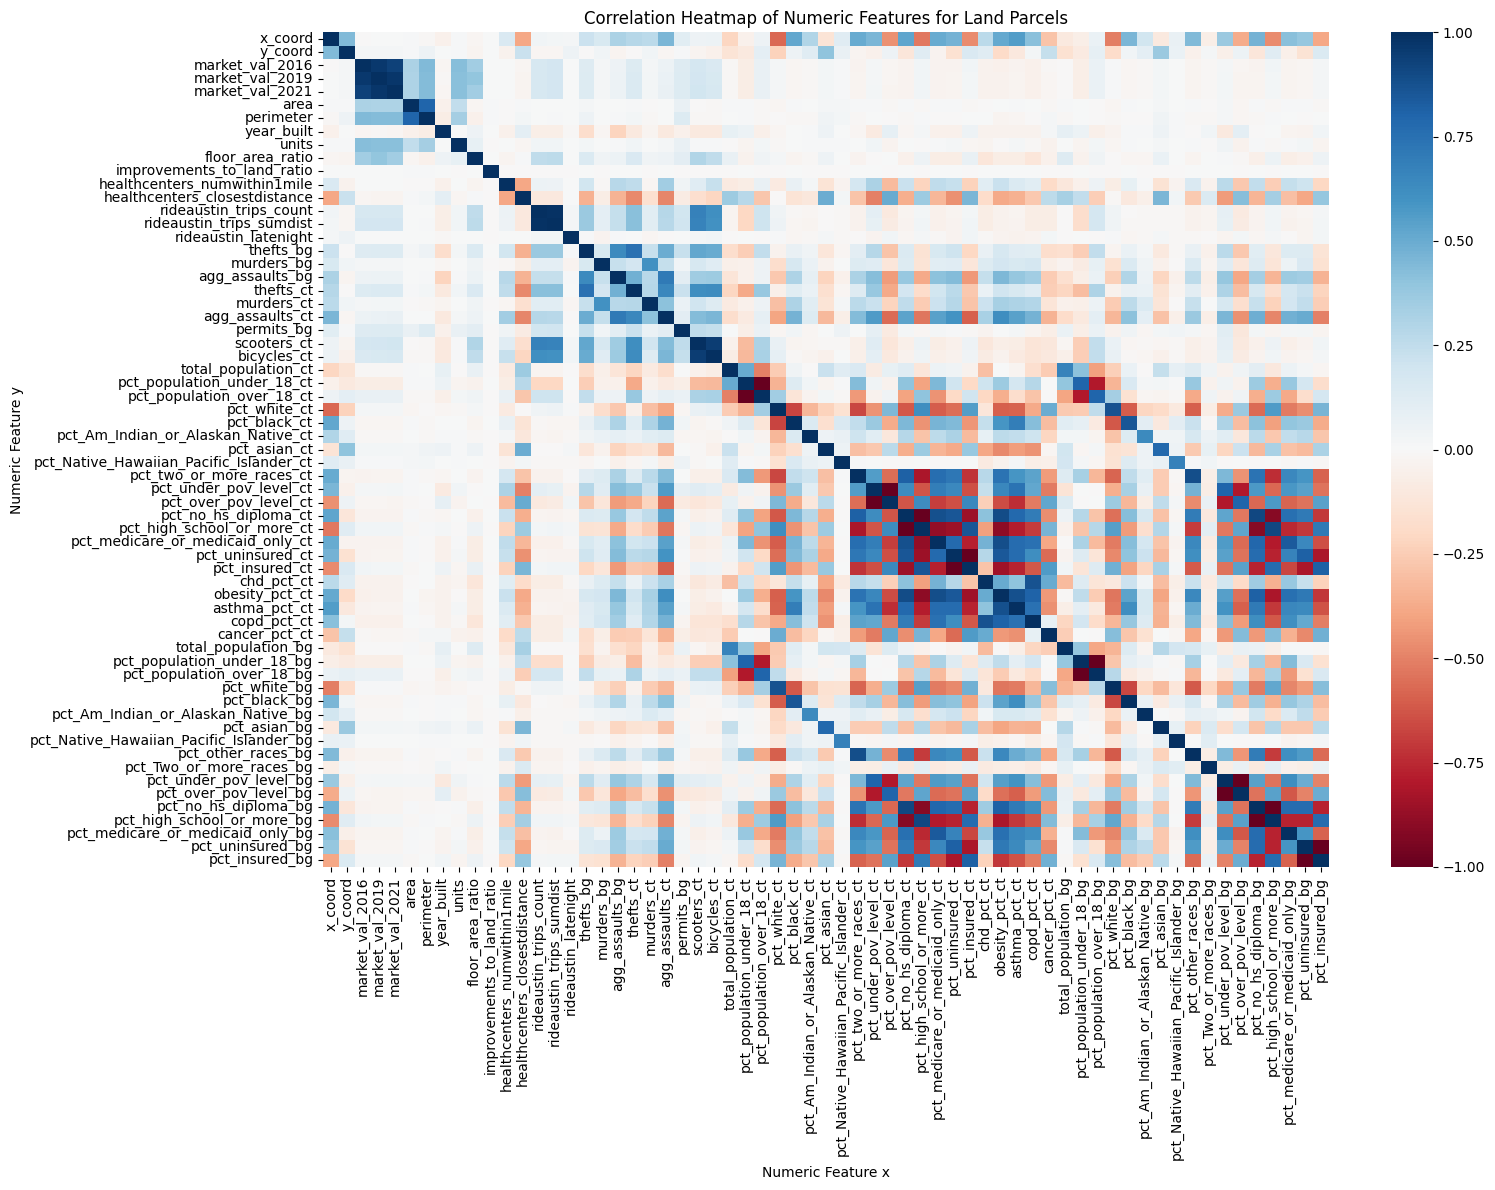

In [ ]:
# visualize correlation heat map between numeric features
corr_matrix = numeric_features.corr()
plt.figure(figsize=(16, 12))
map = sns.heatmap(corr_matrix, cmap='RdBu', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Features for Land Parcels')
plt.ylabel('Numeric Feature y')
plt.xlabel('Numeric Feature x')
plt.tight_layout()
plt.show()

Looking at the correlation heatmap above, we can make the following visual assertions focusing on market value:

1. Very strong, nearly 1.0, positive correlations exist between the three market values (2016, 2019, 2021). Since we eventually aim to predict 2019 and 2021 market values, these two values will be removed from the feature vector. However, it appears the remaining 2016 market value will likely be a decisive indicator in prediction. Furthermore, it appears that all three market values have similar / consistent correlations against all the other numeric features in the data.

2. Moderate positive correlations exist between the market values and area, perimeter, units, and floor_area_ratio features.

3. The remaining numeric features appear to have very weak positive / negative or no correlation with market values at all.

Moving forward we will only focus on identifying the very strongest (positive or negative) correlations across the matrix.

In [ ]:
# get the strongest correlations
corr_matrix_df = pd.DataFrame(corr_matrix)

In [ ]:
# for reference - strongest correlations are (+/-) 0.8 to 1.0 Very strong association
very_strong_positive = []
very_strong_negative = []

# each row in truncated matrix
for i in range(len(corr_matrix_df)):
  row_name = corr_matrix_df.columns[i]
  # each col
  # make sure to not allow = 1.0 (the diagonal)
  for j in range(len(corr_matrix_df)):
    if corr_matrix_df.iloc[i,j] == 1:
      continue
    col_name = corr_matrix_df.columns[j]
    if corr_matrix_df.iloc[i,j] >= 0.8:
      very_strong_positive.append(tuple(sorted([row_name, col_name])))
    elif corr_matrix_df.iloc[i,j] <= -0.8:
      very_strong_negative.append(tuple(sorted([row_name, col_name])))

# make sure unique tuples by turning into sets
very_strong_positive = set(very_strong_positive)
very_strong_negative = set(very_strong_negative)

In [ ]:
# very strongest postive correlations >= 0.8 (as tuples)
print('The resulting very strongest positive (>= +0.8) unique correlation pairs are:\n')
for x, y in very_strong_positive:
  print('   • \''+ x + '\', \'' + y + '\'')

The resulting very strongest positive (>= +0.8) unique correlation pairs are:

   • 'pct_insured_bg', 'pct_insured_ct'
   • 'pct_other_races_bg', 'pct_two_or_more_races_ct'
   • 'market_val_2019', 'market_val_2021'
   • 'pct_no_hs_diploma_ct', 'pct_two_or_more_races_ct'
   • 'pct_high_school_or_more_bg', 'pct_high_school_or_more_ct'
   • 'pct_no_hs_diploma_bg', 'pct_no_hs_diploma_ct'
   • 'pct_high_school_or_more_ct', 'pct_insured_ct'
   • 'copd_pct_ct', 'obesity_pct_ct'
   • 'pct_medicare_or_medicaid_only_bg', 'pct_medicare_or_medicaid_only_ct'
   • 'obesity_pct_ct', 'pct_uninsured_ct'
   • 'rideaustin_trips_count', 'rideaustin_trips_sumdist'
   • 'pct_no_hs_diploma_ct', 'pct_uninsured_ct'
   • 'obesity_pct_ct', 'pct_no_hs_diploma_ct'
   • 'pct_medicare_or_medicaid_only_ct', 'pct_no_hs_diploma_ct'
   • 'pct_uninsured_bg', 'pct_uninsured_ct'
   • 'bicycles_ct', 'scooters_ct'
   • 'market_val_2016', 'market_val_2019'
   • 'obesity_pct_ct', 'pct_medicare_or_medicaid_only_ct'
   • 'market

In [ ]:
# very strongest negative correlations <= -0.8 (as tuples)
print('The resulting very strongest negative (<= -0.8) unique correlation pairs are:\n')
for x, y in very_strong_negative:
  print('   • \''+ x + '\', \'' + y + '\'')

The resulting very strongest negative (<= -0.8) unique correlation pairs are:

   • 'pct_high_school_or_more_bg', 'pct_no_hs_diploma_ct'
   • 'pct_insured_ct', 'pct_uninsured_bg'
   • 'obesity_pct_ct', 'pct_high_school_or_more_bg'
   • 'pct_population_over_18_ct', 'pct_population_under_18_ct'
   • 'pct_insured_ct', 'pct_uninsured_ct'
   • 'pct_insured_ct', 'pct_no_hs_diploma_ct'
   • 'pct_high_school_or_more_ct', 'pct_no_hs_diploma_ct'
   • 'pct_high_school_or_more_ct', 'pct_uninsured_ct'
   • 'pct_high_school_or_more_bg', 'pct_no_hs_diploma_bg'
   • 'pct_high_school_or_more_ct', 'pct_medicare_or_medicaid_only_ct'
   • 'obesity_pct_ct', 'pct_insured_ct'
   • 'pct_over_pov_level_bg', 'pct_under_pov_level_bg'
   • 'pct_insured_bg', 'pct_uninsured_bg'
   • 'pct_high_school_or_more_ct', 'pct_no_hs_diploma_bg'
   • 'obesity_pct_ct', 'pct_high_school_or_more_ct'
   • 'pct_over_pov_level_ct', 'pct_under_pov_level_ct'
   • 'pct_insured_bg', 'pct_uninsured_ct'
   • 'pct_population_over_18_bg', 

We note that since the (eventual) target columns for prediction are 'market_val_2019' and 'market_val_2021' - any 'very strong' correlation tuples containing either of these features are not included in the following statement:


*   Since we plan on reducing the overall number of features using unsupervised learning techniques such as PCA, it's likely these "very strongly" correlated features will be linearly combined and will attribute to the same component in the reduction of features.




## Section 3.3: Visualizing Distribution of Mean Property Values


### 3.3A: Visualizing Distribution of Mean Property Values by Census Tract

Here, we will investigate the mean property market value across census tracts.  We note, since the target market values (2019, 2021) are very strongly postively correlated, WLOG we will just consider 2019 market values in the following visualization. Furthermore, since mean is impacted by outliers (extremely low or high property value), for this investigation we will only include datapoints from parcels_and_demographics_df that are within the 25%-75% quartiles.

In [ ]:
parcels_and_demographics_df['market_val_2019'].describe()

count      172132
mean       815041
std       4914275
min           539
25%        281137
50%        372675
75%        548278
max     401326200
Name: market_val_2019, dtype: float64

In [ ]:
# isolate property value and tract, filter out outliers (market values that are <25% or >75% quartiles)
mean_property_value_by_tract = parcels_and_demographics_df.copy()[['geoid_tract','market_val_2019']]
mean_property_value_by_tract = mean_property_value_by_tract[
    (mean_property_value_by_tract['market_val_2019'] <= 548277.5) &
    (mean_property_value_by_tract['market_val_2019'] >= 281137.2)
]

In [ ]:
# get mean property value per tract
mean_property_value_by_tract = mean_property_value_by_tract.groupby(
    by=['geoid_tract']).mean().reset_index().rename({'market_val_2019': 'mean_market_val_2019'}, axis=1)
print('Distribution statistics for mean market value 2019 across census tracts:')
print(mean_property_value_by_tract.describe()['mean_market_val_2019'])

Distribution statistics for mean market value 2019 across census tracts:
count      180
mean    392800
std      64181
min     283571
25%     336197
50%     378258
75%     448924
max     547500
Name: mean_market_val_2019, dtype: float64


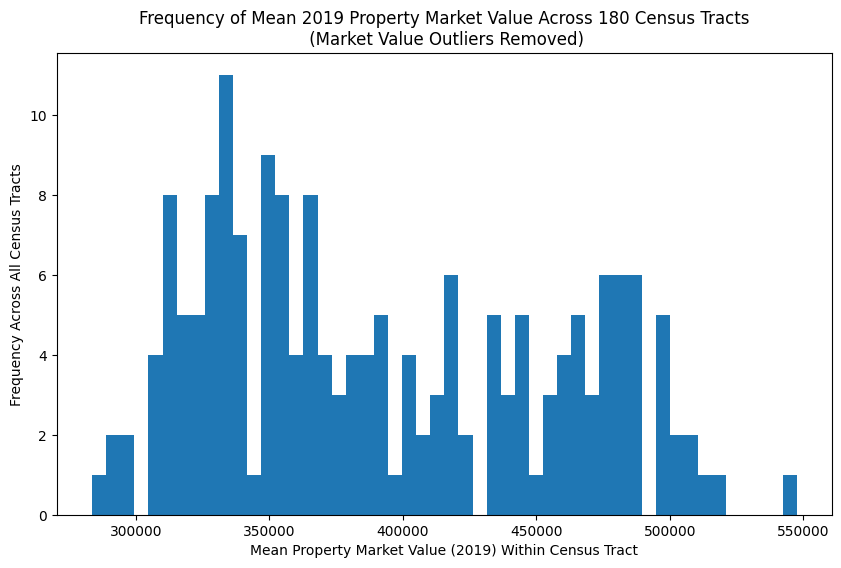

In [ ]:
# plot frequency of mean_market_value_2019 bins across census tracts
tracts = len(set(mean_property_value_by_tract['geoid_tract']))
plt.figure(figsize=(10, 6))
plt.hist(mean_property_value_by_tract['mean_market_val_2019'], bins=50)
plt.title(f'Frequency of Mean 2019 Property Market Value Across {tracts} Census Tracts\n (Market Value Outliers Removed)')
plt.xlabel('Mean Property Market Value (2019) Within Census Tract')
plt.ylabel('Frequency Across All Census Tracts')
plt.show()

### 3.3B: Visualizing Distribution of Mean Property Values by Block Group

Here, we will investigate the mean property market value across census block groups.  We note, since the target market values (2019, 2021) are very strongly postively correlated, WLOG we will just consider 2019 market values in the following visualization. Furthermore, since mean is impacted by outliers (extremely low or high property value), for this investigation we will only include datapoints from parcels_and_demographics_df that are within the 25%-75% quartiles.

In [ ]:
# isolate property value and block group, filter out outliers (market values that are <25% or >75% quartiles)
mean_property_value_by_bg = parcels_and_demographics_df.copy()[['geoid_bg','market_val_2019']]
mean_property_value_by_bg = mean_property_value_by_bg[
    (mean_property_value_by_bg['market_val_2019'] <= 548277.5) &
    (mean_property_value_by_bg['market_val_2019'] >= 281137.2)
]

In [ ]:
# get mean property value per block group
mean_property_value_by_bg = mean_property_value_by_bg.groupby(
    by=['geoid_bg']).mean().reset_index().rename({'market_val_2019': 'mean_market_val_2019'}, axis=1)
print('Distribution statistics for mean market value 2019 across census block groups:')
print(mean_property_value_by_bg.describe()['mean_market_val_2019'])

Distribution statistics for mean market value 2019 across census block groups:
count      456
mean    398161
std      68395
min     282806
25%     336528
50%     385707
75%     459592
max     548000
Name: mean_market_val_2019, dtype: float64


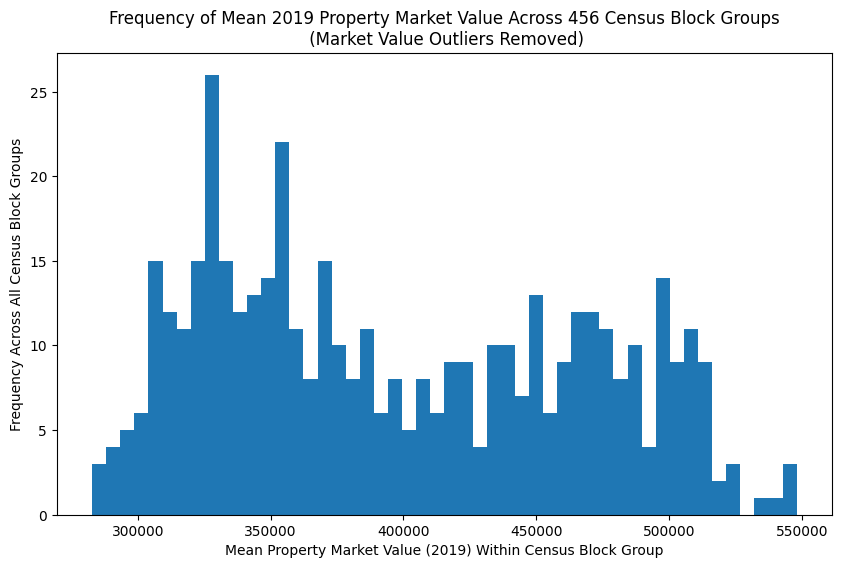

In [ ]:
# plot frequency of mean_market_value_2019 bins across census block groups
groups = len(set(mean_property_value_by_bg['geoid_bg']))
plt.figure(figsize=(10, 6))
plt.hist(mean_property_value_by_bg['mean_market_val_2019'], bins=50)
plt.title(f'Frequency of Mean 2019 Property Market Value Across {groups} Census Block Groups\n (Market Value Outliers Removed)')
plt.xlabel('Mean Property Market Value (2019) Within Census Block Group')
plt.ylabel('Frequency Across All Census Block Groups')
plt.show()

### 3.3C: Comparing Census Tract and Census Block Group Results


Comparing overall means:

* Overall mean of mean property market values (2019) across census tracts ≈ \$ 393,000
* Overall mean of mean property market values (2019) across census block groups ≈ \$ 398,000

Comparing standard deviations:

* Standard deviation of mean property market values (2019) across census tracts ≈ \$ 64,000
* Standard deviation of mean property market values (2019) across census block groups ≈ \$ 68,000


Although census block groups are smaller subdivisions within census tracts, the overall mean of mean property market values (2019) is similar across both census tracts and census block groups (with a difference of only ~\$5,000). The standard deviation is also similar across both census tracts and census block groups (with a difference of only ~\$4,000). Therefore, it appears that mean property market values (2019) are similarly distributed across census tracts and census block groups.

## Section 3.4: Investigating Dimensionality Reduction Using PCA


### 3.4A: Isolating Features and Predictive Targets

We believe that land parcel data, crime reports, transportation reports, as well as census demographics and health outcomes can all be integrated together (joined via census tract and block group designation) to accurately predict property market value.

Therefore using the **parcels_and_demographics_df** formed in Section 2, we will (separately) predict the numerical columns of 'market_val_2019' and 'market_val_2021', which are the parcels' recorded property market values in 2019 and 2021, respectively.

We note that predicting property market value in 2019 vs 2021 will require separate predictive models, whose peformances will be evaluated and compared using the same training and test sets of input features.

In [ ]:
parcels_and_demographics_df.to_csv('/content/drive/Shareddrives/545_GroupProject/Modeling/ModelingExports/parcels_and_demographcis.csv')

In [ ]:
# isolate features
X = parcels_and_demographics_df.drop(columns=['market_val_2019', 'market_val_2021'])

# isolate target predictive values
y_market_val_2019 = parcels_and_demographics_df['market_val_2019']
y_market_val_2021 = parcels_and_demographics_df['market_val_2021']

The following fields in the feature df X are categorical in nature, and therefore need to be one-hot encoded before moving forward:

'geoid_bg', 'geoid_tract', 'land_use', 'lu_desc', 'council_dist'

In [ ]:
# one-hot encode categorical features
X = pd.get_dummies(X, columns=['geoid_bg', 'geoid_tract', 'land_use',
                                       'lu_desc', 'council_dist'], sparse=True)
# convert all booleans / ints to floats
X = X.astype(float)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172132 entries, 0 to 172131
Columns: 822 entries, x_coord to council_dist_10
dtypes: float64(822)
memory usage: 1.1 GB


Since one-hot encoding all categorical columns in X created an incredibly high-dimensional feature vector (822 features total), we will proceed with dimensionality reduction using principal component analysis (unsupervised learning) before predictive modelling.

### 3.4B: Splitting Into Training and Test Sets

Splitting our encoded features (X) and predictive targets (y_market_val_2019, y_market_val_2021) sets into training and test sets using the same random_seed=42 will allow us to train / test our separate models using the same feature instances from X. This, therefore, allows us to more accurately evaluate the difference in performance of the model for predicting y_market_val_2019 vs. the model predicting y_market_val_2021.

In [ ]:
# setting consistent random_seed to ensure our feature training and test
# instances are the same
random_seed = 42

In [ ]:
# splitting into training and test sets for 2019
X_train_2019, X_test_2019, y_train_2019, y_test_2019 = train_test_split(X,
                                                              y_market_val_2019,
                                                              test_size=0.2,
                                                              random_state=random_seed)

# splitting into training and test sets for 2021
X_train_2021, X_test_2021, y_train_2021, y_test_2021 = train_test_split(X,
                                                              y_market_val_2021,
                                                              test_size=0.2,
                                                              random_state=random_seed)

In [ ]:
# checking that X_train_2019 and X_train_2021 are the same
print('X_train_2019 == X_train_2021 -> ' + str(X_train_2019.equals(X_train_2021)))

# checking that X_test_2019 and X_test_2021 are the same
print('X_test_2019 == X_test_2021 -> ' + str(X_test_2019.equals(X_test_2021)))

X_train_2019 == X_train_2021 -> True
X_test_2019 == X_test_2021 -> True


In [ ]:
# since the feature training and test sets are the same, just assign to singular
# set to share amongst the different predictive models
# NOTE: WLOG choosing 2019
X_train = X_train_2019.copy()
X_test = X_test_2019.copy()

In [ ]:
X_train_raw_df = pd.DataFrame(X_train)
# X_train_df.to_csv('/content/drive/Shareddrives/545_GroupProject/Analysis/Training/X_train_standard.csv')
# X_train_df = None

In [ ]:
X_train_raw_df

,x_coord,y_coord,market_val_2016,area,perimeter,year_built,units,floor_area_ratio,improvements_to_land_ratio,healthcenters_numwithin1mile,...,council_dist_1,council_dist_2,council_dist_3,council_dist_4,council_dist_5,council_dist_6,council_dist_7,council_dist_8,council_dist_9,council_dist_10
39484,620657.333037,3.361129e+06,484933.0,1656.516379,169.0,1963.0,1.0,0.133072,1.424665,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
152899,620344.976367,3.340737e+06,160387.0,976.498873,136.0,1977.0,1.0,0.152054,2.207740,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7727,622412.363547,3.355080e+06,340400.0,958.463749,145.0,1967.0,4.0,0.325796,0.418333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
105348,629912.505283,3.360373e+06,27222.0,915.297103,134.0,2016.0,0.0,0.254196,0.000000,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47810,618213.827397,3.358450e+06,881423.0,2436.244648,201.0,1988.0,1.0,0.179970,1.260059,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,616609.687368,3.347158e+06,659120.0,1525.180261,170.0,1977.0,1.0,0.171230,0.647800,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
103694,626704.043855,3.359171e+06,163970.0,713.669527,114.0,1973.0,1.0,0.251746,2.643778,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
131932,626193.547744,3.352269e+06,262069.0,1284.895592,159.0,1960.0,1.0,0.110647,0.747127,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146867,617647.616506,3.342197e+06,208771.0,880.388694,124.0,1970.0,1.0,0.132691,1.087710,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.4C: Investigating Feature Dimensionality Reduction Using PCA

Now that our training and test sets of encoded features (X_train, X_test) have been isolated, there are a total of 822 different features to consider as predictors for market value. Since this is incredibly high-dimensional, we must use unsupervised learning techniques to identify underlying structure to reduce the overall number of features used in prediction.

For this task, we will use principal component analysis and evaluate the proportion of variance explained to determine the sufficient number of principal components needed to transform / reduce our input feature vectors.

In [ ]:
# address scale-invariance in PCA
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# get max. number of principal components
num_features = len(X_train[0])
print(f'Number of features before PCA = {num_features}')

Number of features before PCA = 822


In [ ]:
# run PCA, plot cumulative explained variance ratio
pca = PCA(n_components=num_features)
pca_features_train = pca.fit_transform(X_train)

explained_variance_ratios = np.array(pca.explained_variance_ratio_)
cum_pver = np.cumsum(explained_variance_ratios)

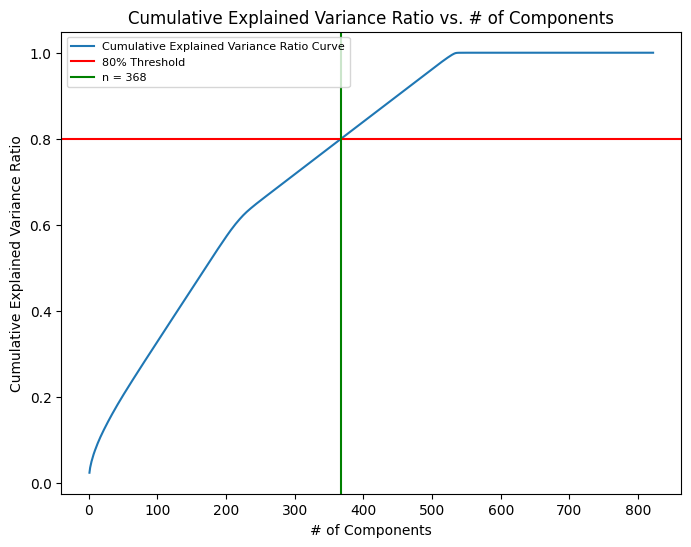


Number of recomended features after PCA using 80% cumulative PVE ratio = 368


In [ ]:
# Find optimal num components to use by plotting cumulative variance explained ratio
m = range(1, num_features + 1)

plt.figure(figsize=(8, 6))
plt.title('Cumulative Explained Variance Ratio vs. # of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.xlabel('# of Components')
plt.plot(m, cum_pver, label='Cumulative Explained Variance Ratio Curve')
plt.axhline(0.8, color='r', label="80% Threshold")
plt.xticks(range(0, 801, 100))

# determined # of components at PVER threshold 80%
n = [i for i in m if cum_pver[i-1] >= 0.8][0]

plt.axvline(n, color='g', label=f"n = {n}")
plt.legend(loc="upper left", fontsize="8")
plt.show()

print('\nNumber of recomended features after PCA using 80% cumulative PVE ratio = ' + str(f'{n}'))

As seen above, the first 368 principal components found in PCA contribute to the first 80% of the cumulative proportion variance explained ratio. After this point, there are diminishing returns with respect to the information gained through increasing complexity. Furthermore, we note that using only the first 368 principal components from PCA would transform and reduce the input feature vector from 822 -> 368 features.

Before moving forward, we would like to investigate the individual proproportion variance explained ratios for each principal component, and see if the 'elbow' of PVE ratios aligns with the result from cumulative PVE ratio.

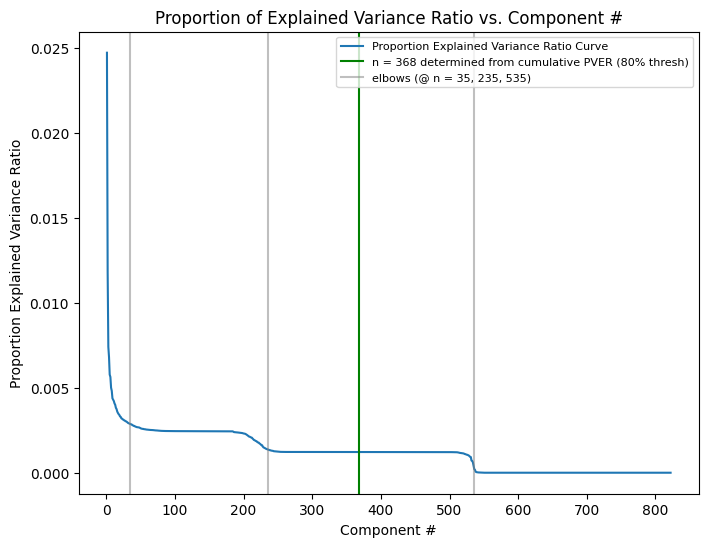

In [ ]:
# investigate each individual proproportion variance explained ratio
# see if the # of principal components (n) above is at an elbow
m = range(1, num_features + 1)

plt.figure(figsize=(8, 6))
plt.title('Proportion of Explained Variance Ratio vs. Component #')
plt.ylabel('Proportion Explained Variance Ratio')
plt.xlabel('Component #')
plt.plot(m, explained_variance_ratios, label='Proportion Explained Variance Ratio Curve')
plt.axvline(n, color='g', label=f"n = {n} determined from cumulative PVER (80% thresh)")
plt.axvline(35, color='gray', alpha=0.5)
plt.axvline(235, color='gray', alpha=0.5)
plt.axvline(535, color='gray', label='elbows (@ n = 35, 235, 535)', alpha=0.5)
plt.xticks(range(0, 801, 100))
plt.legend(loc="upper right", fontsize="8")
plt.show()

Looking at the individual proportions of explained variance ratios, we can see that there are 3 major elbows after which following components start to plateau / have diminishing returns in variance.

1. n ≈ 35 components
2. n ≈ 235 components
3. n ≈ 535 components

This behavior could potentially be explained from the fact that we're integrating three levels of information:

1. individual level: land parcel data
2. census block group level: demographics, crime and transportation
3. census tract level: health outcomes, demographics, crime and transportation

Each land parcel within a certain block group will have the same reported census block group demographics, crime and transportation as any other property within that census block group. Similarly, each land parcel within a certain census tract will have the same reported census tract health outcomes, demographics, crime and transportation as any other property within that census tract. Since block groups are sub-divisions contained within census tracts, its notable that block group information may be more granular vs. tract information across the set of land parcels.

It's possible that certain defining "individual" features i.e. the unique land parcel information is contributing more variance vs the "shared" features at a  block group or tract level. Therefore, it's likely that more granular details attribute more variance vs. higher level details and that each elbow in the PVER graph above indicates the # of components at which:

1. individual level features have diminishing returns (n > 35)
2. block group level features have diminishing returns (n > 235)
3. census tract level features have diminishing returns (n > 535)

We can investigate this further by looking at the contribution of each level's features to each principal component.

In [ ]:
# investigating contribution of each feature to each principal component
components = pca.components_
# scale the loadings - ensure reflects the contribution of each variable to the overall VE by the component
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
df_loadings = pd.DataFrame(loadings, index=[f'PC{i+1}' for i in range(len(pca.components_))],
                           columns=[f'Feature_{j+1}' for j in range(len(pca.components_[0]))])

In [ ]:
# indentify features names for each level
individual_level_cols = []
bg_level_cols = []
tract_level_cols = []

# refer to feature number
individual_level_features = []
bg_level_features = []
tract_level_features = []

for i in range(len(X.columns)):
  col = X.columns[i]
  if '_ct' in col or 'tract' in col or 'council_dist' in col:
    tract_level_cols.append(col)
    tract_level_features.append(f'Feature_{i+1}')
  elif '_bg' in col:
    bg_level_cols.append(col)
    bg_level_features.append(f'Feature_{i+1}')
  else:
    individual_level_cols.append(col)
    individual_level_features.append(f'Feature_{i+1}')

In [ ]:
# get total loading contribution of each level (using absolute values)
def level_contribution(df_loadings, level_features):
  num_PC = len(df_loadings)
  loading_sum = np.zeros((num_PC, 1))
  # for each PC
  for i in range(num_PC):
    # for each PCi feature
    for feature in level_features:
      # get feature's abs(contribution) to PCi
      # note: using abs values allows us to consider MAGNITUDE of contribution
      # of each feature on the components VE
      loading_sum[i] += np.abs(df_loadings[feature][i])
  return loading_sum

In [ ]:
# get total magnitude of contribution at each level
df_loadings['individual_level'] = level_contribution(df_loadings, individual_level_features)
df_loadings['bg_level'] = level_contribution(df_loadings, bg_level_features)
df_loadings['tract_level'] = level_contribution(df_loadings, tract_level_features)
# isolate the contributions in the df
df_loadings = df_loadings[['individual_level', 'bg_level', 'tract_level']]

In [ ]:
# scale contributions to get comparable results across levels
scaler = StandardScaler()
df_loadings = scaler.fit_transform(df_loadings)
df_loadings = pd.DataFrame({'individual_level': df_loadings[:,0],
                            'bg_level': df_loadings[:,1],
                            'tract_level': df_loadings[:,2],})

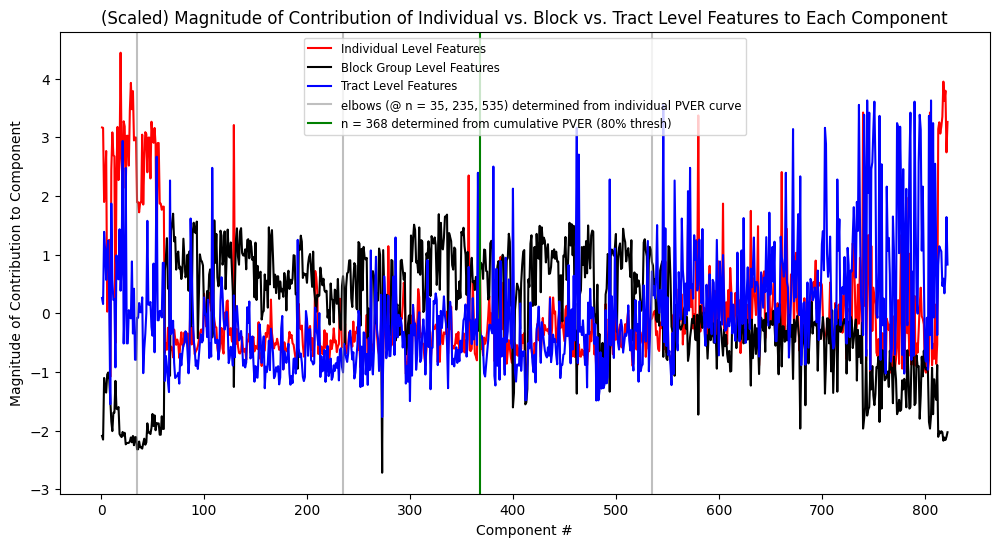

In [ ]:
# Contributions of individual vs. block vs. tract level features
plt.figure(figsize=(12, 6))
plt.title('(Scaled) Magnitude of Contribution of Individual vs. Block vs. Tract Level Features to Each Component')
plt.plot(m, df_loadings['individual_level'], color='r', label='Individual Level Features')
plt.plot(m, df_loadings['bg_level'], color='black', label='Block Group Level Features')
plt.plot(m, df_loadings['tract_level'], color='b', label='Tract Level Features')
plt.xticks(range(0, 801, 100))
plt.ylabel('Magnitude of Contribution to Component')
plt.xlabel('Component #')
plt.axvline(35, color='gray', alpha=0.5)
plt.axvline(235, color='gray', alpha=0.5)
plt.axvline(535, color='gray', label='elbows (@ n = 35, 235, 535) determined from individual PVER curve', alpha=0.5)
plt.axvline(n, color='g', label=f"n = {n} determined from cumulative PVER (80% thresh)")
plt.legend(loc='best', fontsize='small')
plt.show()

As a recap: during investigation of the individual PVE ratios of each principal component, we determined that the 3 elbows (at component # n = 35, 235, 535) may be due to the effect of integrating data at three "levels", such that the following hypotheses formed:

1. n > 35 components is when individual level features begin to have diminishing returns
2. n > 235 components is when block group level features begin to have diminishing returns
3. n > 535 components is when census group level features begin to have diminishing returns

To test these, we computed the magnitude of contribution of each level's relevant features to each principal component. The above graph is the result of this consideration, showing contribution curves for each of the following:

1. individual level feature contribution to components (red curve)
2. block group level features contribution to components (black curve)
3. census tract level features to components (blue curve)

Looking at this graph it appears that the curves could potentially support our hypotheses. However, the spiky-behavior of the graph is difficult to interpret. Therefore, we will apply a moving average (window size = 25) to smooth out these trends.

In [ ]:
# apply smoothing using moving average across contribution to lessen spikes
window = 25
df_loadings['individual_level_smooth'] = np.convolve(df_loadings['individual_level'],
                                                     np.ones(window)/window,
                                                     mode='same')
df_loadings['bg_level_smooth'] = np.convolve(df_loadings['bg_level'],
                                                     np.ones(window)/window,
                                                     mode='same')
df_loadings['tract_level_smooth'] = np.convolve(df_loadings['tract_level'],
                                                     np.ones(window)/window,
                                                     mode='same')

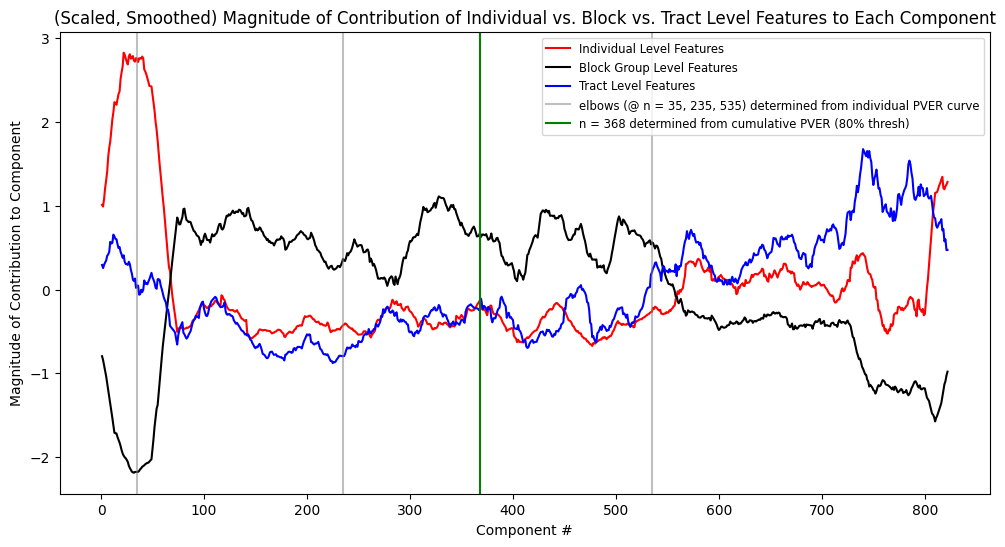

In [ ]:
# Contributions of smoothed individual vs. block vs. tract level features
plt.figure(figsize=(12, 6))
plt.title('(Scaled, Smoothed) Magnitude of Contribution of Individual vs. Block vs. Tract Level Features to Each Component')
plt.plot(m, df_loadings['individual_level_smooth'], color='r', label='Individual Level Features')
plt.plot(m, df_loadings['bg_level_smooth'], color='black', label='Block Group Level Features')
plt.plot(m, df_loadings['tract_level_smooth'], color='b', label='Tract Level Features')
plt.xticks(range(0, 801, 100))
plt.ylabel('Magnitude of Contribution to Component')
plt.xlabel('Component #')
plt.axvline(35, color='gray', alpha=0.5)
plt.axvline(235, color='gray', alpha=0.5)
plt.axvline(535, color='gray', label='elbows (@ n = 35, 235, 535) determined from individual PVER curve', alpha=0.5)
plt.axvline(n, color='g', label=f"n = {n} determined from cumulative PVER (80% thresh)")
plt.legend(loc='best', fontsize='small')
plt.show()


Looking at the slighty-smoothed magnitude of contribution curves, we can make a few conclusions:

1. Individual-level features appear to contribute the most towards the first ~60 components, with a point of drop-off around the first elbow of n = 35
2. Block-group-level features contribute the most towards the next 60 - 535 components, and experiences a drop-off around the third elbow of n = 535
3. It appears that Individual-level, Block-Group-level, and Tract-level features have a similar amounts of contribution towards the last 535 - 822 components, with an emphasis on Tract-level features as we get closer to 822

With these conclusions, its possible that our earlier hypothesis that "n > 35 components is when individual level features begin to have diminishing returns" is supported by the above chart.

However, the other two claims surrounding the elbows at n = 235 and n = 535 are less clear. It may be more likely that these elbows indicate points at which all features start to have diminishing returns in variance, regardless of their "level".

### 3.4D: Final PCA Transformation

From the PCA exploration in 5.3, we determined:

1. Plotting cumulative proportion of variance explained ratios, the first n = 368 principal components account for the first 80% of the cum. PVE
2. Plotting individual proportions of variance explained ratios, there are three elbows at: the first n = 35 components, the first n = 235 components, and the first n = 535 components.
3. Plotting the magnitude of contribution of "individual-level", "block-group-level", and "tract-level" features towards each principal component, it's likely the first elbow at n = 35 is due to diminishing returns in variance from the "individual-level" features of the parcels. However, the cause of the other two elbows are less clear. Overall, as the number of component increases, the contributions between "levels" of features towards the components start to even-out.

Because of this, we suggest moving forward with PCA using the first n = 368 principal components in feature vector transformation found using cumulative proportion of variance explained ratios (80% thresh). We note that this number of components allows us to capture enough variance from all "levels" of features (individual-level, block-group-level, tract-level) while still not getting too far into the weeds with diminishing returns.

In [ ]:
# re-run PCA with (n = 368) components as determined by cumulative PVE
n = 368
pca = PCA(n_components=n)

# get transformed training and test features
pca_features_train = pca.fit_transform(X_train)
pca_features_test = pca.transform(X_test)

## Section 3.5: Exporting Final Training and Testing Data for Data Modeling


The following arrays will be converted and exported as .csv to be used for data modeling:


*   **Features Before PCA**: same set to be used for both 2019 and 2021
  *   X_train: original standardized feature vector inputs for training
  *   X_test: original standardized feature vector inputs for testing
*   **Features After PCA**: same set to be used for both 2019 and 2021
  *   pca_features_train: transformed / reduced feature vector of X_train after PCA to be inputs for training
  *   pca_features_test: transformed / reduced feature vector of X_test after PCA to be inputs for testing
*   **Targets**: for predictive modeling (note: 2019 and 2021 will have separate models)
  *   y_train_2019: training values for predicting 2019 market value
  *   y_test_2019: test values for predicting 2019 market value

  *   y_train_2021: training values for predicting 2021 market value
  *   y_test_2021: test values for predicting 2021 market value

NOTE: all of this will be commented out once it's exported - to prevent overwriting any files.

In [ ]:
# convert pca feature vectors into dataframes for export
# set to None when done to conserve RAM

# pca_features_train_df = pd.DataFrame(pca_features_train, columns=[f'PCA_Feature_{j+1}' for j in range(n)])
# pca_features_train_df.to_csv('/content/drive/Shareddrives/545_GroupProject/Analysis/Training/pca_features_train.csv')
# pca_features_train_df = None

# pca_features_test_df = pd.DataFrame(pca_features_test, columns=[f'PCA_Feature_{j+1}' for j in range(n)])
# pca_features_test_df.to_csv('/content/drive/Shareddrives/545_GroupProject/Analysis/Testing/pca_features_test.csv')
# pca_features_test_df = None

In [ ]:
# convert standardized feature vectors (before PCA) into dataframes for export
# set to None when done to conserve RAM

# X_train_df = pd.DataFrame(X_train, columns=[f'{X.columns[j]}' for j in range(len(X.columns))])
# X_train_df.to_csv('/content/drive/Shareddrives/545_GroupProject/Analysis/Training/X_train_standard.csv')
# X_train_df = None

# X_test_df = pd.DataFrame(X_test, columns=[f'{X.columns[j]}' for j in range(len(X.columns))])
# X_test_df.to_csv('/content/drive/Shareddrives/545_GroupProject/Analysis/Testing/X_test_standard.csv')
# X_test_df = None

In [ ]:
# convert target training vectors into dataframes for export
# set to None when done to conserve RAM

# y_train_2019_df = pd.DataFrame(y_train_2019).reset_index().drop(columns='index')
# y_train_2019_df.to_csv('/content/drive/Shareddrives/545_GroupProject/Analysis/Training/y_train_2019.csv')
# y_train_2019_df = None

# y_train_2021_df = pd.DataFrame(y_train_2021).reset_index().drop(columns='index')
# y_train_2021_df.to_csv('/content/drive/Shareddrives/545_GroupProject/Analysis/Training/y_train_2021.csv')
# y_train_2021_df = None

In [ ]:
# convert target training vectors into dataframes for export
# set to None when done to conserve RAM

# y_test_2019_df = pd.DataFrame(y_test_2019).reset_index().drop(columns='index')
# y_test_2019_df.to_csv('/content/drive/Shareddrives/545_GroupProject/Analysis/Testing/y_test_2019.csv')
# y_test_2019_df = None

# y_test_2021_df = pd.DataFrame(y_test_2021).reset_index().drop(columns='index')
# y_test_2021_df.to_csv('/content/drive/Shareddrives/545_GroupProject/Analysis/Testing/y_test_2021.csv')
# y_test_2021_df = None

## Section 3.6: Visualizing Data in 2D

After the PCA investigation above, we see the input feature vector has been reduced from 822 to the first 368 principal components. Here, we will consider just the first two (most important) principal components to visualize the features in two dimensions. We note, since the target market values (2019, 2021) are very strongly postively correlated, WLOG we will just consider 2019 market values in the following visualization.

In [ ]:
# first consider the distribution of y_train_2019 market values
market_value_2019_train = y_train_2019.reset_index().drop(columns=['index'])
market_value_2019_train.describe()

,market_val_2019
count,1.377050e+05
mean,8.227448e+05
std,4.938842e+06
min,5.390000e+02
25%,2.812900e+05
50%,3.730900e+05
75%,5.495230e+05
max,4.013262e+08


Since there appears to be some outliers (extremely low or high property value), for this investigation we will only include datapoints from pca_features_train and y_train_2019 that are within the 25%-75% quartiles. We do this since there are limitations to the color bar range when plotting.

In [ ]:
# join with market value, filter out outliers (market values that are <25% or >75% quartiles)
features_2d = pd.DataFrame(pca_features_train[:,0:2], columns=['PC1', 'PC2'])
features_2d['market_val_2019'] = market_value_2019_train['market_val_2019']
features_2d = features_2d[
    (features_2d['market_val_2019'] <= 549523) &
    (features_2d['market_val_2019'] >= 281290)
]

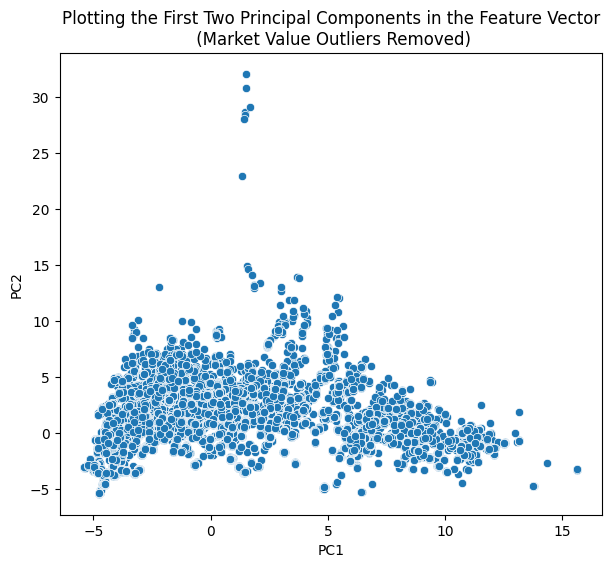

In [ ]:
# plot the first 2 components in 2D to see if any natural cluster form
plt.figure(figsize=(7,6))
sns.scatterplot(x=features_2d['PC1'], y=features_2d['PC2'])
plt.title('Plotting the First Two Principal Components in the Feature Vector\n (Market Value Outliers Removed)')
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

As seen above, it appears that plotting the transformed PCA features in 2D using just the first two principal compnents, there could be some natural cluster formation. To explore this, we will re-run to see if any of the visual clusters formed has any visual relation with market values.

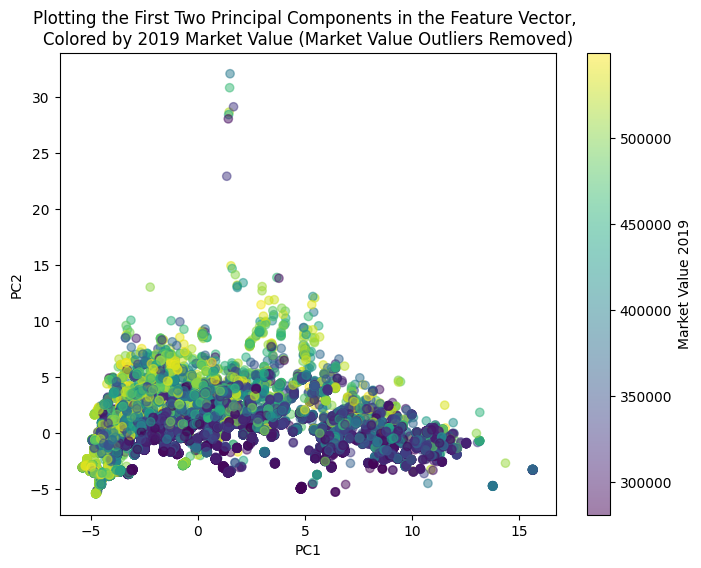

In [ ]:
# plot the first 2 components in 2D to see if any natural cluster form
# colored by property value
plt.figure(figsize=(8,6))
plt.title('Plotting the First Two Principal Components in the Feature Vector, \nColored by 2019 Market Value (Market Value Outliers Removed)')
plt.scatter(x=features_2d['PC1'], y=features_2d['PC2'], c=features_2d['market_val_2019'], alpha=0.5)
plt.colorbar(label='Market Value 2019')
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

Looking at the market-value-color-coded version of the two dimensions above, there DOES appear to be a visual relation between the natural clusters formed and 2019 market value (when market value outliers are removed). In that, it appears that similarly-priced points are grouped together when plotted in 2D using the first two principal components. We can look at this closer, focusing on the dense cloud of data points.

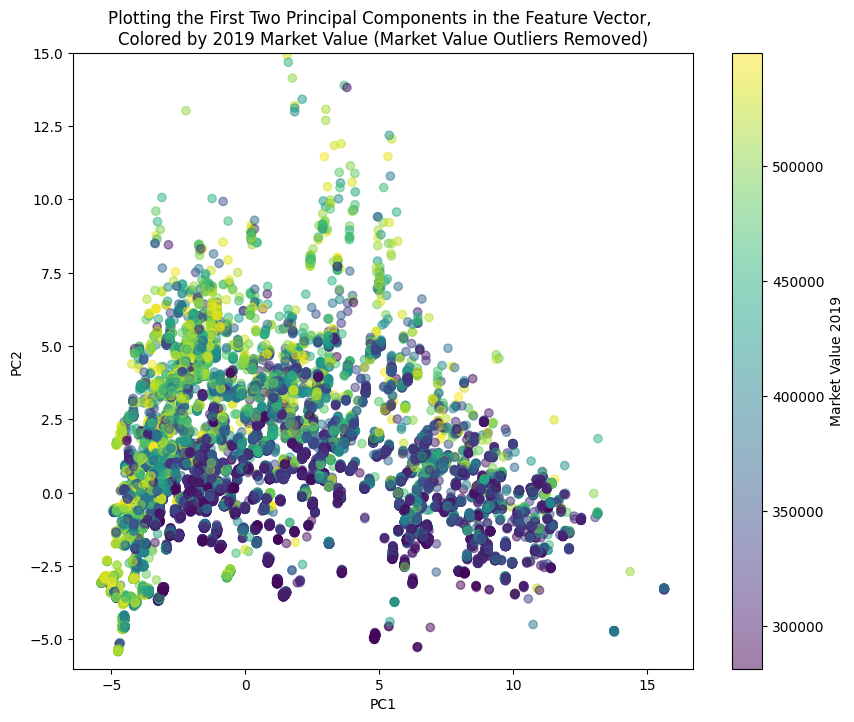

In [ ]:
# plot the first 2 components in 2D to see if any natural cluster form
# colored by property value
# zoomed-in view, focusing on the dense cluster of points
plt.figure(figsize=(10,8))
plt.title('Plotting the First Two Principal Components in the Feature Vector, \nColored by 2019 Market Value (Market Value Outliers Removed)')
plt.scatter(x=features_2d['PC1'], y=features_2d['PC2'], c=features_2d['market_val_2019'], alpha=0.5)
plt.colorbar(label='Market Value 2019')
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.ylim(-6, 15)
plt.show()

Here, it's clear that similarly-priced points are grouped together / near each other when plotted in 2D using the first two principal components. Because of this, if market value were converted into discrete bins (i.e. within a certain price range), it's possible that multinomial logistic classification may be able to accurately predict market value bins using just the first two prinicpal components.

# **Section 4: Modeling**

## Modeling Overview

We first investigated continuous models through different "flavors" of linear regression, and then decided to investigate how well our models could predict categorical home prices.  

Each model was fit and trained twice; either to the 2019 and 2021 home prices (in the case of our continuous models) or to the 2019 and 2021 pricing quartiles (more on the rationale behind this decision to follow).   

## **Section 4.1: Linear Regression Modeling in SK Learn**

*Additional* package imports for simple regression modeling:

### Additional package imports to run this section independently:

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip3 install pyspark

import pyspark
from pyspark.sql.types import *
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import col, to_timestamp, to_date
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, LongType, DoubleType, StringType

spark = SparkSession.builder.master("local[*]").getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=8ed1735433792b5327b975c9f340d6d291b6d8a38abd4c54b0f8b39af36be5e5
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [ ]:
# Data integration, exploratory data analysis, and data visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Dimensionality Reduction
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
# Regression modeling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.cluster import KMeans
from IPython.display import Math, HTML

# Dataframe formatting
pd.options.display.float_format = '{:.0f}'.format

Import clean training datasets:

In [ ]:
pca_features_train_df = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Analysis/Training/pca_features_train.csv')
pca_features_train_df.drop(['Unnamed: 0'], axis='columns', inplace=True)
y_train_2019_df = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Analysis/Training/y_train_2019.csv')
y_train_2019_df.drop(['Unnamed: 0'], axis='columns', inplace=True)
y_train_2021_df = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Analysis/Training/y_train_2021.csv')
y_train_2021_df.drop(['Unnamed: 0'], axis='columns', inplace=True)

Import clean testing datasets:

In [ ]:
pca_features_test_df = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Analysis/Testing/pca_features_test.csv')
pca_features_test_df.drop(['Unnamed: 0'], axis='columns', inplace=True)
y_test_2019_df = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Analysis/Testing/y_test_2019.csv')
y_test_2019_df.drop(['Unnamed: 0'], axis='columns', inplace=True)
y_test_2021_df = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Analysis/Testing/y_test_2021.csv')
y_test_2021_df.drop(['Unnamed: 0'], axis='columns', inplace=True)

In [ ]:
# raw testing dataset:
X_train_raw = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Analysis/Training/X_train_standard.csv')
X_test_raw = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Analysis/Testing/X_test_standard.csv')

### 4.1A: Simple Linear Regression

#### 4.1A-1: Simple Linear Regression for the 2019 dataset:


Our overall goal for the project was to predict property market values in 2019 and 2021 within the city limits of Austin, TX.  Because this data is continuous, it seemed reasonable to start our modeling investigation with simple linear regression modeling as follows:


In [ ]:
# "Vanilla" linear regression fit to our pca data and 2019 market prices

lin_reg_2019 = LinearRegression().fit(pca_features_train_df, y_train_2019_df)

y_reg_pred_2019 = lin_reg_2019.predict(pca_features_test_df)

lin_reg_score_2019 = lin_reg_2019.score(pca_features_test_df, y_test_2019_df)

lin_reg_score_2019

In [ ]:
y_pred_2019_df = pd.DataFrame(y_reg_pred_2019)
y_pred_2019_df = y_pred_2019_df.rename(columns={0: 'predicted_market_val_2019'})

In [ ]:
actual_pred_pd_2019 = pd.concat([y_test_2019_df, y_pred_2019_df], axis=1)

$R^2$ for 2019 Market Predictions: 0.4908093212113297

Our $R^2$ value allows us to conclude that this model is only able to explain about half of the observed variance.  

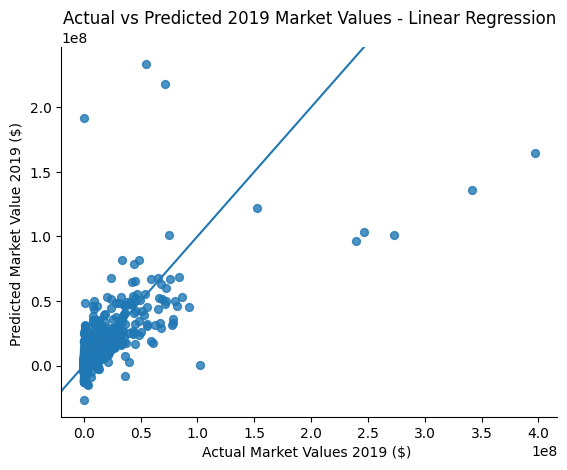

In [ ]:
# @title Actual vs Predicted 2019 Market Values - Linear Regression
actual_pred_pd_2019.plot(kind='scatter', x='market_val_2019', y='predicted_market_val_2019', s=32, alpha=.8)

plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('Actual Market Values 2019 ($) ')
plt.ylabel('Predicted Market Value 2019 ($) ')
plt.title('Actual vs Predicted 2019 Market Values - Linear Regression')

x1, y1 = 0, 0
x2, y2 = 1, 1
plt.axline((x1, y1), (x2, y2))

The above figure plots the actual Market Values against the Predicted Market values, along with they line x=y to help visualize whether the model is consistently over or under estimating the predicted values.

While the model appears to perform appropriately and does not consistently over or under estimate values, the outliers and clustering patterns make it clear that simple linear regression model will probably not produce good continuous results.  Below, we repeat this process for the 2021 data.  

#### 4.1A-2: Simple Linear Regression for the 2021 dataset:

For all of our models we fit each one twice; one to the 2019 data and one to the 2021 data.  The main motivation was curiosity around predicting housing values pre and post pandemic, and to think about whether there

In [ ]:
lin_reg_2021 = LinearRegression().fit(pca_features_train_df, y_train_2021_df)

y_reg_pred_2021 = lin_reg_2021.predict(pca_features_test_df)

lin_reg_score_2021 = lin_reg_2021.score(pca_features_test_df, y_test_2021_df)

lin_reg_score_2021

0.5127197558853946

In [ ]:
y_pred_2021_df = pd.DataFrame(y_reg_pred_2021)
y_pred_2021_df = y_pred_2021_df.rename(columns={0: 'predicted_market_val_2021'})

$R^2$ for 2021 Market Predictions: 0.5127197558853946


In [ ]:
actual_pred_pd_2021 = pd.concat([y_test_2021_df, y_pred_2021_df], axis=1)

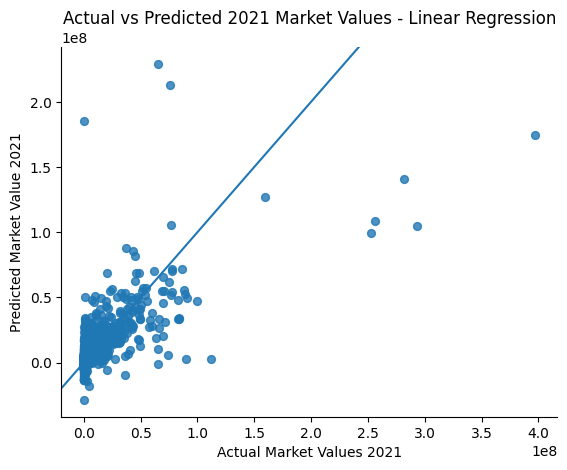

In [ ]:
# @title Actual vs Predicted 2021 Market Values - Linear Regression
actual_pred_pd_2021.plot(kind='scatter', x='market_val_2021', y='predicted_market_val_2021', s=32, alpha=.8)

plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('Actual Market Values 2021')
plt.ylabel('Predicted Market Value 2021')
plt.title('Actual vs Predicted 2021 Market Values - Linear Regression')

x1, y1 = 0, 0
x2, y2 = 1, 1
plt.axline((x1, y1), (x2, y2))

The above figure plots the actual Market Values against the Predicted Market values for 2021, along with they line x=y to help visualize whether the model is consistently over or under estimating the predicted values.

This output appears consistent with the 2019 visualization; again while the model does not consistently over or under estimate values, the outliers and clustering patterns make it clear that simple linear regression model will probably not produce satisfying continuous results.  

## 4.1B: Lasso Regression

Motivation: Lasso Regression improves on "Vanilla" Linear Regression by helping generalize the model and reduce overfitting.  Our uniquely clustered data and the presence of outliers made us believe this might be helpful.  

In [ ]:
reg_lasso_2019 = Lasso(alpha=0.1).fit(pca_features_train_df, y_train_2019_df)

y_pred_lasso_2019 = reg_lasso_2019.predict(pca_features_test_df)

lasso_score_2019 = reg_lasso_2019.score(pca_features_test_df, y_test_2019_df)
lasso_score_2019

In [ ]:
reg_lasso_2021 = Lasso(alpha=0.1).fit(pca_features_train_df, y_train_2021_df)

y_pred_lasso_2021= reg_lasso_2021.predict(pca_features_test_df)

lasso_score_2021 = reg_lasso_2021.score(pca_features_test_df, y_test_2021_df)
lasso_score_2021

Summary:

$R^2$ Score 2019: 0.49080946696157257

$R^2$ Score 2021: 0.51271985063768

The $R^2$ (coefficient of determination) scores from the Lasso model are basically identical to the "Vanilla" Regression model, indicating that our data was not initially overfit.  This is probably because we've already applied a PCA to the data, thus additional feature selection by Lasso is probably unncessary.  

## 4.1C: Ridge Regression


Motivation: Ridge Regression helps address multicollinearity in regression data, and is most often useful in smaller data sets with lots of features.  Because our dataset is large and we've already applied PCA it probably will not be super useful, but we were intellectually curious and decided to run the regression.  

In [ ]:
reg_ridge_2019 = Ridge(alpha=10).fit(pca_features_train_df, y_train_2019_df)

y_pred_ridge_2019 = reg_ridge_2019.predict(pca_features_test_df)

ridge_score_2019 = reg_ridge_2019.score(pca_features_test_df, y_test_2019_df)

ridge_score_2019

$R^2$ score for 2019 Ridge Regression: 0.4908220419593723


In [ ]:
reg_ridge_2021 = Ridge(alpha=10).fit(pca_features_train_df, y_train_2021_df)

y_pred_ridge_2021 = reg_ridge_2021.predict(pca_features_test_df)

ridge_score_2021 = reg_ridge_2021.score(pca_features_test_df, y_test_2021_df)

ridge_score_2021

$R^2$ score for 2021 Ridge Regression: 0.5127299805606196


Summary:

$R^2$ score for 2019 Ridge Regression: 0.4908220419593723

$R^2$ score for 2021 Ridge Regression: 0.5127299805606196

These $R^2$ scores are basically identical to our previous regressions.  As we predicted, this data set had been heavily processed and did not benefit from Ridge Regression techniques.



## 4.1D: ElasticNet Regression

Motivation: ElastiNet combines the benefits of Ridge and Lasso.  Although the evidence did not support huge gains using ElasticNet, we were again intellectually curious and decided to proceed as follows:

In [ ]:
# 2019 ElasticNet Regression

reg_en_2019 = ElasticNet(random_state=5).fit(pca_features_train_df, y_train_2019_df)
y_pred_en_2019 = reg_en_2019.predict(pca_features_test_df)
en_score_2019 = reg_en_2019.score(pca_features_test_df, y_test_2019_df)
en_score_2019

In [ ]:
# 2021 ElasticNet Regression

reg_en_2021 = ElasticNet(random_state=5).fit(pca_features_train_df, y_train_2021_df)
y_pred_en_2021 = reg_en_2021.predict(pca_features_test_df)
en_score_2021 = reg_en_2021.score(pca_features_test_df, y_test_2021_df)
en_score_2021

Summary:

$R^2$ score for 2019 ElasticNet Regression: 0.5208258493388125

$R^2$ score for 2021 Ridge Regression: 0.5333695117861073

Somewhat surprisingly, there were some modest gains in our $R^2$ scores from our ElasticNet Regression.  Still, we decided these continuous modeling approachs might not give us much additional information, and moved into the classification modeling space.  

## **Section 4.2: Clustering the Data**

Although the shape and characteristics of the data had been evaluated previously in the data exploration, it seemed worth while to run a KMeans test on the completed dataset to help develop insight for our categorical modeling.  The KMeans results are shown below:

In [ ]:
# Additional cell so this section can be run independently
# Only added because of RAM constraints

parcels_and_demographics_df_v2 = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Modeling/ModelingExports/parcels_and_demographcis.csv')


# isolate target predictive values
y_market_val_2019 = parcels_and_demographics_df['market_val_2019']
y_market_val_2021 = parcels_and_demographics_df['market_val_2021']

In [ ]:
# create list of intertia values when apply KMeans with 2-10 clusters

kmeans_list = []
n_list = [i for i in range (2,11)]
for n in range (2,11):
  km = KMeans(n_clusters=n, n_init=5, random_state=0).fit(np.array(y_market_val_2019).reshape(-1, 1))
  kmeans_list.append(km.inertia_)

In [ ]:
y_test_2019_list = y_test_2019_df['market_val_2019'].tolist()
y_train_2019_list = y_train_2019_df['market_val_2019'].tolist()

y_test_2021_list = y_test_2021_df['market_val_2021'].tolist()
y_train_2021_list = y_train_2021_df['market_val_2021'].tolist()

Text(0.5, 1.0, 'Within-Cluster Sum of Squares Using KMeans for Each Cluster # 2-10')

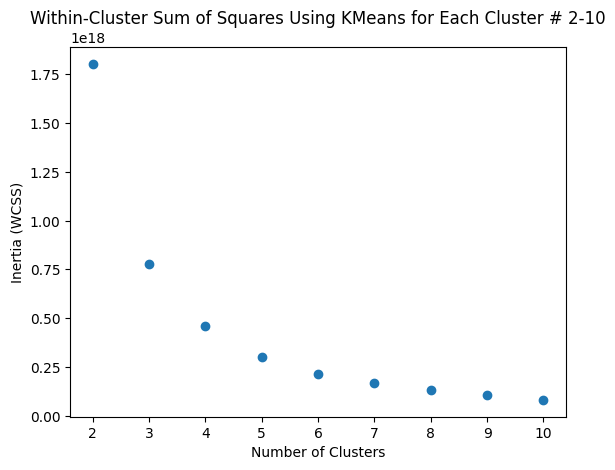

In [ ]:
plt.scatter(n_list, kmeans_list)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (WCSS)')
plt.title("Within-Cluster Sum of Squares Using KMeans for Each Cluster # 2-10")

To determine the optimal number of clusters we look for the "elbow" in this graph, or where the intertia starts to decrease fairly linearly.  There might be an argument for 4 or 5 clusters here; we went with 4 just to build some intiution: **bold text**

In [ ]:
kmeans = KMeans(4, n_init=5, random_state=0).fit(np.array(y_market_val_2019).reshape(-1,1))


In [ ]:
# center of each cluster summation

centers = kmeans.cluster_centers_
centers

array([[5.48046761e+05],
       [8.01759562e+07],
       [2.67620746e+08],
       [2.71197853e+07]])

In [ ]:
# number of observations in each cluster

kmeans.labels_
y_market_val_2019_df = pd.DataFrame(y_market_val_2019)
y_market_val_2019_df.loc[:, "kmean"] = kmeans.labels_
y_market_val_2019_df['kmean'].value_counts()

kmean
0    171046
3       852
1       209
2        25
Name: count, dtype: int64

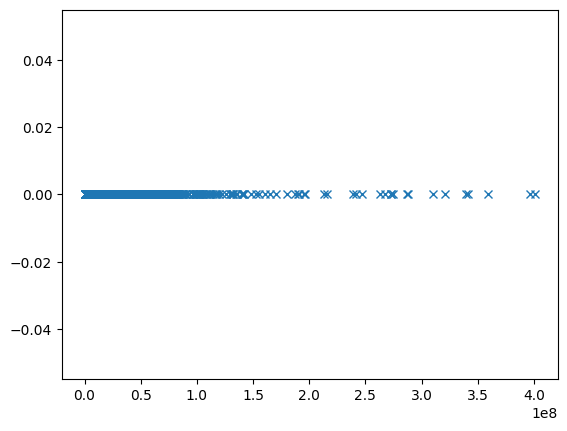

In [ ]:
# 1-D representation of 2019 market values confirms the kmeans clustering above

plt.plot(y_market_val_2019, np.zeros_like(y_market_val_2019), 'x')
plt.show()

Coming back to a simple approach discussed in the data exploration, we decided to partition the data by quartiles to more equally represent the data.  To do this we found the quartiles independently for 2019 and 2021.  Results are shown below.  

In [ ]:
parcels_and_demographics_df['market_val_2019'].describe()

count      172132
mean       815041
std       4914275
min           539
25%        281137
50%        372675
75%        548278
max     401326200
Name: market_val_2019, dtype: float64

In [ ]:
parcels_and_demographics_df['market_val_2021'].describe()

count      172132
mean       922466
std       5222438
min             0
25%        330701
50%        433749
75%        642666
max     409788700
Name: market_val_2021, dtype: float64

## **Section 4.3 precursor: Setting up Data For Subsequent Lat/Long Joins**


This section only exists so the notebook can be run in sections to account for RAM limitations.

In [ ]:
X_test = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Modeling/ModelingExports/X_test2019_preservedcoords.csv', dtype={'x_coord': str, 'y_coord': str})

In [ ]:
X_test.head()

test_coords = X_test[['x_coord', 'y_coord']]
test_coords

,x_coord,y_coord
0,626556.68669597,3350219.41364393
1,617784.74181232,3357964.22017517
2,619230.72721872,3363462.16347439
3,604293.15293551,3339816.85744672
4,619565.46253215,3361500.00459225
...,...,...
34422,617211.65289307,3347017.85637625
34423,625388.93819604,3347449.94753722
34424,617835.29044644,3360397.43777939
34425,612140.636797,3367127.84637148


## **Section 4.3: Logistic Regression**

Motivation: With some logical ways to cluster/partition the data, we moved into classification modeling strategies, starting with a logistic regression.

In [ ]:
# small function to add quartiles column to raw data

def add_quartiles(y_list, thresholds):
  quartiles = []
  for price in y_list:
    q = 4
    for t in thresholds:
      if price > t:
        quartiles.append(q)
        break
      if price == 0:
        quartiles.append(1)
        break
      q -= 1
  return quartiles



In [ ]:
# set up to run the logistic rgression

quartiles_2021 = [642666, 433749, 330701, 0]
quartiles_2019 = [548278, 372675, 281137, 0]

# create train/test label lists to replace the market value targets

y_test_2019_labels = add_quartiles(y_test_2019_list, quartiles_2019)
y_train_2019_labels = add_quartiles(y_train_2019_list, quartiles_2019)
y_test_2021_labels = add_quartiles(y_test_2021_list, quartiles_2021)
y_train_2021_labels = add_quartiles(y_train_2021_list, quartiles_2021)


In [ ]:
# logistic regression using SK Learn and scaled data w/PCA applied for 2019

log_reg_2019 = LogisticRegression().fit(pca_features_train_df, y_train_2019_labels)
y_log_pred_2019 = log_reg_2019.predict(pca_features_test_df)
log_reg_2019_acc = log_reg_2019.score(pca_features_test_df, y_test_2019_labels)

In [ ]:
log_reg_2019_acc

0.742062915734743

In [ ]:
len(y_test_2021_labels)

In [ ]:
# logistic regression using SK Learn and scaled data w/PCA applied for 2021


log_reg_2021 = LogisticRegression().fit(pca_features_train_df, y_train_2021_labels)
y_log_pred_2021 = log_reg_2021.predict(pca_features_test_df)
log_reg_2021_acc = log_reg_2021.score(pca_features_test_df, y_test_2021_labels)

In [ ]:
log_reg_2021_acc

0.7181572602898888

In [ ]:
# manually pulling all results into a dataframe for consolidation

log_reg_results = pd.DataFrame()

log_reg_results['x_coord'] = test_coords['x_coord']
log_reg_results['y_coord'] = test_coords['y_coord']

log_reg_results['actual_2019_quartiles'] = y_test_2019_labels
log_reg_results['pred_2019_quartiles'] = y_log_pred_2019
log_reg_results['actual_2021_quartiles'] = y_test_2021_labels
log_reg_results['pred_2021_quartiles'] = y_log_pred_2021
log_reg_results['2019_market_vals'] = y_test_2019_list
log_reg_results['2021_market_vals'] = y_test_2021_list


In [ ]:
log_reg_results['2019_pred_success'] = log_reg_results['actual_2019_quartiles'] == log_reg_results['pred_2019_quartiles']

log_reg_results['2021_pred_success'] = log_reg_results['actual_2021_quartiles'] == log_reg_results['pred_2021_quartiles']

In [ ]:
log_reg_results_final = pd.DataFrame()

log_reg_results_final = log_reg_results[['x_coord', 'y_coord', '2019_pred_success', '2021_pred_success']]

In [ ]:
# manual export of the final LogReg results
log_reg_results_final.to_csv('/content/drive/Shareddrives/545_GroupProject/Modeling/LogReg_Final_Results.csv')

Conclusions:

The 2019 accuracy for predicting the market quartile was 0.74, while the 2021 accuracy was 0.71.  Both of these rates seem lower than expected; we moved to a Feed Forward Neural Network in an attempt to improve our quartile predictions.

## **Section 4.4: Neural Network**

In [ ]:
# additional imports

from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### 4.4A: Data Loading and Processing

In [ ]:
# reindexing the quartile labels so they will work with the [0, n) constraints

y_train_2019_labels_reindexed = []
for label in y_train_2019_labels:
  y_train_2019_labels_reindexed.append(label-1)

y_test_2019_labels_reindexed = []
for label in y_test_2019_labels:
  y_test_2019_labels_reindexed.append(label-1)

y_train_2021_labels_reindexed = []
y_test_2021_labels_reindexed = []

for label in y_train_2021_labels:
  y_train_2021_labels_reindexed.append(label-1)

for label in y_test_2021_labels:
  y_test_2021_labels_reindexed.append(label-1)

In [ ]:
# create tensors for all features

pca_features_test_df.shape
X_torch_train = torch.tensor(pca_features_train_df.values, dtype = torch.float32)

X_torch_test = torch.tensor(pca_features_test_df.values, dtype = torch.float32)

In [ ]:
# create tensors for 2019 testing
y_torch_train_2019 = torch.tensor(y_train_2019_labels_reindexed, dtype = torch.float32)
y_torch_test_2019 = torch.tensor(y_test_2019_labels_reindexed, dtype = torch.float32)

In [ ]:
# create tensors for 2021 testing

y_torch_train_2021 = torch.tensor(y_train_2021_labels_reindexed, dtype = torch.float32)
y_torch_test_2021 = torch.tensor(y_test_2021_labels_reindexed, dtype = torch.float32)

In [ ]:
# load all data using pytorch Dataloader

import torch.utils.data as data_utils

torch_2019_train = data_utils.TensorDataset(X_torch_train, y_torch_train_2019)
train_loader_2019 = data_utils.DataLoader(torch_2019_train, batch_size=50, shuffle=True)

torch_2019_test = data_utils.TensorDataset(X_torch_test, y_torch_test_2019)
test_loader_2019 = data_utils.DataLoader(torch_2019_test, batch_size=50, shuffle=True)

torch_2021_train = data_utils.TensorDataset(X_torch_train, y_torch_train_2021)
train_loader_2021 = data_utils.DataLoader(torch_2021_train, batch_size=50, shuffle=True)

torch_2021_test = data_utils.TensorDataset(X_torch_test, y_torch_test_2021)
test_loader_2021 = data_utils.DataLoader(torch_2021_test, batch_size=50, shuffle=True)

In [ ]:
# define the feedforward neural network structure

class FNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.input_size = (368)
        self.hidden1_size = (1000)
        self.output_size = (4)
        self.linear1 = nn.Linear(self.input_size, self.hidden1_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(self.hidden1_size, self.output_size)

    def forward(self, x):
        outputs = self.flatten(x)
        outputs = self.linear1(outputs)
        outputs = self.relu(outputs)
        outputs = self.linear2(outputs)
        return outputs

In [ ]:
# define device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 4.4B: 2019 FNN Training and Output


In [ ]:
# train the FNN on the 2019 data

%%time

fnn = FNN().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(fnn.parameters(), lr=1e-4) #lr - learning step
epoch = 10

acc_LIST_FNN = []
loss_LIST_FNN = []

# Train the FNN
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader_2019:
      labels = labels.type(torch.LongTensor) # Cast to Long
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = fnn(inputs)
      preds = torch.argmax(outputs, axis=1)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      correct += (preds == labels).float().sum().detach().cpu()
      total += len(labels)
  accuracy = (correct / total) * 100
  acc_LIST_FNN.append(accuracy)
  loss_LIST_FNN.append(running_loss / len(train_loader_2019))

  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader_2019), accuracy))


The loss for Epoch 0 is: 0.6955521003196113, Accuracy = 71.2828140258789
The loss for Epoch 1 is: 0.6288295702903977, Accuracy = 73.13024139404297
The loss for Epoch 2 is: 0.6150988102608281, Accuracy = 73.68795776367188
The loss for Epoch 3 is: 0.6050111473309799, Accuracy = 73.94792938232422
The loss for Epoch 4 is: 0.5980686865787541, Accuracy = 74.22824096679688
The loss for Epoch 5 is: 0.5914908542390743, Accuracy = 74.57608795166016
The loss for Epoch 6 is: 0.585543280818285, Accuracy = 74.72350311279297
The loss for Epoch 7 is: 0.5802467541502089, Accuracy = 74.9762191772461
The loss for Epoch 8 is: 0.5754370090208556, Accuracy = 75.11927795410156
The loss for Epoch 9 is: 0.569932162015278, Accuracy = 75.43153381347656
CPU times: user 1min 38s, sys: 632 ms, total: 1min 39s
Wall time: 1min 40s


In [ ]:
# test on the 2019 data

total = 0
correct = 0
with torch.no_grad():
    for data, labels in test_loader_2019:
        labels = labels.type(torch.LongTensor) # Cast to Float
        data, labels = data.to(device), labels.to(device)

        outputs = fnn(data)
        preds = torch.argmax(outputs, axis=1)
        loss = criterion(outputs, labels)
        correct += (preds == labels).float().sum().detach().cpu()
        total += len(labels)


test_acc_FNN = correct/total *100


print('Test Accuracy for 2019: ' + str(test_acc_FNN.item()))

Test Accuracy for 2019: 74.45319366455078


In [ ]:
def labels_generator(test_loader):
  y_true = []
  y_pred = []
  with torch.no_grad():
    for data, labels in test_loader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        data, labels = data.to(device), labels.to(device)
        outputs = fnn(data)
        preds = torch.argmax(outputs, axis=1)

        y_true.extend([label.item() + 1 for label in labels])
        y_pred.extend([pred.item() + 1 for pred in preds])
  return y_true, y_pred


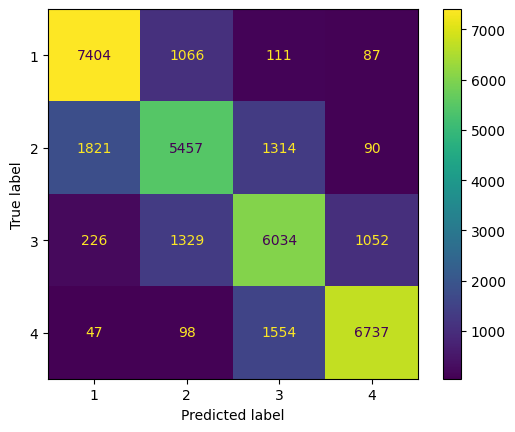

In [ ]:
# confusion matrix for 2019 data

labels = [1, 2, 3, 4]

y_2019_true, y_2019_FNN_pred = labels_generator(test_loader_2019)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_2019_true, y_2019_FNN_pred), display_labels=labels)
disp.plot()

plt.show()

The above confusion matrix for the 2019 data illustrates some interesting themes.  The 1st and 4th quartile predictions were overwhelmingly the most accurate, while the 2nd and 3rd quartiles tended to be less accurate.  

Q1 Accuracy: .86

Q2 Accuracy: .63

Q3 Accuracy: .70

Q4 Accuracy: .78

Intuitively, the high Q1 accuracy felt surprising beause the bottom half of this data was so densly packed.  Hypothesis around these results are reported below.  

### 4.4C: 2021 FFN Training and Output

In [ ]:
# re-train FFN on the 2021 data

%%time

fnn = FNN().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(fnn.parameters(), lr=1e-4) #lr - learning step
epoch = 10

acc_LIST_FNN = []
loss_LIST_FNN = []

# Train the FNN
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader_2021:
      labels = labels.type(torch.LongTensor) # Cast to Long
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = fnn(inputs)
      preds = torch.argmax(outputs, axis=1)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      correct += (preds == labels).float().sum().detach().cpu()
      total += len(labels)
  accuracy = (correct / total) * 100
  acc_LIST_FNN.append(accuracy)
  loss_LIST_FNN.append(running_loss / len(train_loader_2021))

  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader_2021), accuracy))


The loss for Epoch 0 is: 0.7396101366586564, Accuracy = 69.31047821044922
The loss for Epoch 1 is: 0.6752802084340375, Accuracy = 70.91246032714844
The loss for Epoch 2 is: 0.6621503674291656, Accuracy = 71.237060546875
The loss for Epoch 3 is: 0.6521246221234275, Accuracy = 71.5820083618164
The loss for Epoch 4 is: 0.6451001079567115, Accuracy = 71.77589416503906
The loss for Epoch 5 is: 0.6381663911950567, Accuracy = 72.13681030273438
The loss for Epoch 6 is: 0.6334676398664117, Accuracy = 72.2500991821289
The loss for Epoch 7 is: 0.6278355138704261, Accuracy = 72.50717163085938
The loss for Epoch 8 is: 0.6235928793243402, Accuracy = 72.7569808959961
The loss for Epoch 9 is: 0.6177722448986801, Accuracy = 73.01696014404297
CPU times: user 1min 38s, sys: 633 ms, total: 1min 38s
Wall time: 1min 39s


In [ ]:
# test on the 2021 data

total = 0
correct = 0
with torch.no_grad():
    for data, labels in test_loader_2021:
        labels = labels.type(torch.LongTensor) # Cast to Float
        data, labels = data.to(device), labels.to(device)

        outputs = fnn(data)
        preds = torch.argmax(outputs, axis=1)
        loss = criterion(outputs, labels)
        correct += (preds == labels).float().sum().detach().cpu()
        total += len(labels)


test_acc_FNN = correct/total *100

print('Test Accuracy for 2021: ' + str(test_acc_FNN.item()))

Test Accuracy for 2021: 72.04228973388672


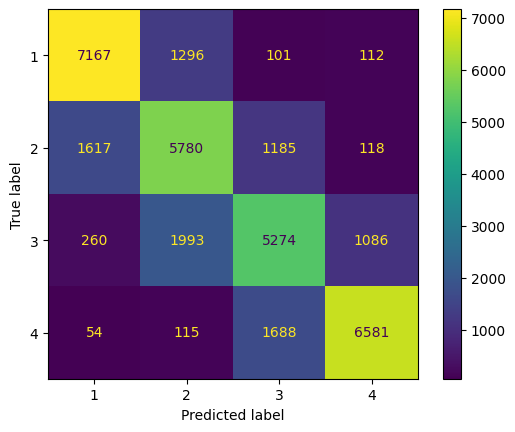

In [ ]:
# confusion matrix for 2021 data

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


labels = [1, 2, 3, 4]

y_2021_true, y_2021_FNN_pred = labels_generator(test_loader_2021)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_2021_true, y_2021_FNN_pred), display_labels=labels)
disp.plot()

plt.show()

The above confusion matrix for the 2021 data illustrates similar themes.  Again the 1st and 4th quartile predictions were the most accurate (although the model as a whole was slightly less accurate than 2021):

Q1 Accuracy: .83

Q2 Accuracy: .67

Q3 Accuracy: .61

Q4 Accuracy: .76



### 4.4D: Final Consolidation For Export

In [ ]:
# manually pulling all the results into a dataframe for consolidation

FFN_results = pd.DataFrame()


FFN_results['x_coord'] = test_coords['x_coord']
FFN_results['y_coord'] = test_coords['y_coord']


FFN_results['actual_2019_quartiles'] = y_test_2019_labels
FFN_results['pred_2019_FFN'] = y_2019_FNN_pred
FFN_results['actual_2021_quartiles'] = y_test_2021_labels
FFN_results['pred_2021_FFN'] = y_2021_FNN_pred
FFN_results['2019_market_vals'] = y_test_2019_list
FFN_results['2021_market_vals'] = y_test_2021_list

In [ ]:
FFN_results['2019_pred_success'] = FFN_results['actual_2019_quartiles'] == FFN_results['pred_2019_FFN']

FFN_results['2021_pred_success'] = FFN_results['actual_2021_quartiles'] == FFN_results['pred_2021_FFN']

In [ ]:
FFN_results

,x_coord,y_coord,actual_2019_quartiles,pred_2019_FFN,actual_2021_quartiles,pred_2021_FFN,2019_market_vals,2021_market_vals,2019_pred_success,2021_pred_success
0,626556.68669597,3350219.41364393,1,1,2,2,256053,408674,True,True
1,617784.74181232,3357964.22017517,4,4,4,4,716400,804456,True,True
2,619230.72721872,3363462.16347439,3,4,3,3,506145,633953,False,True
3,604293.15293551,3339816.85744672,3,1,3,1,532981,612087,False,False
4,619565.46253215,3361500.00459225,4,4,4,2,572012,689773,True,False
...,...,...,...,...,...,...,...,...,...,...
34422,617211.65289307,3347017.85637625,3,4,3,3,406400,579000,False,True
34423,625388.93819604,3347449.94753722,4,3,4,3,4700000,5422788,False,False
34424,617835.29044644,3360397.43777939,4,2,4,2,683425,872246,False,False
34425,612140.636797,3367127.84637148,3,4,3,1,507055,584801,False,False


In [ ]:
FNN_results_final = FFN_results[['x_coord', 'y_coord', '2019_pred_success', '2021_pred_success']]

In [ ]:
FNN_results_final.to_csv('/content/drive/Shareddrives/545_GroupProject/Modeling/FNN_Final_Results.csv')

In [ ]:
log_reg_results = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Modeling/LogReg_Results.csv')
ffn_results = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Modeling/FNN_Results.csv')
# y_test_2021_df = pd.read_csv('/content/drive/Shareddrives/545_GroupProject/Analysis/Testing/y_test_2021.csv')
# y_test_2021_df.drop(['Unnamed: 0'], axis='columns', inplace=True)



## **Section 4.5: Visually Exploring the Results**


At first brush, it was attempting to assume the Q1 predictions were more accurate because the prices in those neighborhoods were more stagnant.  A percent change breakdown, however, indicates that the thresholds appreciated fairly consistently across the board between 2019 and 2021 (i.e. the quartiles experiences relatively similar appreciation):

Q1 Threshold Increase from 2019 to 2021: 17.6%

Q2 Threshold Increase from 2019 to 2021: 16.4%

Q3 Threshold Increase from 2019 to 2021: 17.2%

Below, we see the results from the FFN, where green indicates a correct quartiles prediction, and red indicates an incorrect quartile prediction:

FFN 2019

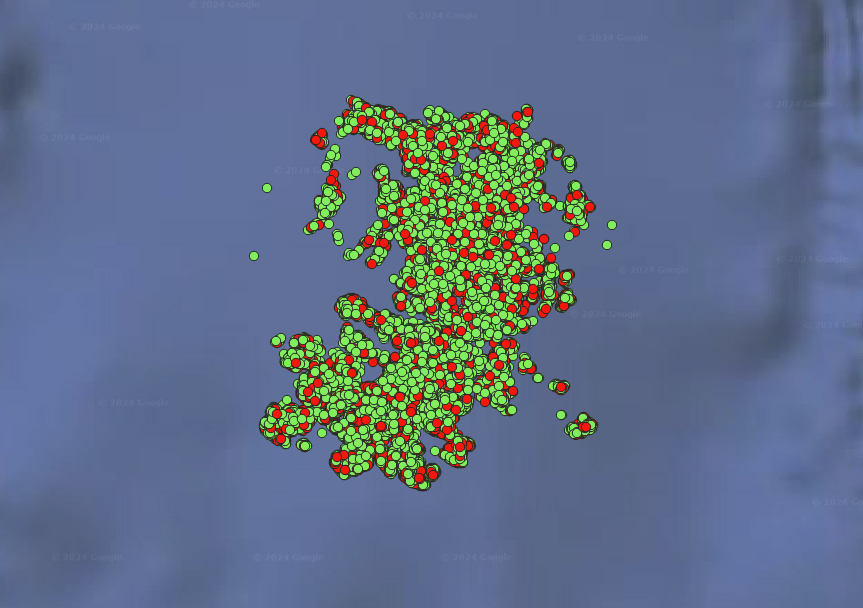

FFN 2021

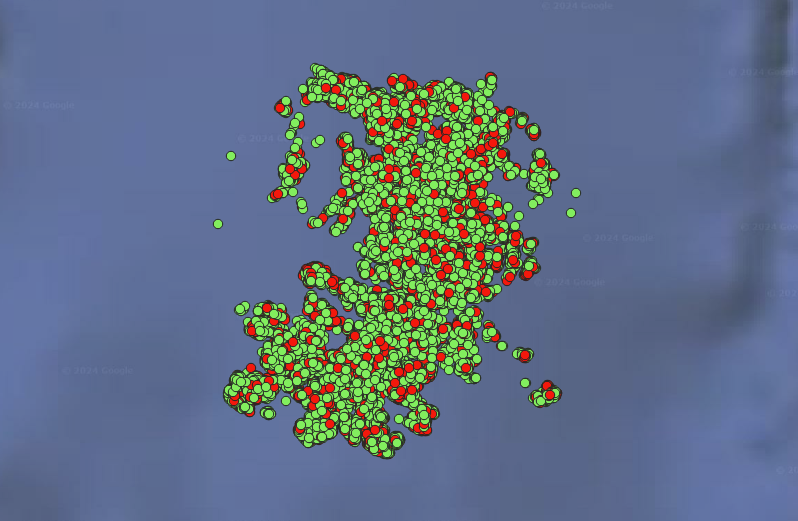

This visualization does not immediately give insight as to why our Q1 and Q4 predictions are much more reliable than our other quartiles. However, looking back at earlier parts of our exploratory data analysis, certain simple visual trends were clear only when considering the middle two quartiles of property value (Q2, Q3). For example, when plotting the first two principal components in 2D, the natural clusters of property value were only visible once members of Q1 and Q4 were removed from the pool. This same logic may apply to the larger scheme of our predictive modeling, where more than two features are being considered.

As a topic for future research, it would be interesting to investigate how our predictive models would perform if only instances within the middle quartiles (Q2, Q3) of property value were considered during training and testing. However, this model would be limited, as it would NOT generalize well to real-life scenarios where property values in Q1 or Q4 might be encountered. Furthermore, it would be interesting to investigate which features account for the most variability in each of the quartiles in our original model. This might reveal whether quartile predictions are all impacted equally by the same principal features/components, or if certain features are biased more toward specific quartiles. Overall, if we had more time, it would be interesting to see how we might improve our prediction accuracy so these models could be used in real life urban planning scenarios.